# Questão de Negócio (contextualizando)

A Rossmann opera mais de 3.000 drogarias em 7 países europeus. Atualmente, os gerentes de loja da Rossmann têm a tarefa de prever suas vendas diárias com até seis semanas de antecedência. As vendas da loja são influenciadas por muitos fatores, incluindo promoções, concorrência, feriados escolares e estaduais, sazonalidade e localidade. Com milhares de gerentes individuais prevendo vendas com base em suas circunstâncias únicas, a precisão dos resultados pode variar bastante. Com isso o CFO pediu para que a equipe de dados faça uma previsão unificada de todas as lojas.

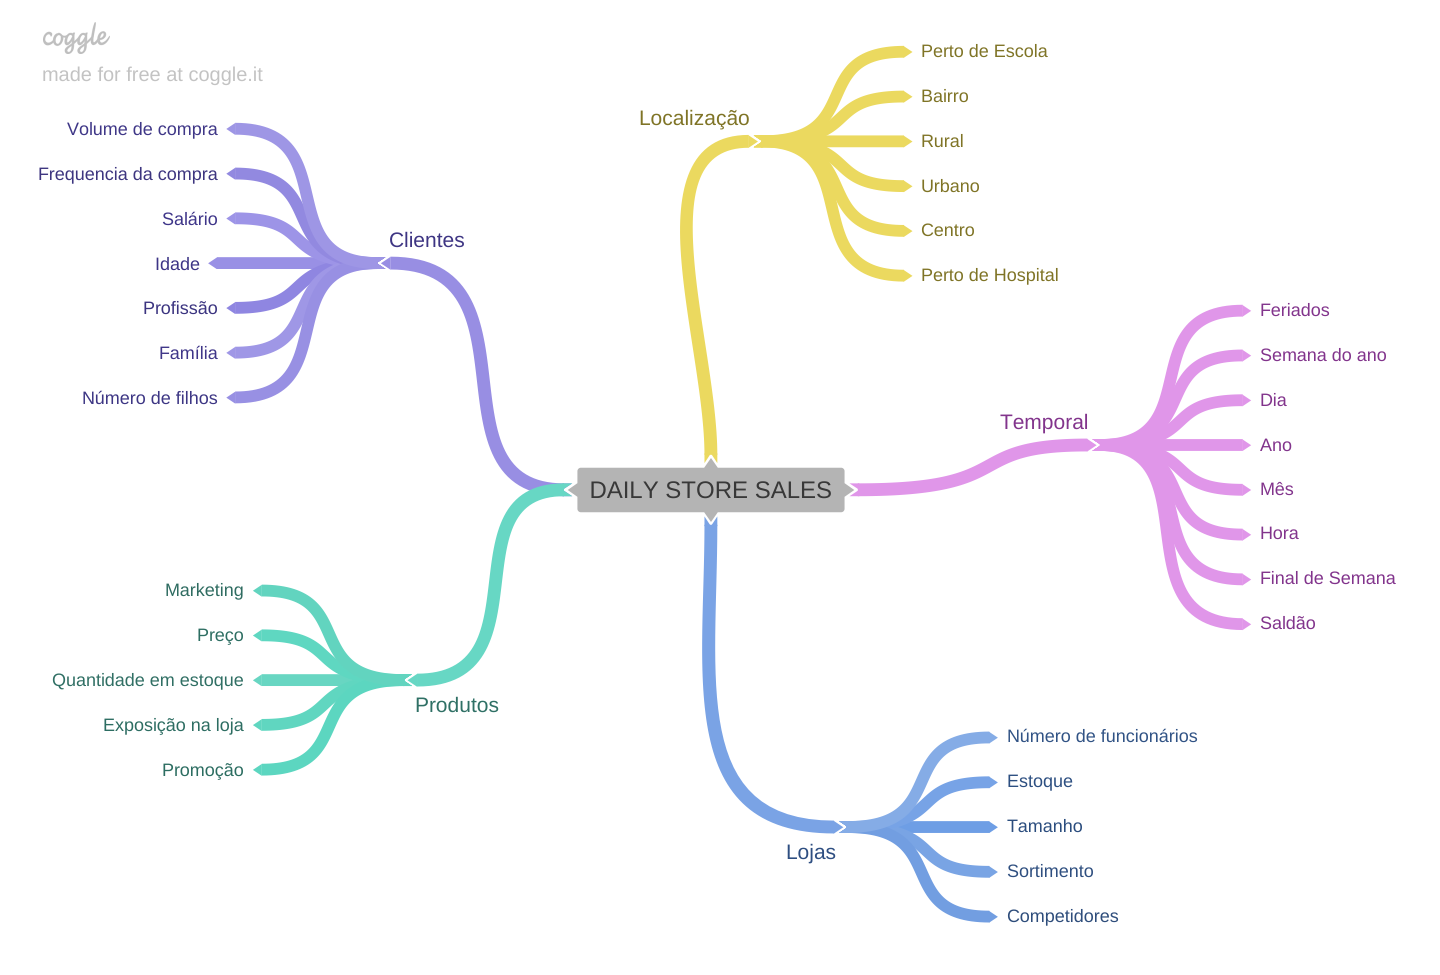

In [5]:
Image('MindMapHypotesis.png')

* H1 - Em média, dias da semana influenciam nas vendas - mais que os finais de semana?
* H2 - Quanto maior o número de customers, maior o número de sales?
* H3 - Períodos com promoção vendem mais que períodos normais?
* H4 - Lojas com promoção estendida vendem mais que as que não estendem?
* H5 - Em feriados as lojas tendem a vender menos
* H6 - No período de férias escolares as lojas vendem menos
* H7 - O tipo de lojas influencia na média de vendas
* H8 - Quanto maior o assortment da loja maior a media de vendas?
* H9 - O mês influencia nas vendas? 
* H10 - o dia do mês influencia nas vendas?
* H11 - Com competidores próximos, as lojas tendem a vender menos?



# 0.0 Imports

In [187]:
import datetime
import inflection
import math
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import seaborn           as sns
import xgboost           as xg
import scikitplot        as skplt
import warnings
import pickle
import joblib

from IPython.display                      import HTML
from IPython.display                      import Image
from IPython.display                      import display, Math, Latex
from scipy                                import stats as ss
from sklearn.model_selection              import train_test_split
from tabulate                             import tabulate
from sklearn.preprocessing                import RobustScaler, MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline                     import Pipeline
from sklearn.compose                      import ColumnTransformer
from sklearn.linear_model                 import LinearRegression, Lasso, Ridge
from sklearn.ensemble                     import RandomForestRegressor
from sklearn.metrics                      import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from skopt                                import dummy_minimize, gp_minimize
from skopt.plots                          import plot_convergence
from statsmodels.stats.outliers_influence import variance_inflation_factor


## 0.1 Helper Function (Class)

In [38]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = 50
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

#########################################################

def num_statistic(data): # para estatisticas descritivas
    #seleção de variáveis numéricas
    num_attributes = data.select_dtypes(include = ('int64', 'float64'))

    #tendencia Central - mean, median ----- dispersão - std, min, max, range, skew, kurtosis
    count_ = pd.DataFrame( num_attributes.count()).T
    range_ = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
    min_ = pd.DataFrame( num_attributes.min()).T
    q1 = pd.DataFrame( num_attributes.quantile(0.25)).T
    median_ = pd.DataFrame( num_attributes.apply(np.median)).T
    q3 = pd.DataFrame( num_attributes.quantile(0.75)).T
    max_ = pd.DataFrame( num_attributes.max()).T
    mean_ = pd.DataFrame( num_attributes.apply(np.mean)).T
    std_ = pd.DataFrame( num_attributes.apply(np.std)).T
    skew = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
    kurtosis = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

    #Concatenar
    m = pd.concat( [count_, range_, min_, q1, median_, q3, max_, mean_, std_, skew, kurtosis] ).T.reset_index()
    m.columns = ['attributes', 'count', 'range', 'min', '25%', '50%', '75%', 'max', 'mean', 'std', 'skew', 'kurtosis']
    
    return m

#########################################################

def cramer_v (x,y): #FUNÇÃO PARA CALCULO DE CRAMER.V - ANALISE MULTIVARIADA
    cm = pd.crosstab (x, y).values
    n = cm.sum() #soma de todos os valores da matriz
    r, k =cm.shape #número de linhas e colunas
    
    chi2 = ss.chi2_contingency(cm) [0] #método pronto para calculo de chi2 (precisa de uma tabela de contingencia (CM) para o calculo) / biblioteca scipy
    chi2corr = max(0 , chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
        
    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1)))

#########################################################

def feature_engineering(data):
  
    data = data.loc[data['open'] > 0]

    data['competition_open_since_month'] = data['competition_open_since_month'].astype('int64') 
    data['competition_open_since_year'] = data['competition_open_since_year'].astype('int64')
    data['competition_distance'] = data['competition_distance'].astype('int64')
    data['promo2_since_week'] = data['promo2_since_week'].astype('int64')
    data['promo2_since_year'] = data['promo2_since_year'].astype('int64')
    data['competition_time_month'] = data['competition_time_month'].astype('int64')
    data['promo_time_week'] = data['promo_time_week'].astype('int64')
    data['week_of_year'] = data['week_of_year'].astype('int64')

    # month
    data['month_sin'] = data['month'].apply ( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) ) # aplica a função seno / 12 é o periodo ciclico - 12 meses do ano
    data['month_cos'] = data['month'].apply ( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) ) # aplica a função cosseno / 12 é o periodo ciclico - 12 meses do ano

    # day
    data['day_sin'] = data['day'].apply ( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) ) # aplica a função seno / 30 é o periodo ciclico - média 30 dias no mês
    data['day_cos'] = data['day'].apply ( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) ) # aplica a função cosseno / 30 é o periodo ciclico - média 30 dias no mês

    # week of year
    data['week_of_year_sin'] = data['week_of_year'].apply ( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) ) # aplica a função seno / 52 é o periodo ciclico - 52 semanas no ano
    data['week_of_year_cos'] = data['week_of_year'].apply ( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) ) # aplica a função cosseno / 52 é o periodo ciclico - 52 semanas no ano

    # day of week
    data['day_of_week_sin'] = data['day_of_week'].apply ( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) ) # aplica a função seno / 7 é o periodo ciclico - 7 dias na semana
    data['day_of_week_cos'] = data['day_of_week'].apply ( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) ) # aplica a função cosseno / 7 é o periodo ciclico - 7 dias na semana

    return data

#########################################################

def reg_metrics(model_name, y_true, y_pred ):
    model_name = model_name

    # Mean Absolute Error
    MAE = np.round(np.mean(np.abs(y_true - y_pred)), 2)

    # Root Mean Squared Error
    RMSE = np.round(np.sqrt(np.mean(np.square(y_true - y_pred))), 2)

    #filtragem para usar no MAPE e RMSPE
    dfy = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}) #transforma em dataframe y_true e y_pred
    dfy = dfy.loc[dfy.y_true != 0, :] #seleciona as linhas != de zero

    # Mean Absolute Percentage Error
    MAPE = np.round(np.mean(np.abs((dfy.y_true - dfy.y_pred)/dfy.y_true)), 2)
   
    # Root Mean Squared Percentage Error
    RMSPE = np.round(np.sqrt(np.mean(np.square((dfy.y_true - dfy.y_pred)/dfy.y_true))), 2)


    metrics = pd.DataFrame({'Modelo': model_name, 'MAE': MAE, 'MAPE': MAPE, 'RMSE': RMSE, 'RMSPE': RMSPE}, index=[0])

    return metrics

#########################################################

def reg_metrics_cv( k, model_name, y_true, y_pred ):
    model_name = model_name

    # Mean Absolute Error
    MAE = np.round(np.mean(np.abs(y_true - y_pred)), 2)

    # Root Mean Squared Error
    RMSE = np.round(np.sqrt(np.mean(np.square(y_true - y_pred))), 2)

    #filtragem para usar no MAPE e RMSPE
    dfy = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}) #transforma em dataframe y_true e y_pred
    dfy = dfy.loc[dfy.y_true != 0, :] #seleciona as linhas != de zero

    # Mean Absolute Percentage Error
    MAPE = np.round(np.mean(np.abs((dfy.y_true - dfy.y_pred)/dfy.y_true)), 2)
   
    # Root Mean Squared Percentage Error
    RMSPE = np.round(np.sqrt(np.mean(np.square((dfy.y_true - dfy.y_pred)/dfy.y_true))), 2)


    metrics = pd.DataFrame({'K': k, 'Modelo': model_name, 'MAE': MAE, 'MAPE': MAPE, 'RMSE': RMSE, 'RMSPE': RMSPE}, index=[0])

    return metrics

#########################################################

def cross_validation(modelo, model_name, data, kfold ):

    X_cols = ['store', 'promo', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 
              'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'month_sin', 
              'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos', 
              'assortment', 'state_holiday', 'store_type']
    kfold = kfold
    data = data.copy()
    treino = pd.DataFrame()
    validacao = pd.DataFrame()
        
    for k in reversed(range(1,kfold+1)): #usa o reversed para acompanhar na evolução de tempo
        data_final = data.date.max()
        data_inicio_val = data_final - datetime.timedelta(days=k*6*7)
        data_fim_val = data_inicio_val + datetime.timedelta(days=6*7)

        df_treino = data.loc[data.date < data_inicio_val]
        df_val = data.loc[(data.date >= data_inicio_val) & (data.date <= data_fim_val)]

        # Separação treino e val X e Y
        X_train = df_treino[X_cols]
        y_train = np.log1p(df_treino.sales)

        X_val = df_val[X_cols]
        y_val = np.log1p(df_val.sales)

        # Pre-processamento
        X_train = column_transf.fit_transform(X_train)
        X_val = column_transf.transform(X_val)

        # Treinamento e predição
        model = modelo
        model.fit(X_train, y_train)
        y_pred = model.predict(X_train)
        y_pred_val = model.predict(X_val)

        train_metrics = reg_metrics_cv(k, model_name, np.expm1(y_train), np.expm1(y_pred))
        val_metrics = reg_metrics_cv(k, (f'{model_name}_val'), np.expm1(y_val), np.expm1(y_pred_val))

        treino = pd.concat([treino, train_metrics], ignore_index=True)
        treino = pd.concat([treino, val_metrics], ignore_index=True)
        validacao = pd.concat([validacao, val_metrics], ignore_index=True)

    media = pd.DataFrame({'Modelo': model_name, 'MAE': validacao.MAE.mean(), 'MAPE': validacao.MAPE.mean(), 
                          'RMSE': validacao.RMSE.mean(), 'RMSPE': validacao.RMSPE.mean()}, index=[0])

    return (treino, media)

#########################################################
# Função somente para uso no HYPERPARAMETER FINETUNNING
def training_model(parametros):
    eta = parametros[0]
    max_depth = parametros[1]
    min_child_weight = parametros[2]
    subsample = parametros[3]
    colsample_bytree = parametros[4]
    n_estimators = parametros[5]

    print(parametros,'\n')

    xgb_model = xg.XGBRegressor(eta = eta,
                                  max_depth = max_depth,
                                  min_child_weight = min_child_weight,
                                  subsample = subsample,
                                  colsample_bytree = colsample_bytree,
                                  n_estimators = n_estimators,
                                  n_jobs=-1)
    
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_val)

    rmse = int(np.sqrt(mean_squared_error(y_val, y_pred)))

    return rmse

In [39]:
jupyter_settings()
warnings.filterwarnings('ignore')

## 0.2 Carregamento/Coleta dos dados

In [38]:
df_store_raw = pd.read_csv('dataset/store.csv', low_memory = False)
df_train_raw = pd.read_csv('dataset/train.csv', low_memory = False)

df_raw = df_train_raw.merge(df_store_raw, how='left', on='Store')

print(f'df_store_raw = {df_store_raw.shape},\ndf_train_raw = {df_train_raw.shape},\ndf = {df_raw.shape}')

df_store_raw = (1115, 10),
df_train_raw = (1017209, 9),
df = (1017209, 18)


# 1.0 Descrição dos dados 



* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on * state holidays. Note that all schools are closed on public holidays and weekends. a = public * holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest * competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## 1.1 Data Dimension

In [39]:
df = df_raw.copy()

In [40]:
#altera nomes das colunas
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

#define a função para transformar as strings
lower_ = lambda x: x.lower() #transforma em letras minusculas
snakecase = lambda x: inflection.underscore(x) #transforma em letra minuscula com separação por underscore


#define a variavel, com a lista da aplicação da função map
new_cols = list (map(snakecase,old_cols))

#RENAME - substitui o nome das colunas pela new_cols
df.columns = new_cols

In [41]:
print(f'O conjunto de dados possui {df.shape[0]} linhas')
print(f'O conjunto de dados possui {df.shape[1]} colunas')

O conjunto de dados possui 1017209 linhas
O conjunto de dados possui 18 colunas


## 1.2 Data Types

In [42]:
df.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [43]:
df['date'] = pd.to_datetime(df['date'])

## 1.3 Check NA

In [44]:
df.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [45]:
#Identifica as lojas que estão com NAN no Competition Distance
aux = df[['store', 'competition_distance']].groupby('store').min().reset_index()
aux.loc[aux['competition_distance'].isna()]

,store,competition_distance
290,291,NaN
621,622,NaN
878,879,NaN


In [46]:
# Todas as lojas com NAN na Coluna Competition Distance não possuem histórico de distancia, portanto será substituido por um valor 
(df.loc[((df['store']==291) | (df['store']==622) | (df['store']==879)), 'competition_distance']).unique()

array([nan])

In [47]:
# competition_distance - assumindo que a próxima farmácia é muito distante e não tem competição, então será substituido por um valor muito maior que o valor maximo apresentado.

df.loc[df['competition_distance'].isna(), 'competition_distance'] = 200000.0

# competition_open_since_month - assumindo a data de venda  

df['competition_open_since_month'] = df.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'])
                                                else x['competition_open_since_month'], axis=1)
                                          
# competition_open_since_year - assumindo a data de venda      

df['competition_open_since_year'] = df.apply (lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) 
                                              else x['competition_open_since_year'], axis=1)

# promo2_since_week  

df['promo2_since_week'] = df.apply (lambda x: x['date'].week if math.isnan(x['promo2_since_week']) 
                                    else x['promo2_since_week'], axis=1)


# promo2_since_year  

df['promo2_since_year'] = df.apply (lambda x: x['date'].year if math.isnan(x['promo2_since_year']) 
                                    else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan',  2: 'Feb',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',
               8: 'Aug',  9: 'Sept',  10: 'Oct', 11: 'Nov', 12: 'Dec'} # cria dicionário para substituir o numero do mês

df['promo_interval'].fillna(0, inplace=True )

df['month_map'] = df['date'].dt.month.map( month_map )


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 19 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

## 1.4 Data Descriptive - Estatística Descritiva

In [18]:
num_statistic(df)

,attributes,count,range,min,25%,50%,75%,max,mean,std,skew,kurtosis
0,store,1017209.0,1114.0,1.0,280.0,558.0,838.0,1115.0,558.429727,321.908493,-0.000955,-1.200524
1,day_of_week,1017209.0,6.0,1.0,2.0,4.0,6.0,7.0,3.998341,1.997390,0.001593,-1.246873
2,sales,1017209.0,41551.0,0.0,3727.0,5744.0,7856.0,41551.0,5773.818972,3849.924283,0.641460,1.778375
3,customers,1017209.0,7388.0,0.0,405.0,609.0,837.0,7388.0,633.145946,464.411506,1.598650,7.091773
4,open,1017209.0,1.0,0.0,1.0,1.0,1.0,1.0,0.830107,0.375539,-1.758045,1.090723
5,promo,1017209.0,1.0,0.0,0.0,0.0,1.0,1.0,0.381515,0.485758,0.487838,-1.762018
6,school_holiday,1017209.0,1.0,0.0,0.0,0.0,0.0,1.0,0.178647,0.383056,1.677842,0.815154
7,competition_distance,1017209.0,199980.0,20.0,710.0,2330.0,6910.0,200000.0,5935.442677,12547.646829,10.242344,147.789712
8,competition_open_since_month,1017209.0,11.0,1.0,4.0,7.0,10.0,12.0,6.786849,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1017209.0,115.0,1900.0,2008.0,2012.0,2014.0,2015.0,2010.324840,5.515591,-7.235657,124.071304


In [19]:
cat_attributes = df.select_dtypes(exclude = ('int64', 'float64', 'datetime64[ns]'))

In [20]:
#para identificar a quantidade de variaveis
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

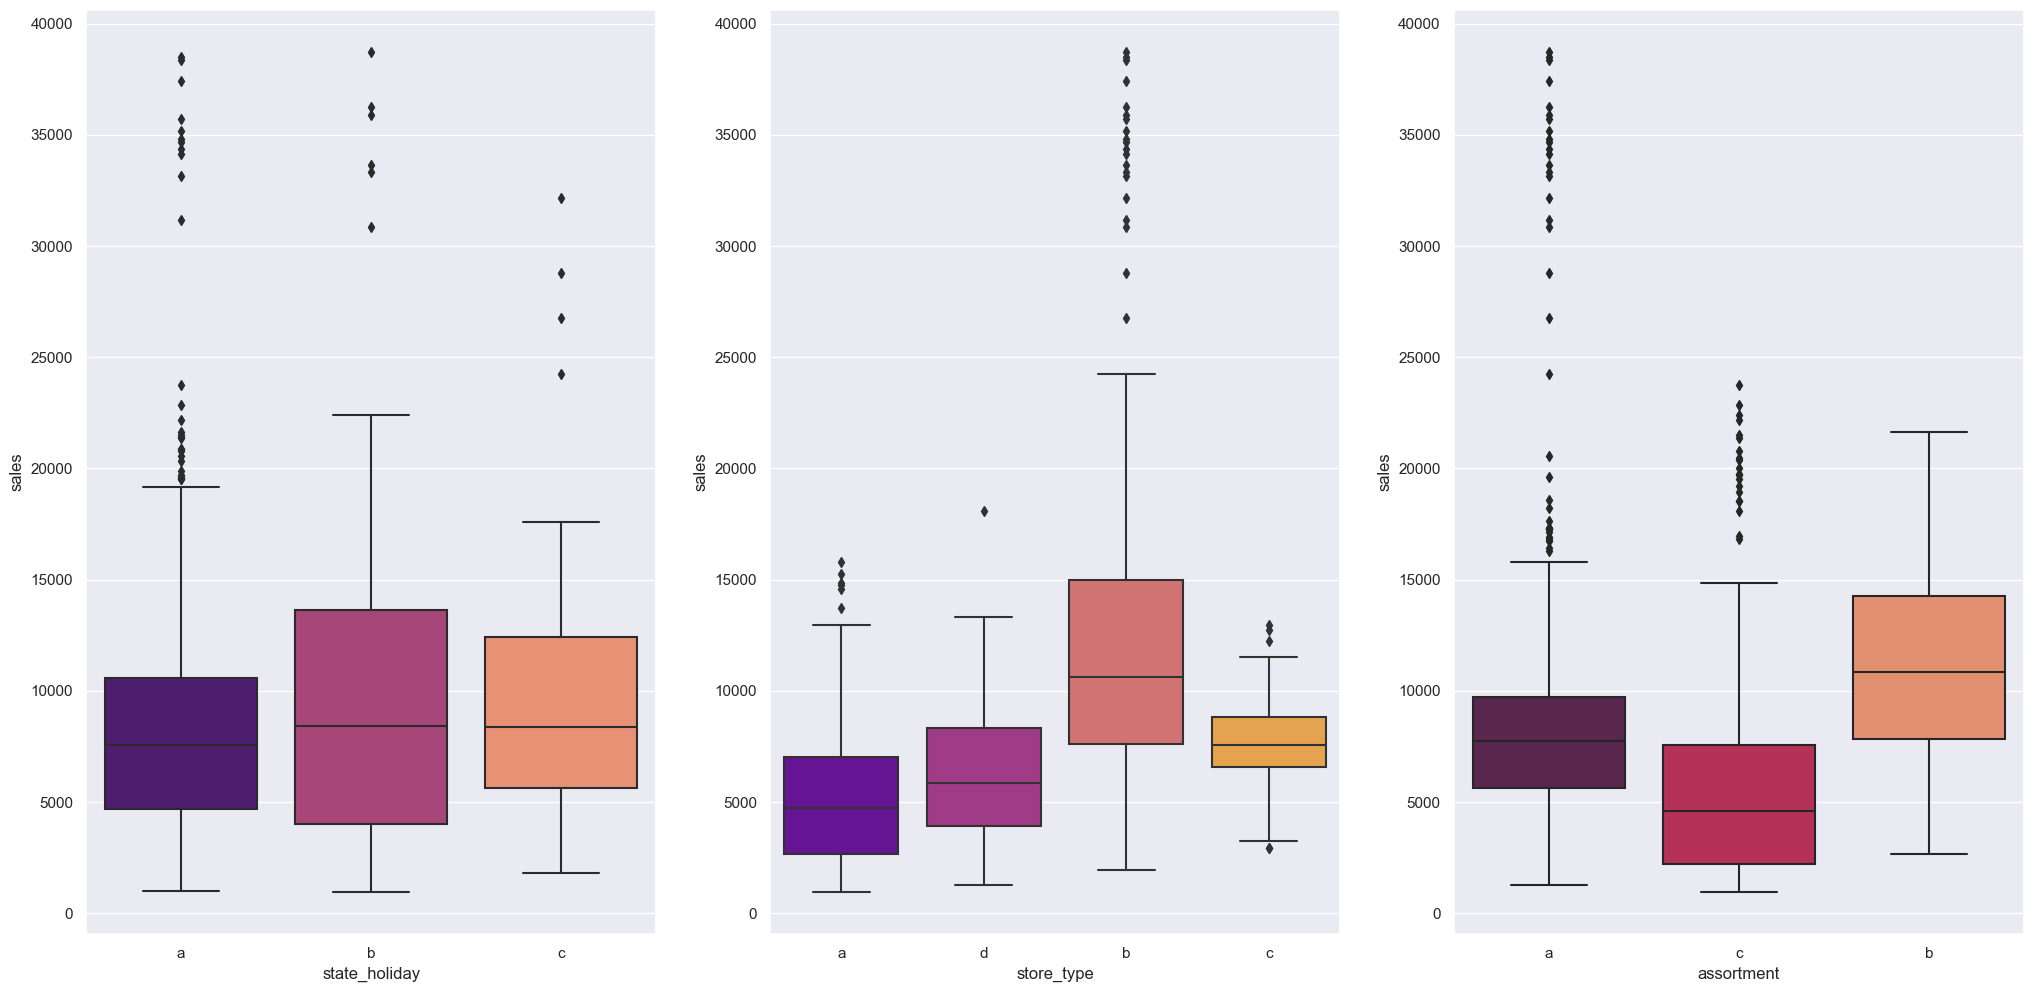

In [21]:
#cria variavel auxiliar para retirar valores = 0
aux = df[(df['state_holiday'] != '0') & (df['open'] > 0)]
#aux1 = df[df['sales'] > 0]

#para colocar os graficos lado a lado (plt.subplot( linhas, colunas, posição)).
plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux, palette='magma' );

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux, palette='plasma'  );

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux, palette='rocket'  );

# 2.0 Split de dados e preparação para EDA

In [51]:
df2 = df.copy()

## 2.1 Preparação dos dados

In [55]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week 

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=int(x['competition_open_since_year']), 
                                                                    month=int(x['competition_open_since_month']), day=1 ), axis=1 )

df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )


# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 
                                                                'eater_holiday' if x == 'b' else 
                                                                'christmas' if x == 'c' else 'regular_day')

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(int).astype( str ) + '-' + df2['promo2_since_week'].astype(int).astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'])/7 ).apply( lambda x: x.days ).astype( int )


df2['trimestre'] = df2.month.apply(lambda x: 1 if x <= 3 else
                                   2 if x <= 6 else
                                   3 if x <= 9 else
                                   4)

# substitui valores de competition_open_since_year menores que 1972 por 1972, visto que a rede iniciou as atividades nesse ano.
df2['competition_open_since_year'] = df2['competition_open_since_year'].apply(lambda x: 1972 if x < 1972 else x)

## 2.2 Split de dados - Treino, Validação e Teste

In [22]:
#df2['date'].max()

df2.loc[df2.store == 1115, 'date'].min()

Timestamp('2013-01-01 00:00:00')

In [58]:
# dados de teste terão 6 semanas

max_date_test = df2['date'].max()
inicial_date_test = df2['date'].max() - datetime.timedelta(days=42)

max_date_val = inicial_date_test - datetime.timedelta(days=1) 
inicial_date_val = max_date_val - datetime.timedelta(days=42)

max_date_train = inicial_date_val - datetime.timedelta(days=1)
inicial_date_train = df2['date'].min()

print(f' Datas para test: {max_date_test,inicial_date_test}')
print(f' Datas para validação: {max_date_val,inicial_date_val}')
print(f' Datas para treino: {max_date_train,inicial_date_train}')

 Datas para test: (Timestamp('2015-07-31 00:00:00'), Timestamp('2015-06-19 00:00:00'))
 Datas para validação: (Timestamp('2015-06-18 00:00:00'), Timestamp('2015-05-07 00:00:00'))
 Datas para treino: (Timestamp('2015-05-06 00:00:00'), Timestamp('2013-01-01 00:00:00'))


In [59]:
test = df2.loc[(df2['date'] >= inicial_date_test) & (df2['date'] <= max_date_test), : ]
validation = df2.loc[(df2['date'] >= inicial_date_val) & (df2['date'] <= max_date_val), : ]
train = df2.loc[(df2['date'] >= inicial_date_train) & (df2['date'] <= max_date_train), : ]

In [60]:
test.to_csv('test.csv', index=False) 
validation.to_csv('validation.csv', index=False)
train.to_csv('train.csv', index=False)

# 3.0 Análise Exploratória de dados
   

In [61]:
df3 = pd.read_csv('train.csv')

In [67]:
df3 = df3.loc[df3['open'] > 0]
df3.to_csv('df3.csv', index=False)

## 3.1 Univariada (Variável Resposta, Numéricas e Categóricas)

### 3.1.1 Variável Resposta

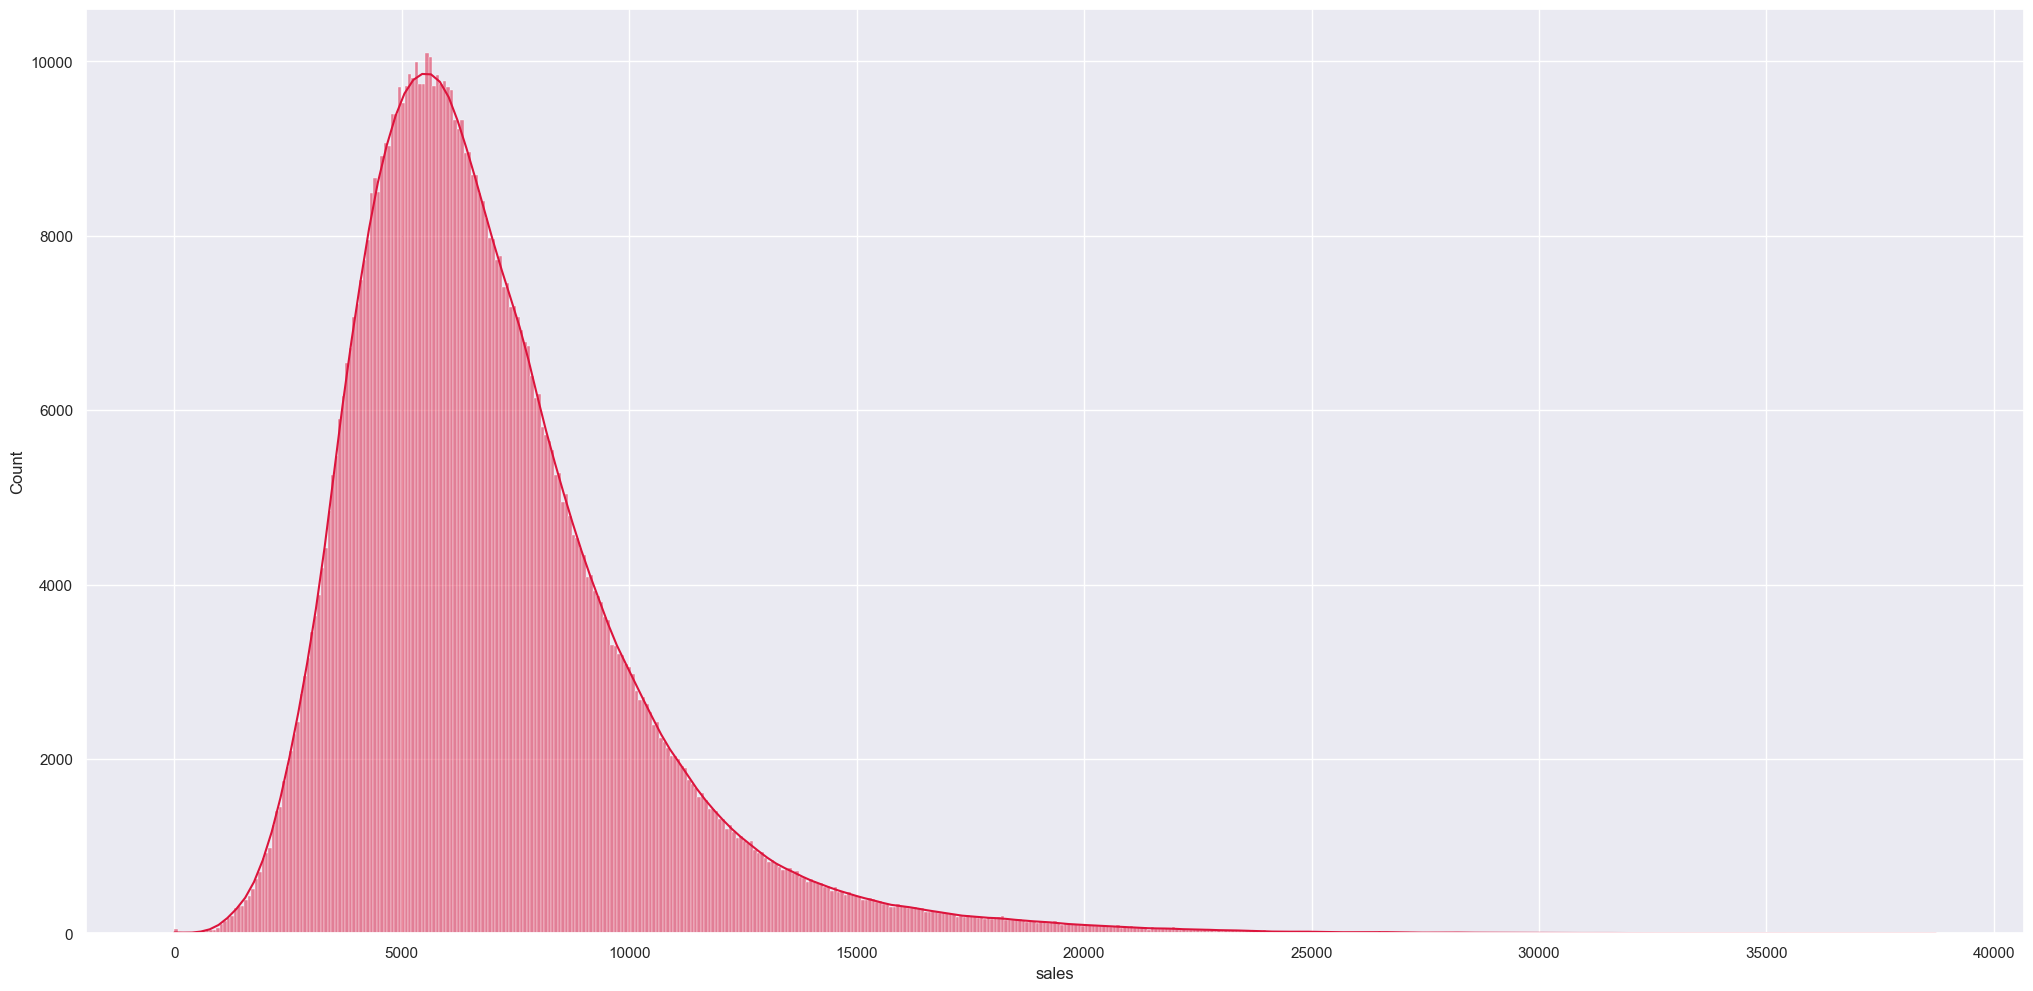

In [63]:
sns.histplot(data=df3, x='sales', kde=True, color='crimson');

<span style="color:magenta"> **FAZER A TRANSFORMAÇÃO LOGARÍTMICA PARA QUE A CURVA FIQUE MAIS PRÓXIMA DA NORMAL.** </span>

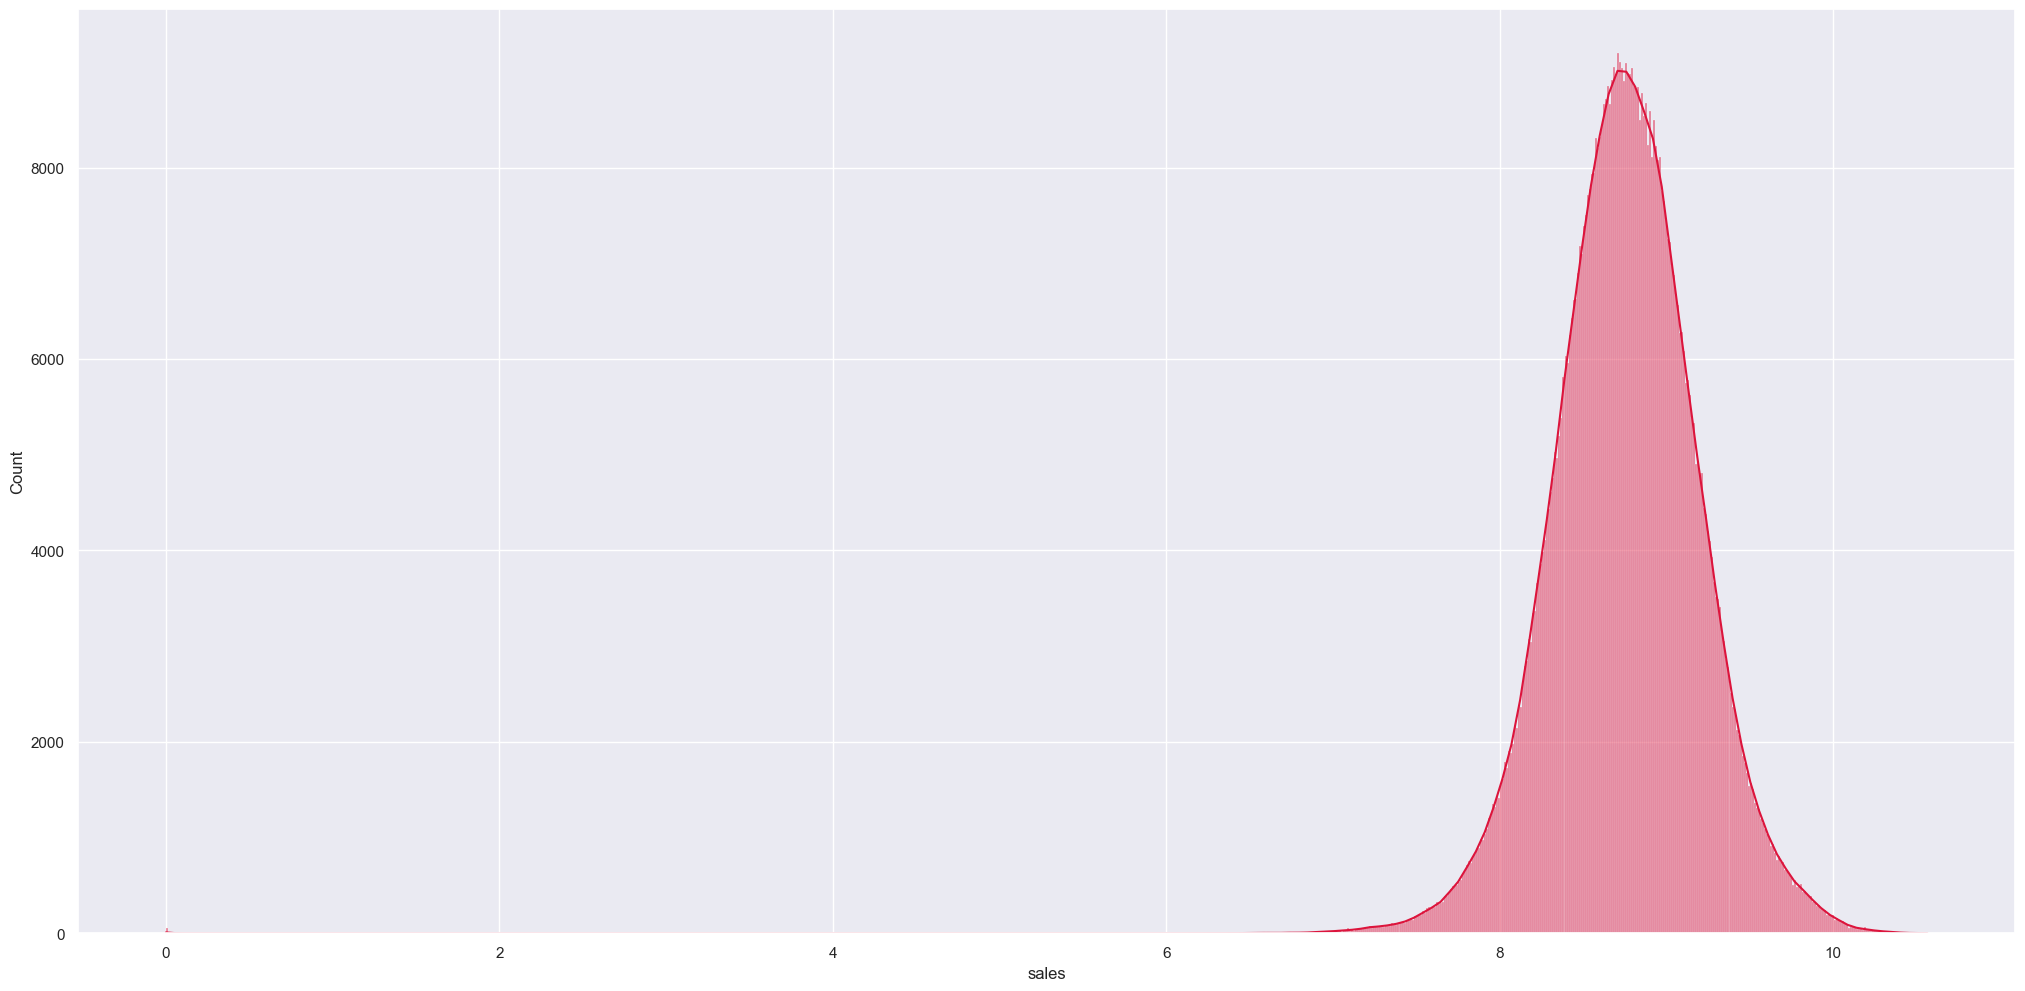

In [29]:
# simulação
aux = np.log1p(df3['sales']).reset_index()

sns.histplot(data=aux, x='sales', kde=True, color='crimson');

### 3.1.2 Variáveis Numéricas

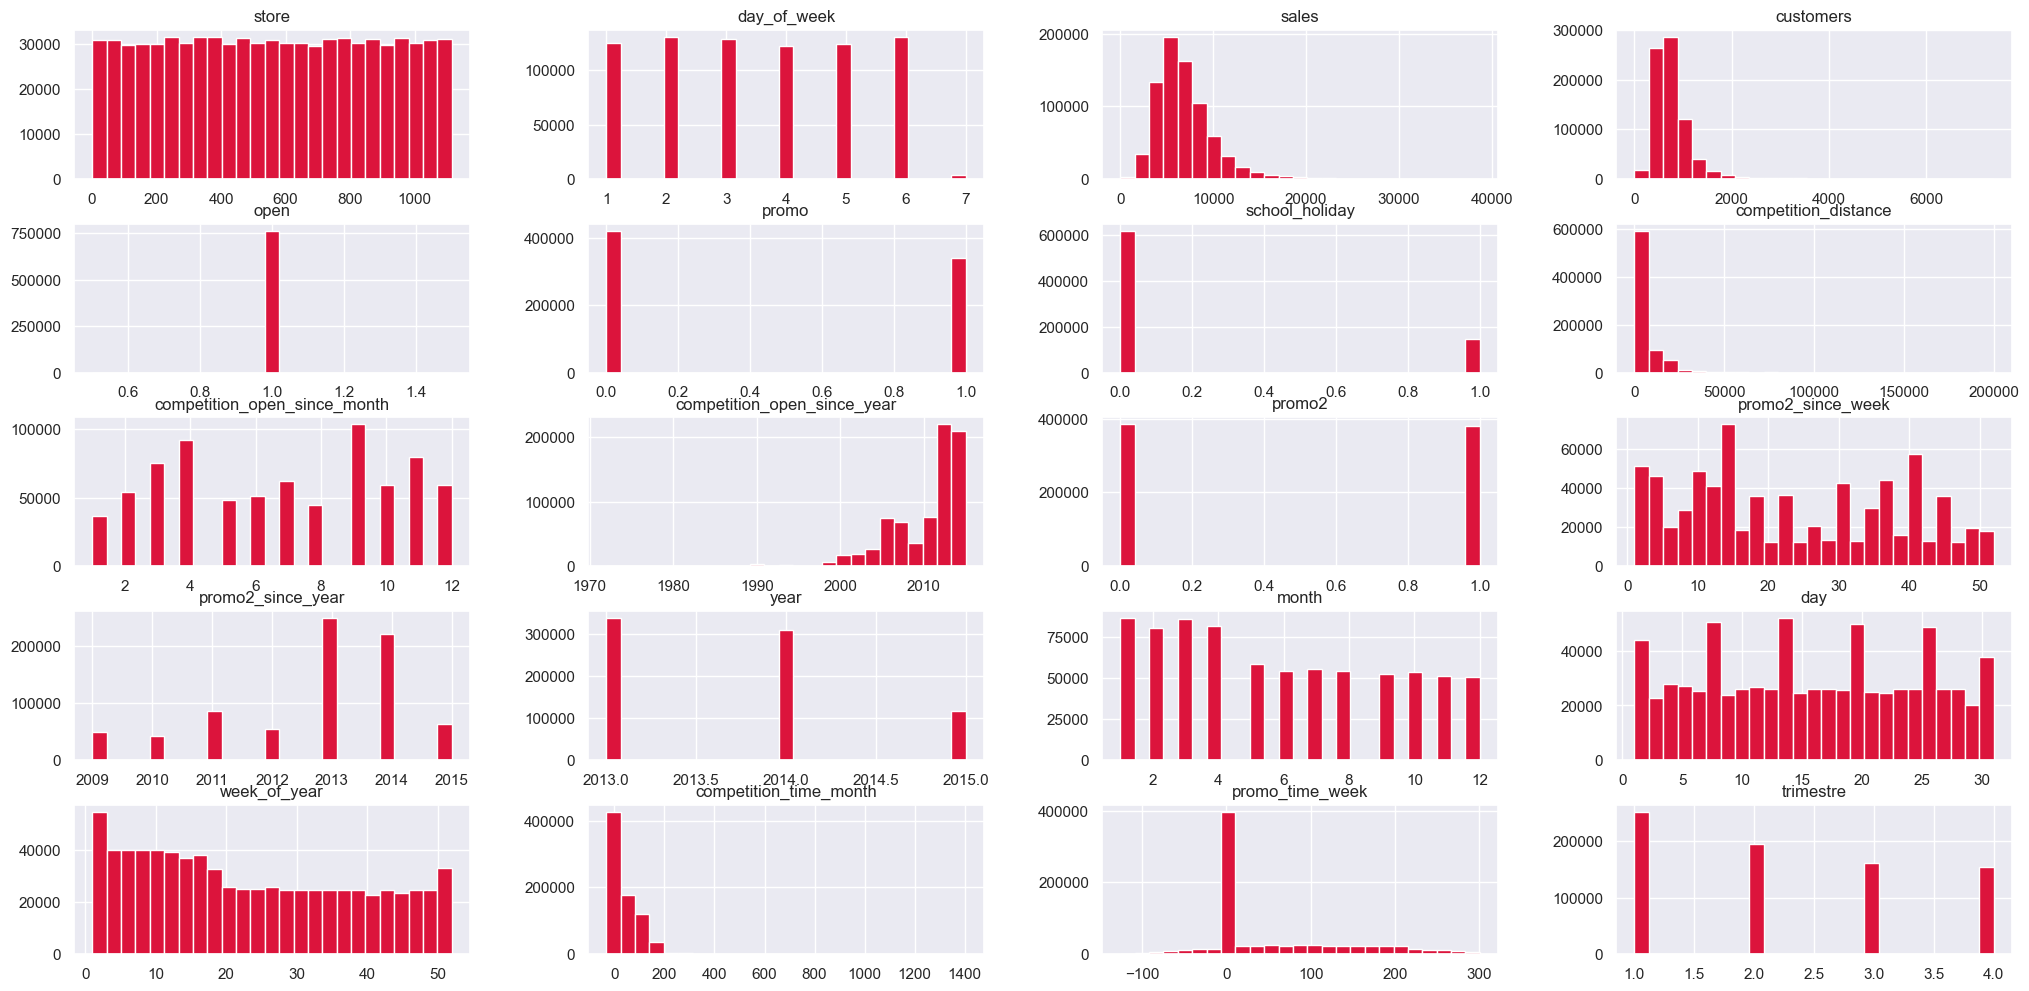

In [64]:
num_attributes = df3.select_dtypes(include = ('int64', 'float64'))

num_attributes.hist(bins=25, color='crimson');

### 3.1.3 Variáveis Categóricas

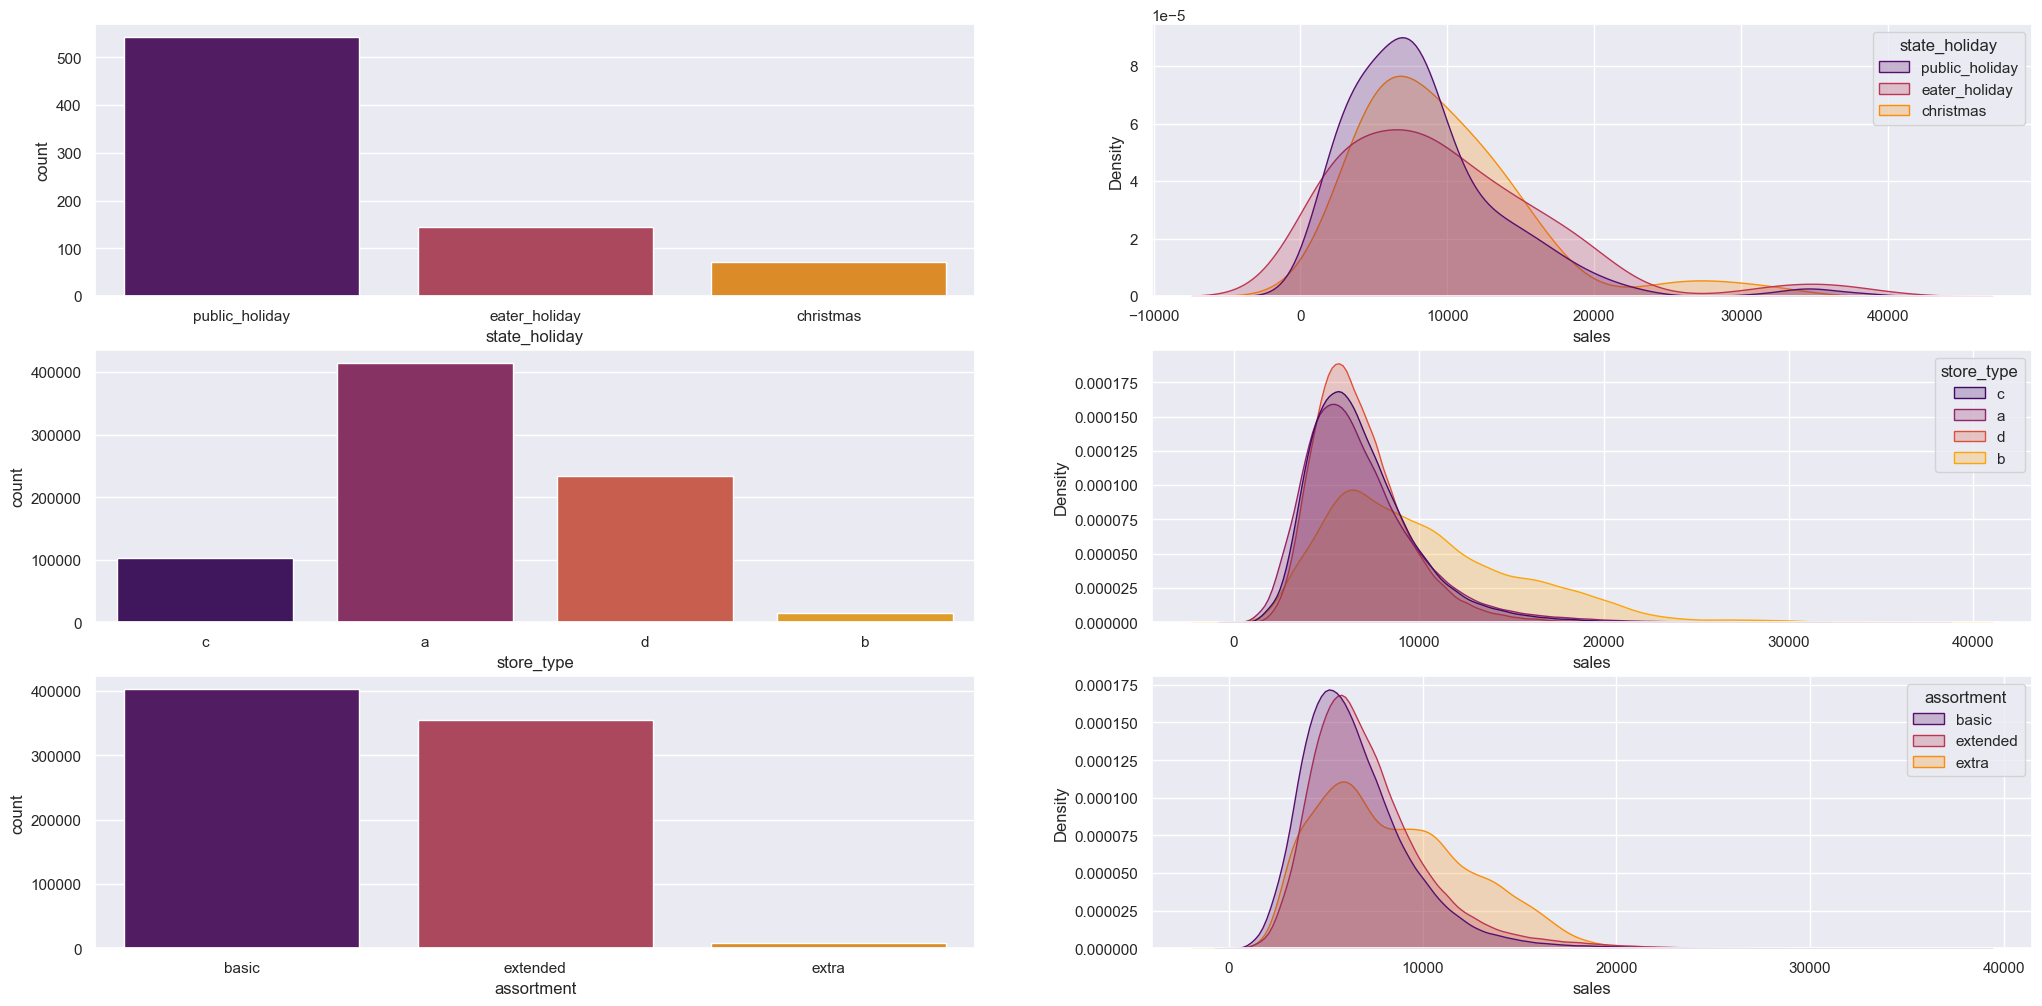

In [31]:
# state_holiday
plt.subplot( 3, 2, 1)
not_regular_day = df3[df3['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', data = not_regular_day, palette='inferno')

plt.subplot( 3, 2, 2)
sns.kdeplot( data=not_regular_day, x='sales', hue='state_holiday', fill=True,common_norm=False, palette='inferno')

# store_type
plt.subplot( 3, 2, 3)
sns.countplot(x='store_type', data = df3, palette='inferno')

plt.subplot( 3, 2, 4)
sns.kdeplot( data=df3, x='sales', hue='store_type', fill=True,common_norm=False, palette='inferno')

# assortment
plt.subplot( 3, 2, 5)
sns.countplot(x='assortment', data = df3, palette='inferno')

plt.subplot( 3, 2, 6)
sns.kdeplot( data=df3, x='sales', hue='assortment', fill=True,common_norm=False, palette='inferno');

## 3.2 Bivariada
##### <span style="color:magenta"> com base nas hipóteses levantadas </span>

### <span style="color:lightgreen">H1 - Em média, dias da semana influenciam nas vendas - mais que os finais de semana? </spam>

Conclusão: Apesar de domingo ter a maior média de vendas, quando agrupados, os dias da semana tem média maior que finais de semana.

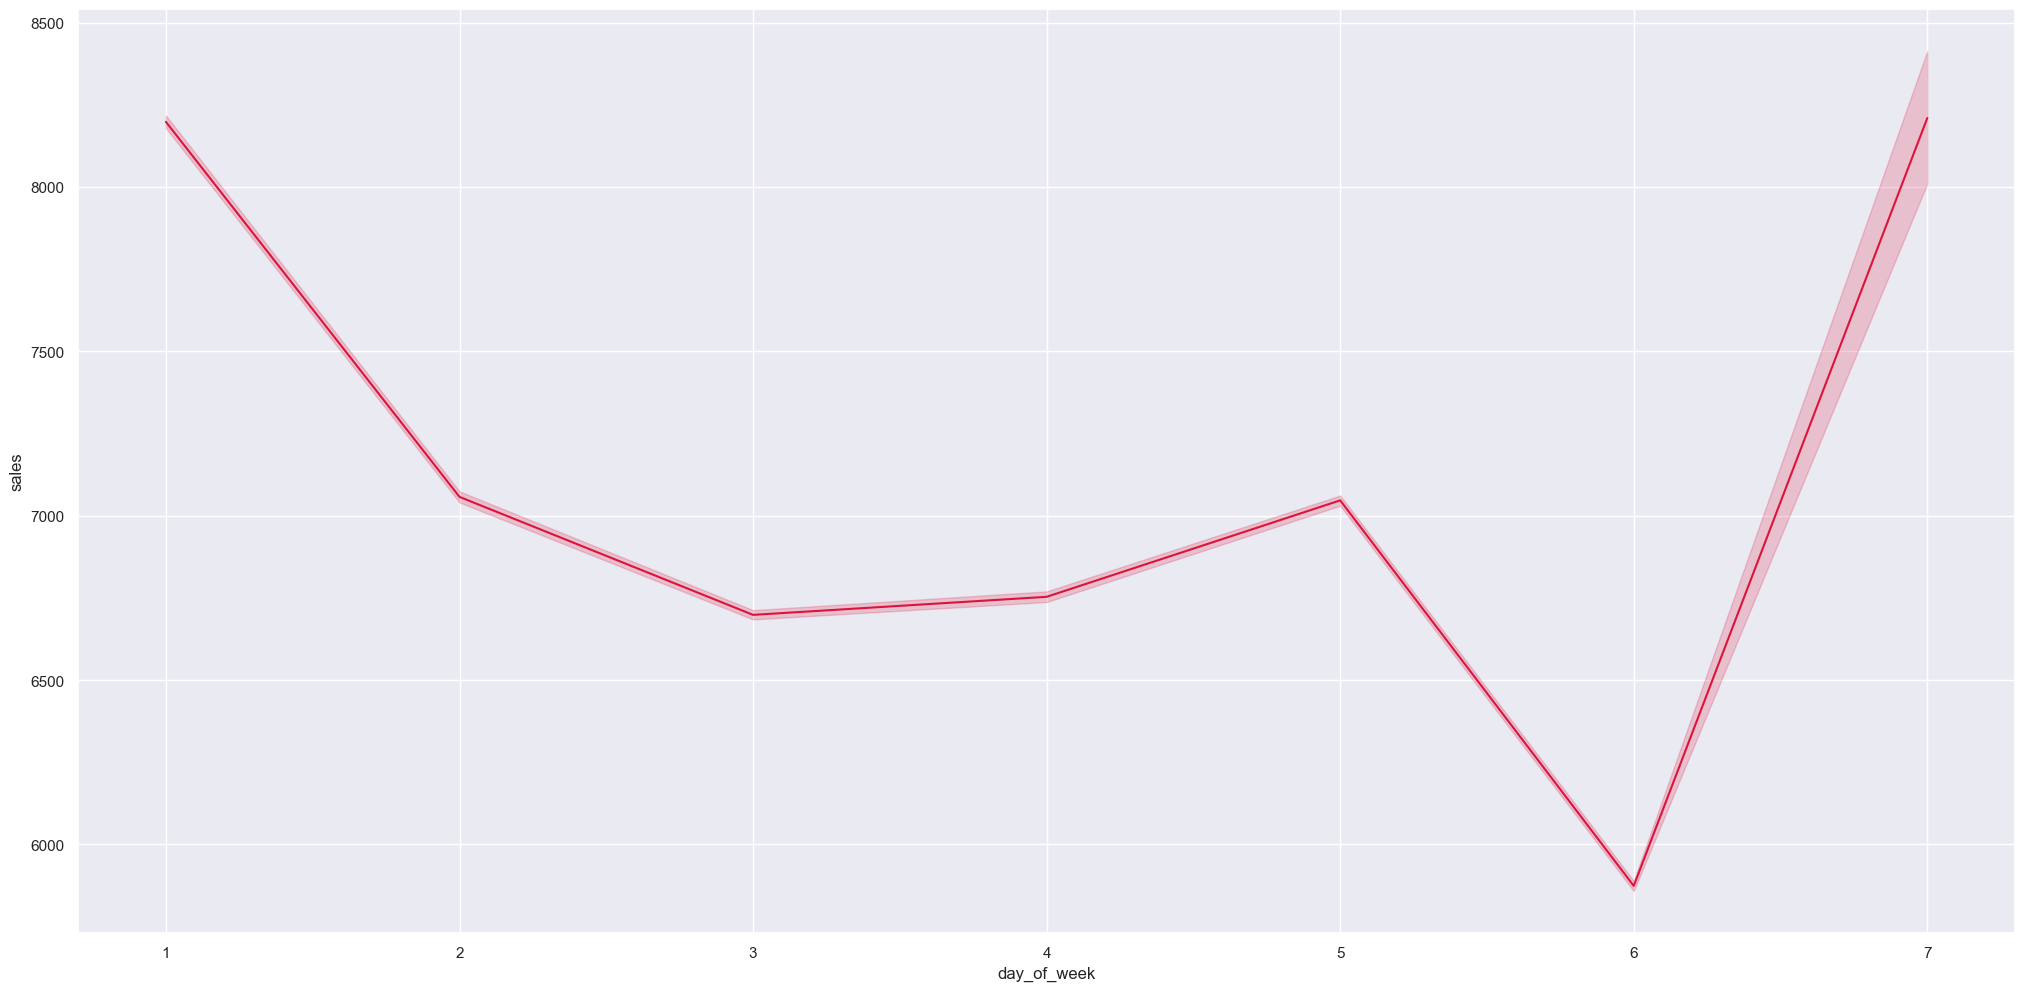

In [32]:
aux = df3[['day_of_week', 'sales', 'customers']].groupby('day_of_week')\
                                                .mean()\
                                                .sort_values('day_of_week', ascending=True)\
                                                .round(2).reset_index()
sns.lineplot(data=df3, x='day_of_week', y='sales', color='crimson');

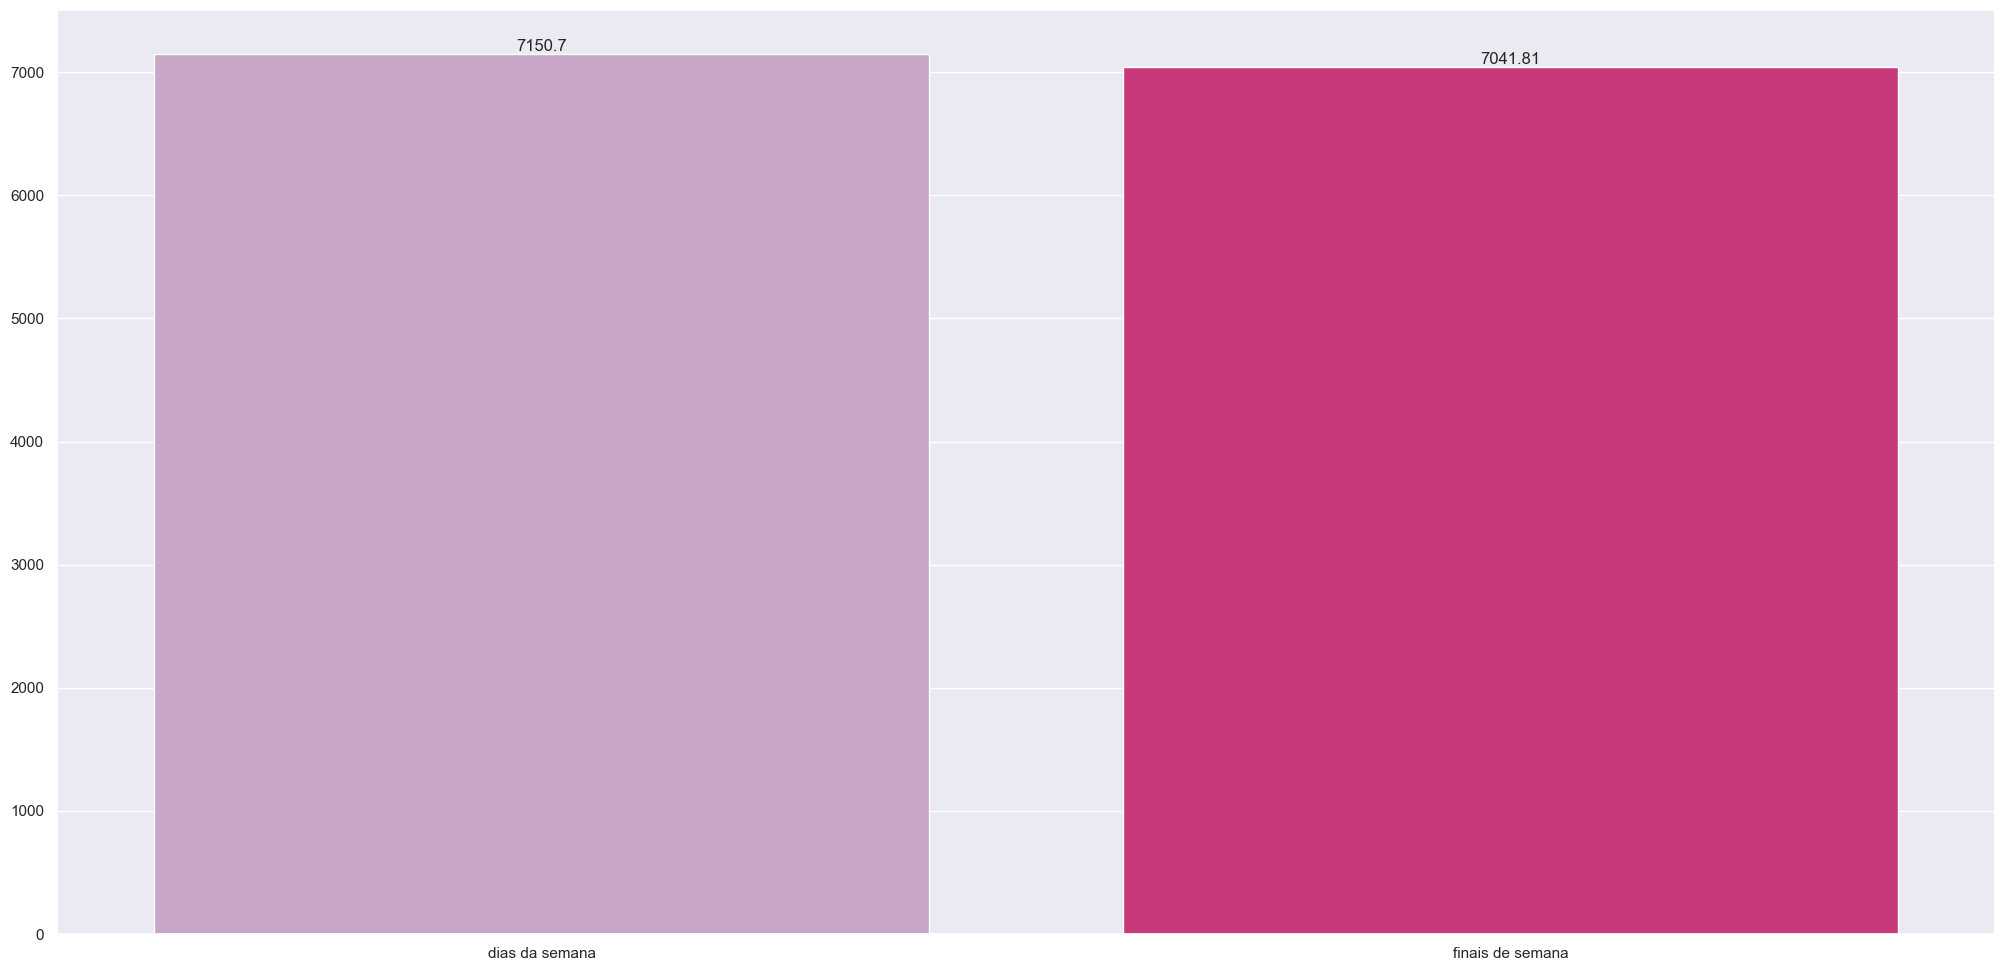

In [33]:
semana = aux.loc[aux.day_of_week <=5, 'sales'].mean()
fds = aux.loc[aux.day_of_week > 5, 'sales'].mean()

ax = sns.barplot(data=None, x=['dias da semana', 'finais de semana'], y=[semana, fds], palette='PuRd' );
plt.bar_label(ax.containers[0])
plt.show()

### <span style='color:lightgreen'> H2 - Quanto maior o número de customers, maior o número de sales? </span>

Conclusão: A hipótese é verdadeira, e ela tem uma correlação linear é de 0,83 (em média quando Sales tem acrescimo de 1, o Customer tem acrescimo de 0,83)

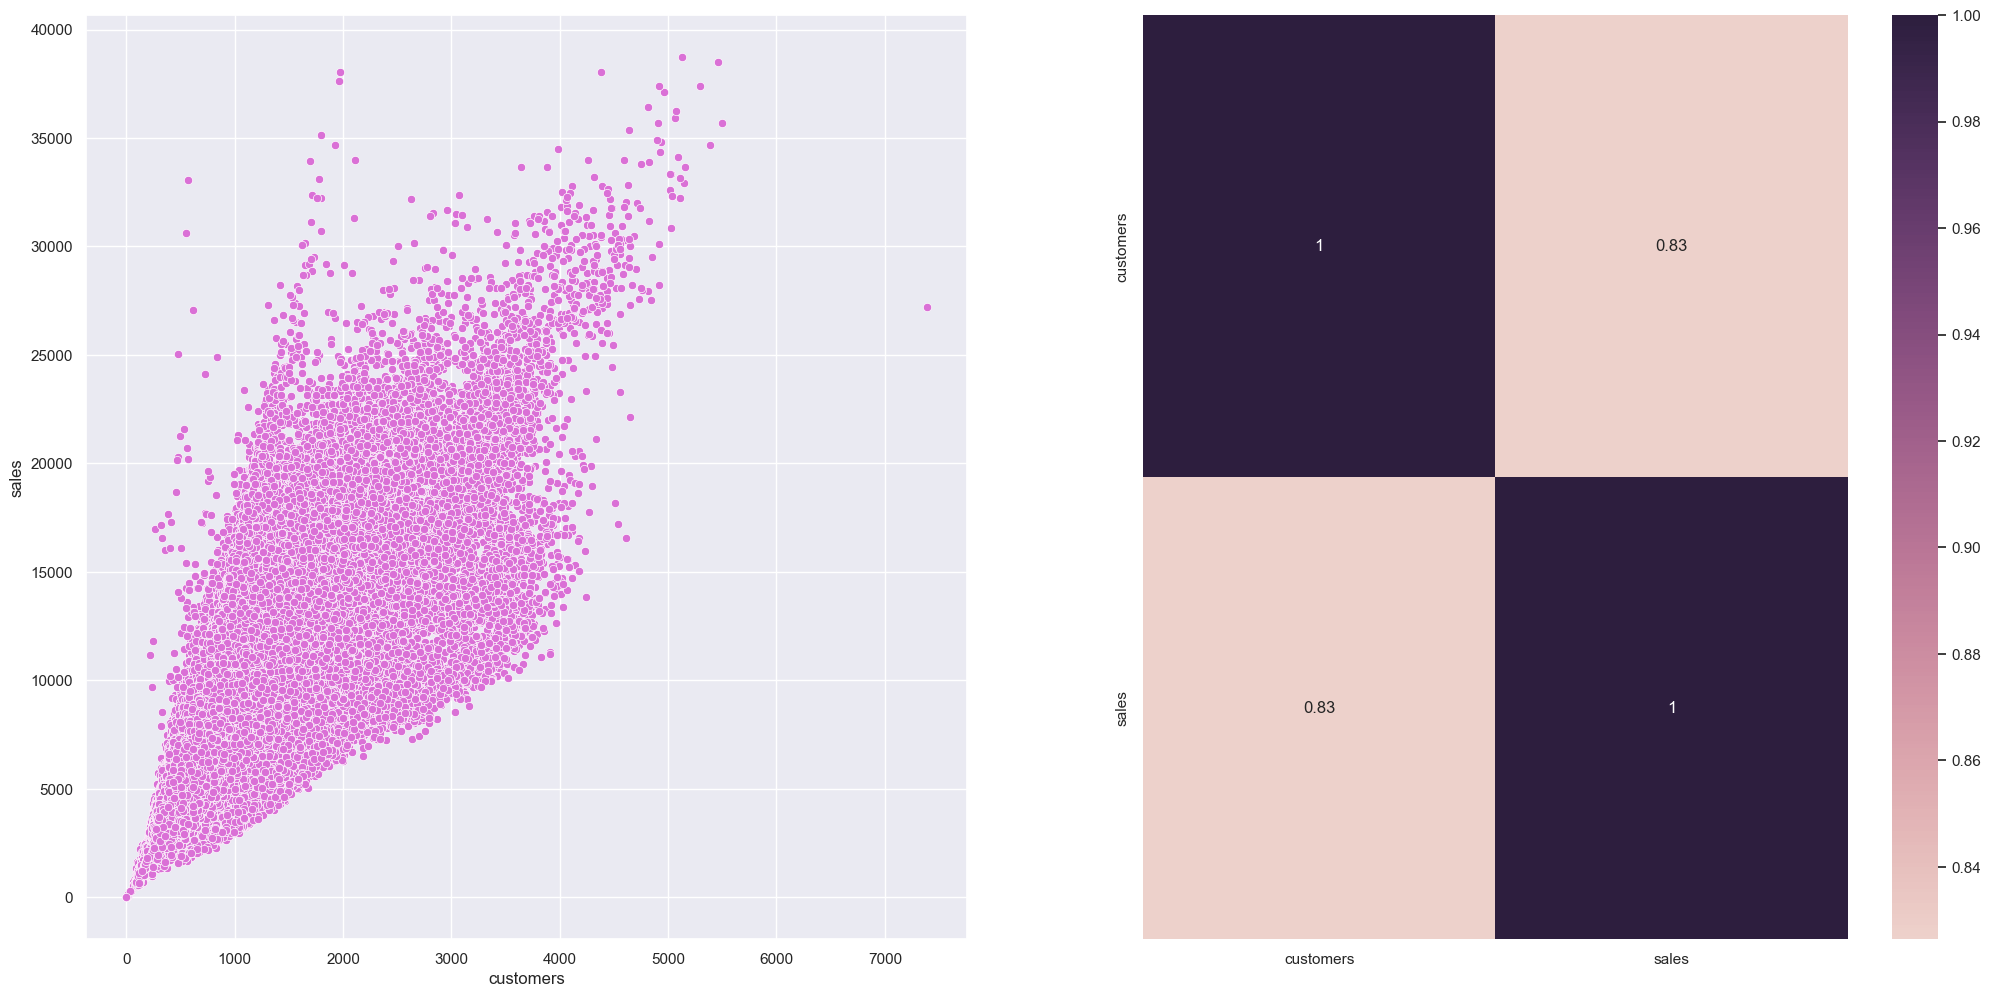

In [34]:
plt.subplot( 1, 2, 1)
sns.scatterplot(data=df3, x='customers', y='sales', color='orchid');

plt.subplot( 1, 2, 2)
ax = df3[['customers', 'sales']].corr(method='pearson')
sns.heatmap(data=ax, annot=True, cmap=sns.cubehelix_palette(as_cmap=True) );

### <span style='color:lightgreen'> H3 - Períodos com promoção vendem mais que períodos normais? </span>

Conclusão: Hipótese é verdadeira

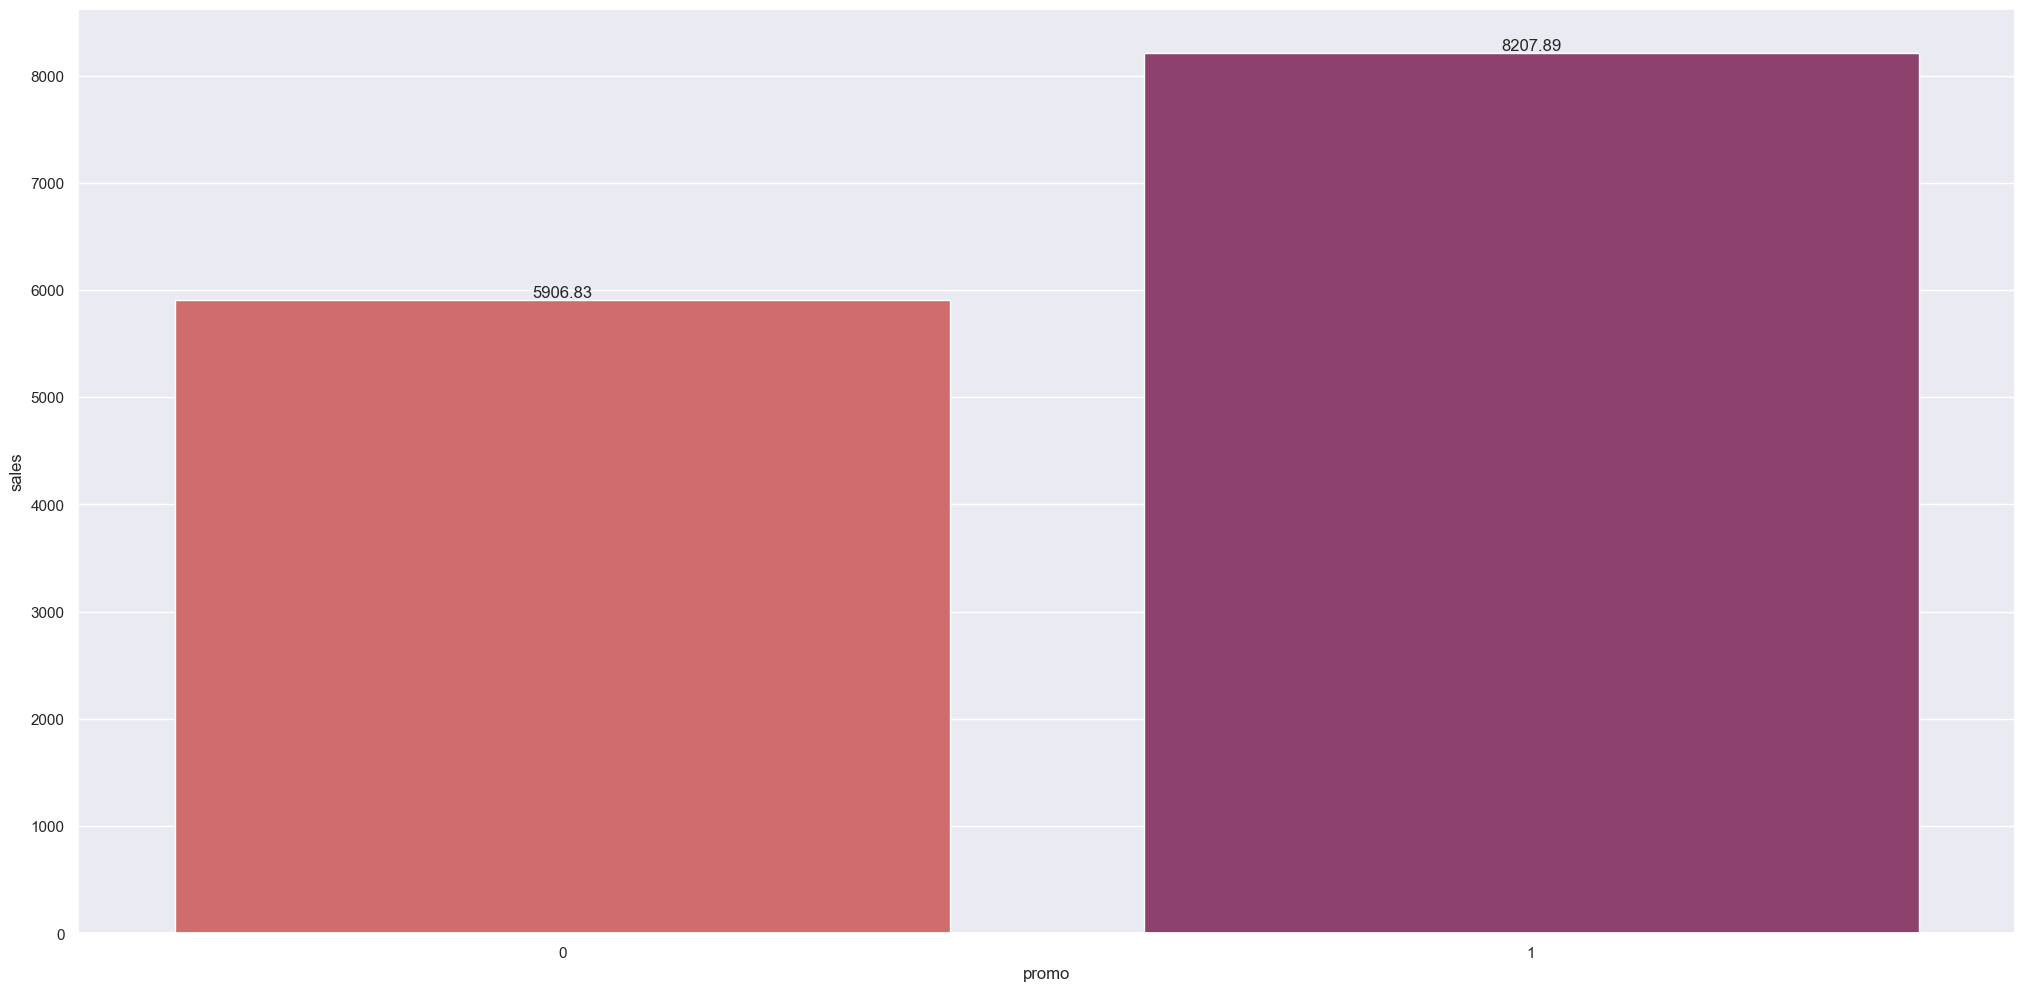

In [35]:
aux = df3[['promo', 'sales']].groupby('promo').mean().round(2).reset_index()
ax = sns.barplot(data=aux, x='promo', y='sales', palette='flare' );
plt.bar_label(ax.containers[0])
plt.show()

### <span style="color:#F52528"> H4 - Lojas com promoção e liquidação vendem mais? </span>


Conclusão: A hipotese é falsa, uma vez que lojas que tem somente promoção vendem mais.

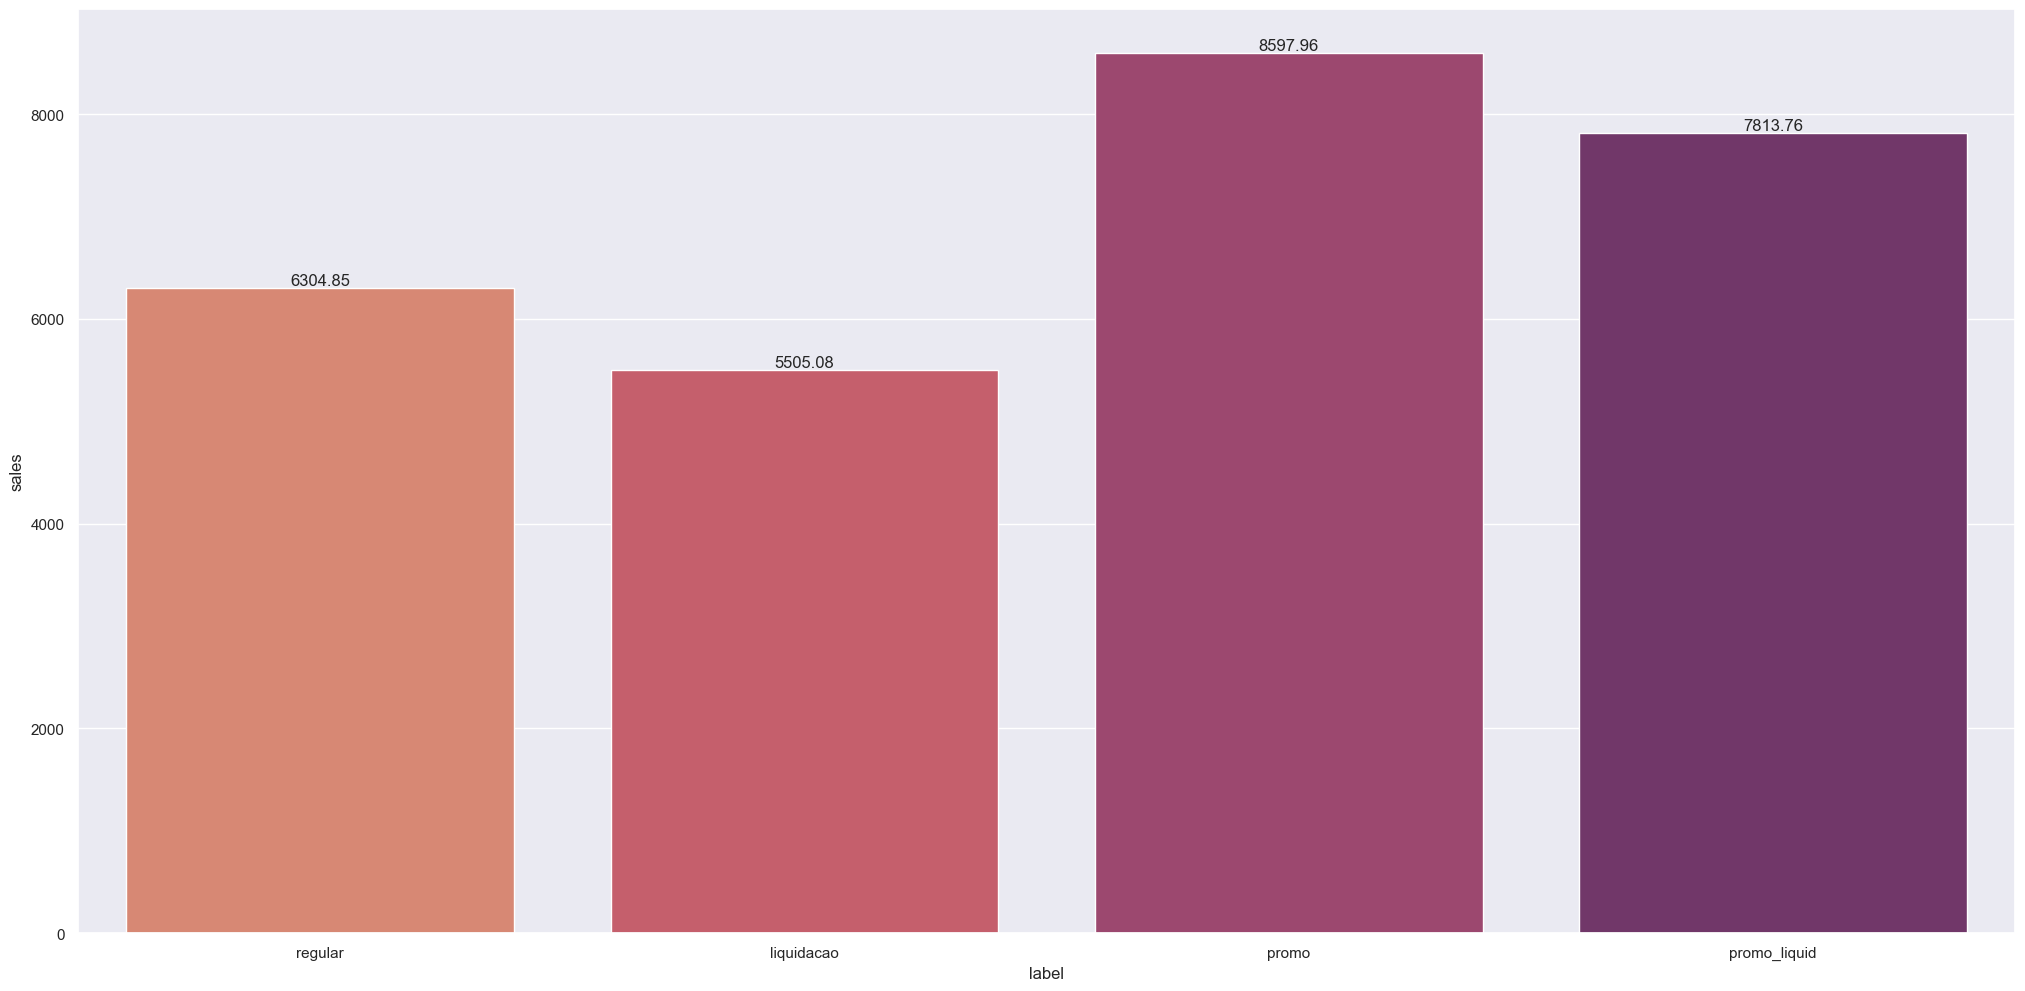

In [36]:
aux = df3[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).mean().round(2).reset_index()
aux['label'] = ['regular', 'liquidacao', 'promo', 'promo_liquid']
aux
ax = sns.barplot(data=aux, x='label', y='sales', palette='flare' );
plt.bar_label(ax.containers[0])
plt.show()



### <span style='color:lightgreen'> H5 - Em feriados as lojas tendem a vender menos. </span>

Conclusão: Hipótese verdadeira, em média nos feriado as lojas vendem muito menos do que em dias normais

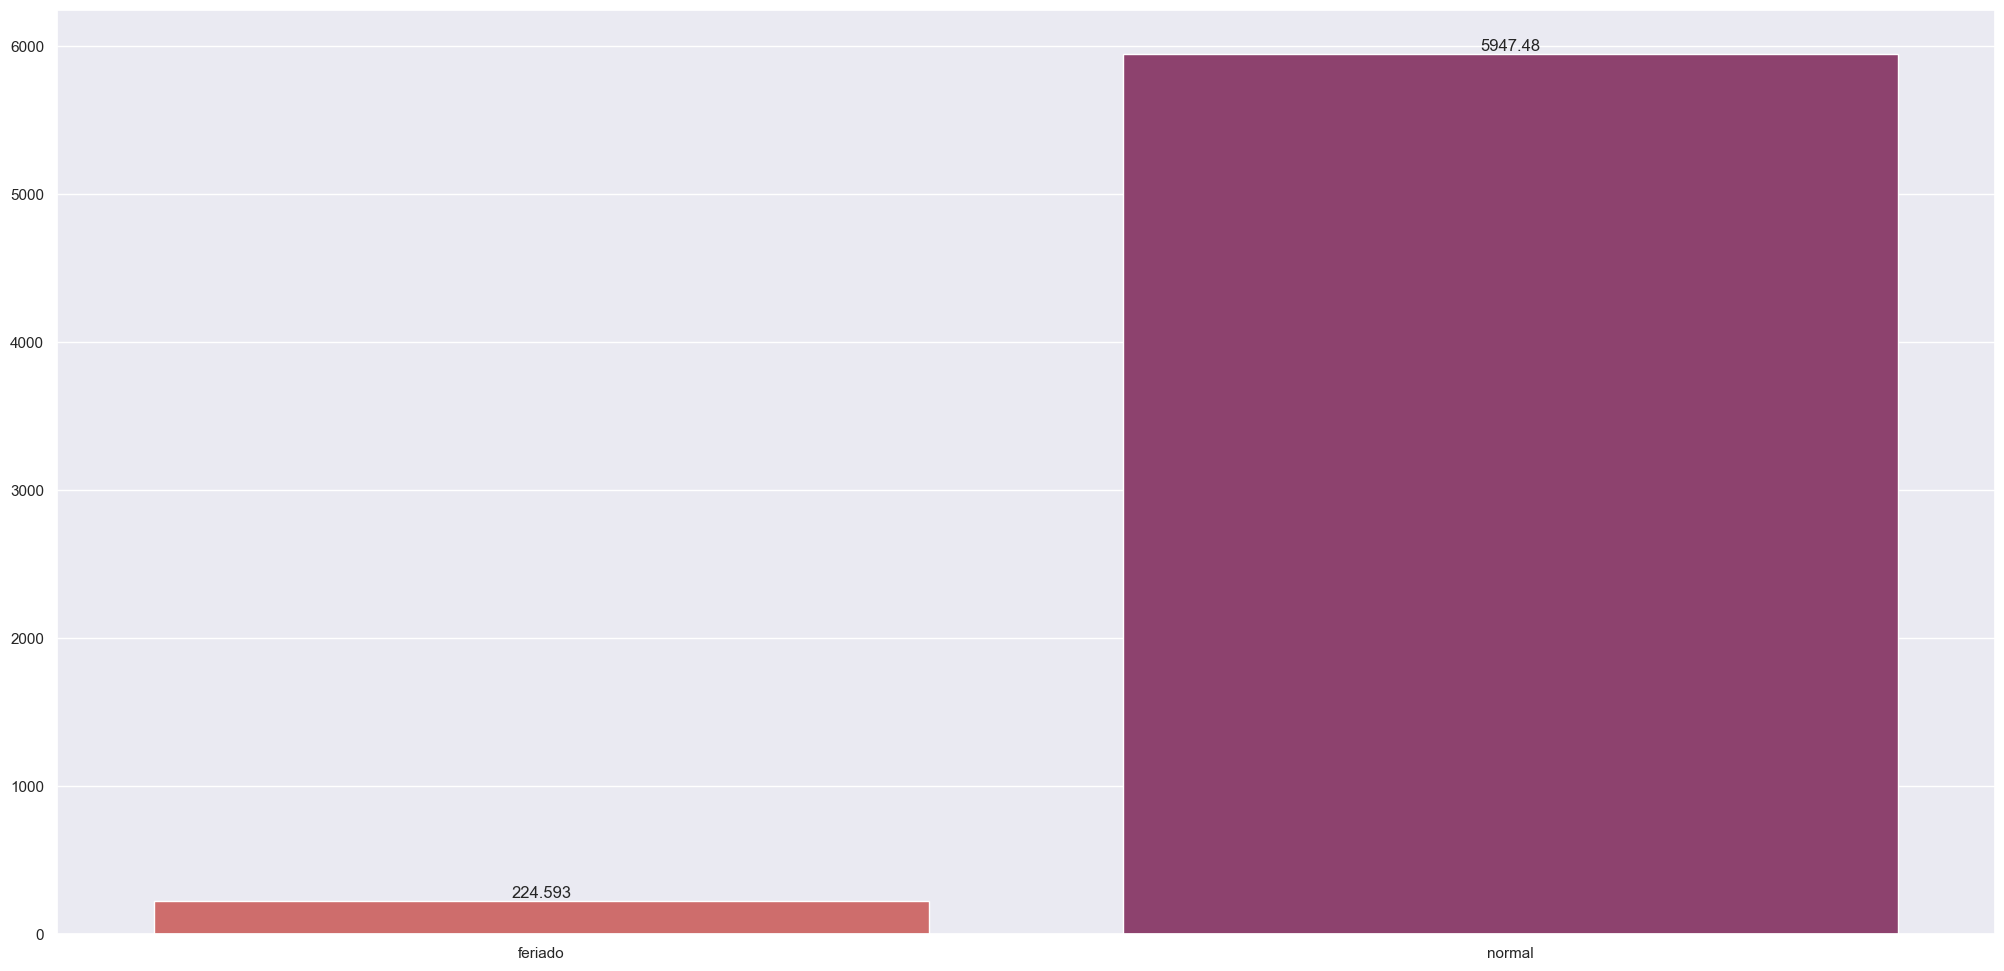

In [37]:
aux = df[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
feriado = aux.loc[aux['state_holiday'] != '0', 'sales'].mean()
normal = aux.loc[aux['state_holiday'] == '0', 'sales']

ax = sns.barplot(data= None, x=['feriado', 'normal'], y=[feriado, normal[0]], palette='flare' );
plt.bar_label(ax.containers[0])
plt.show()

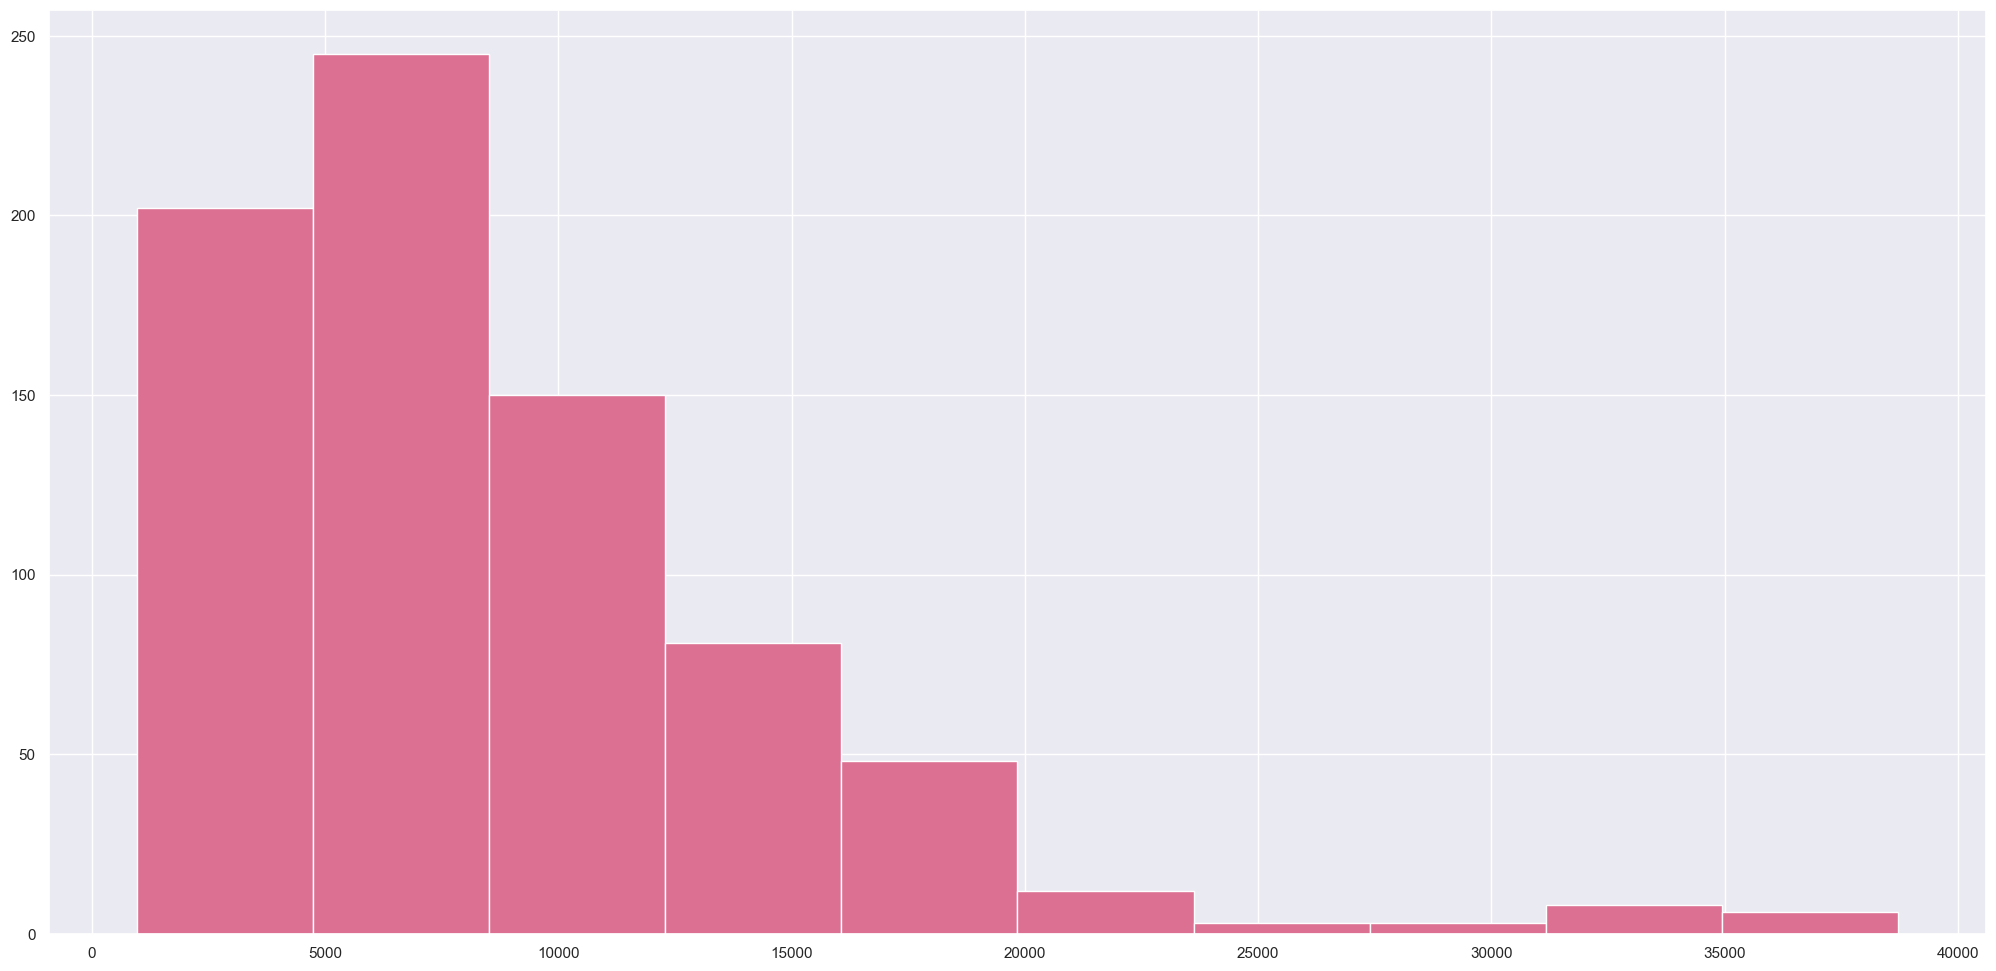

In [38]:
# Distribuição das vendas durante os feriados'
df3.loc[df3.state_holiday != 'regular_day', 'sales'].hist(color='palevioletred');

### <span style='color:#F52528'> H6 - No período de férias escolares as lojas vendem menos </span>

Conclusão: Hipótese falsa, durante o período de ferias a media de vendas é maior

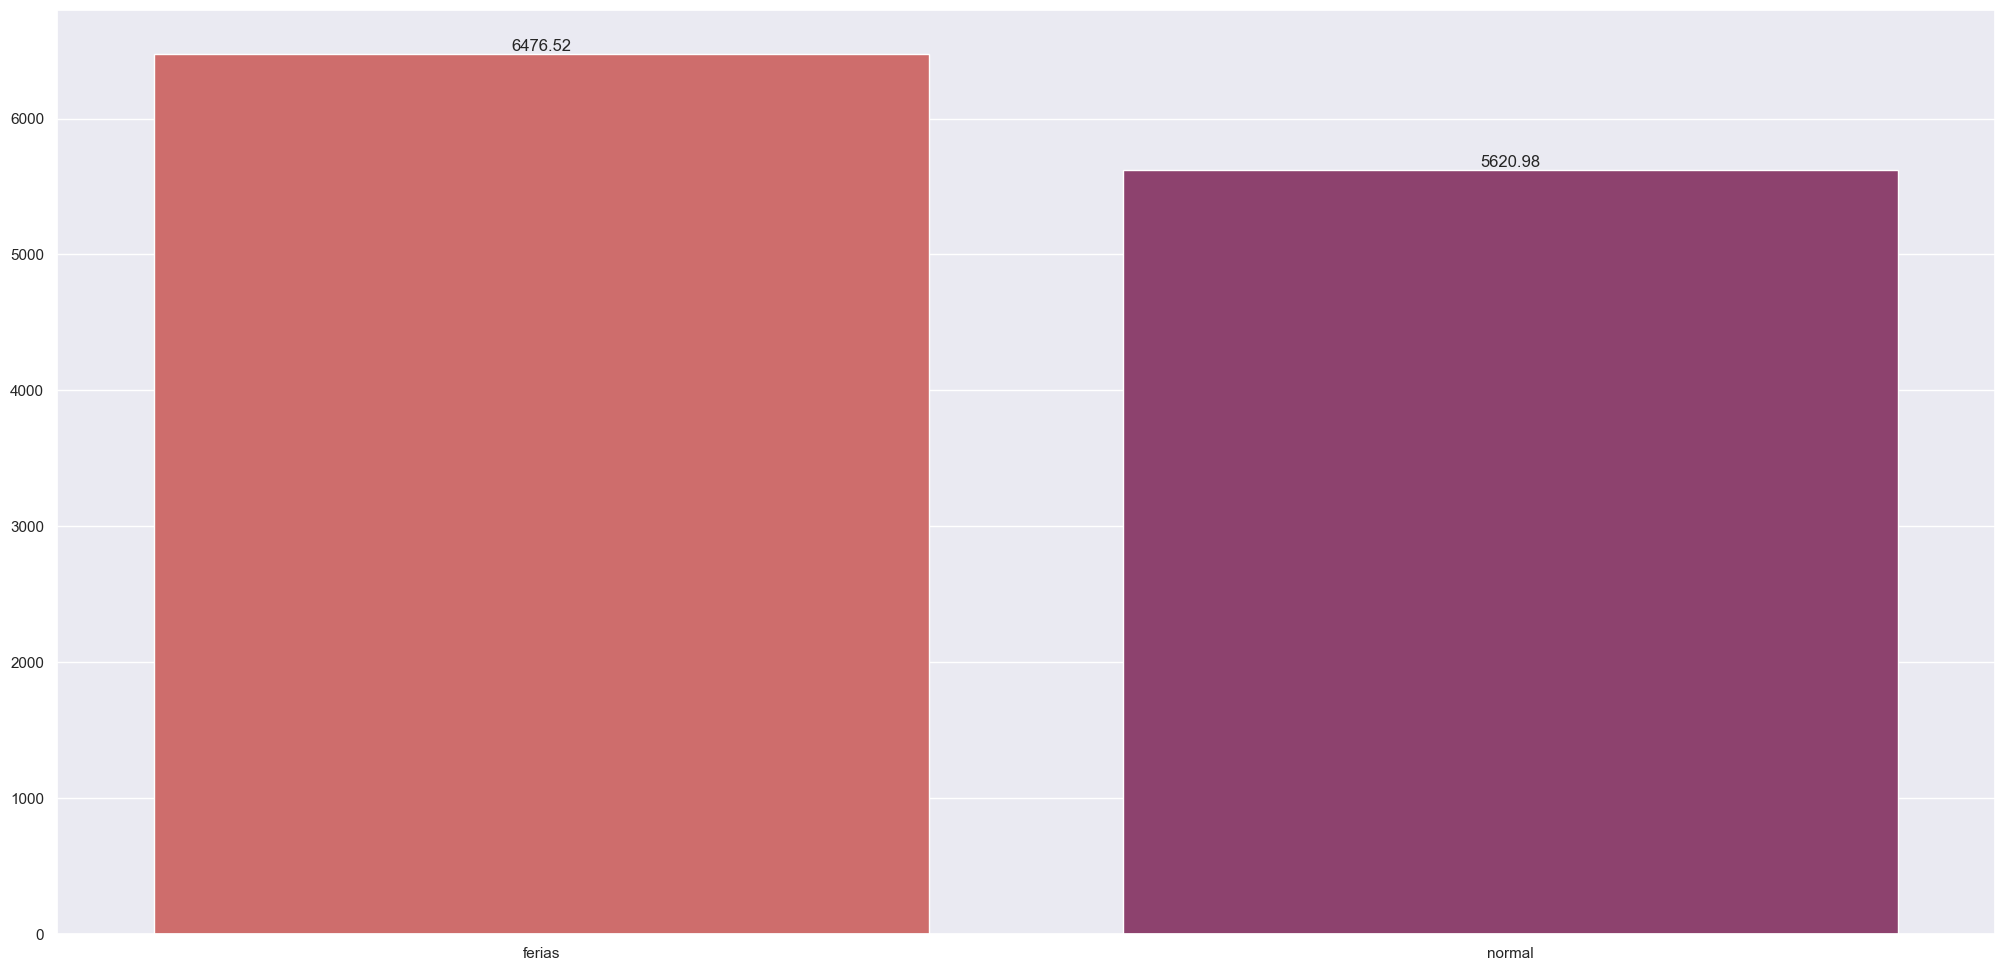

In [39]:
aux = df[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()
ferias = aux.loc[aux['school_holiday'] != 0, 'sales'].mean()
normal = aux.loc[aux['school_holiday'] == 0, 'sales']

ax = sns.barplot(data= None, x=['ferias', 'normal'], y=[ferias, normal[0]], palette='flare' );
plt.bar_label(ax.containers[0])
plt.show()

### <span style='color:#F52528'>H7 - O tipo de lojas "A" tem média de vendas maior. </span>

Conclusão: Hipótese falsa, a loja do tipo B, embora seja menor em quantidade de lojas, tem comportamento de venda melhor do que as outras

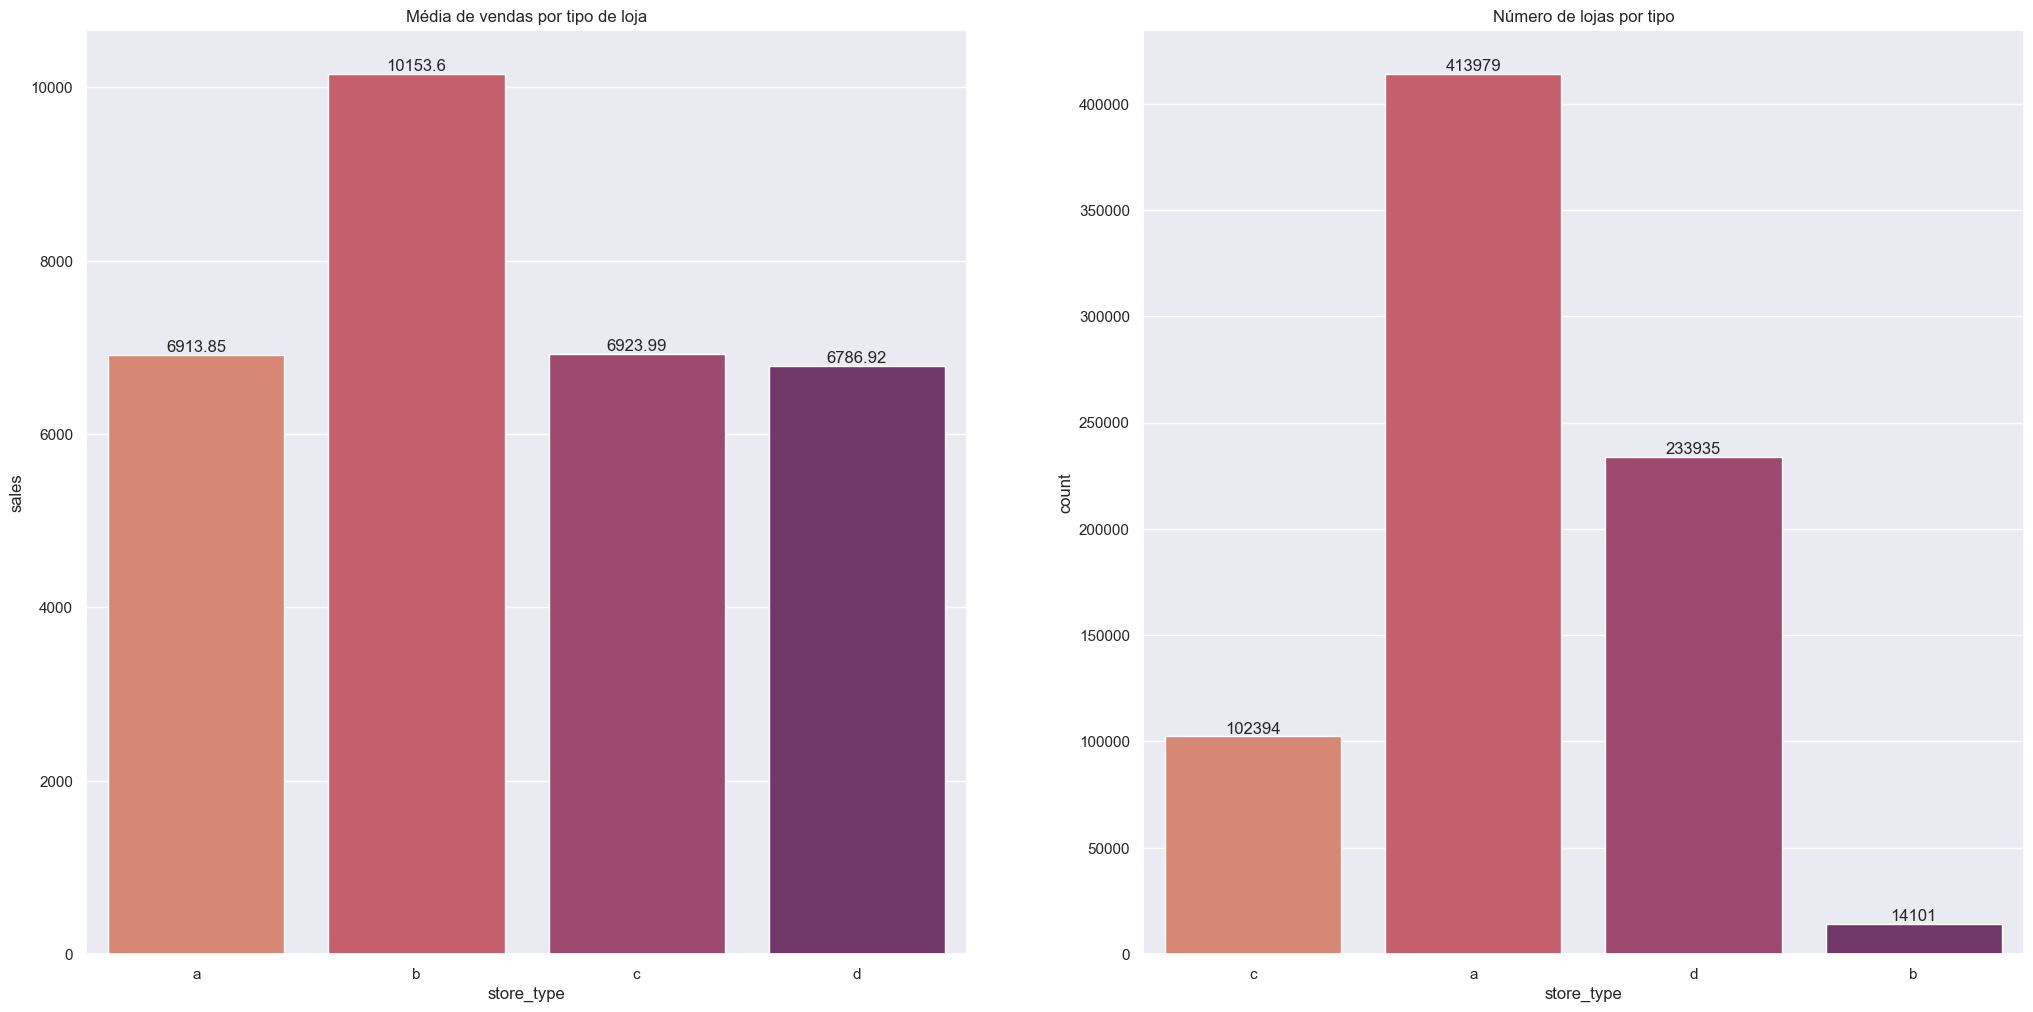

In [40]:
aux = df3[['store_type', 'sales']].groupby('store_type').mean().round(2).reset_index()

plt.subplot(1,2,1)
ax = sns.barplot(data=aux, x='store_type', y='sales', palette='flare' );
plt.bar_label(ax.containers[0]);
plt.title('Média de vendas por tipo de loja');



plt.subplot(1,2,2)
ax1 = sns.countplot(data=df3, x='store_type', palette='flare' );
plt.bar_label(ax1.containers[0]);
plt.title('Número de lojas por tipo');

### <span style="color:lightgreen">H8 - Quanto maior o assortment da loja maior a media de vendas?</span>

Conclusão: Apesar de existerem pouca lojas com assortment extra, elas tem performance melhor no quesito média de vendas.

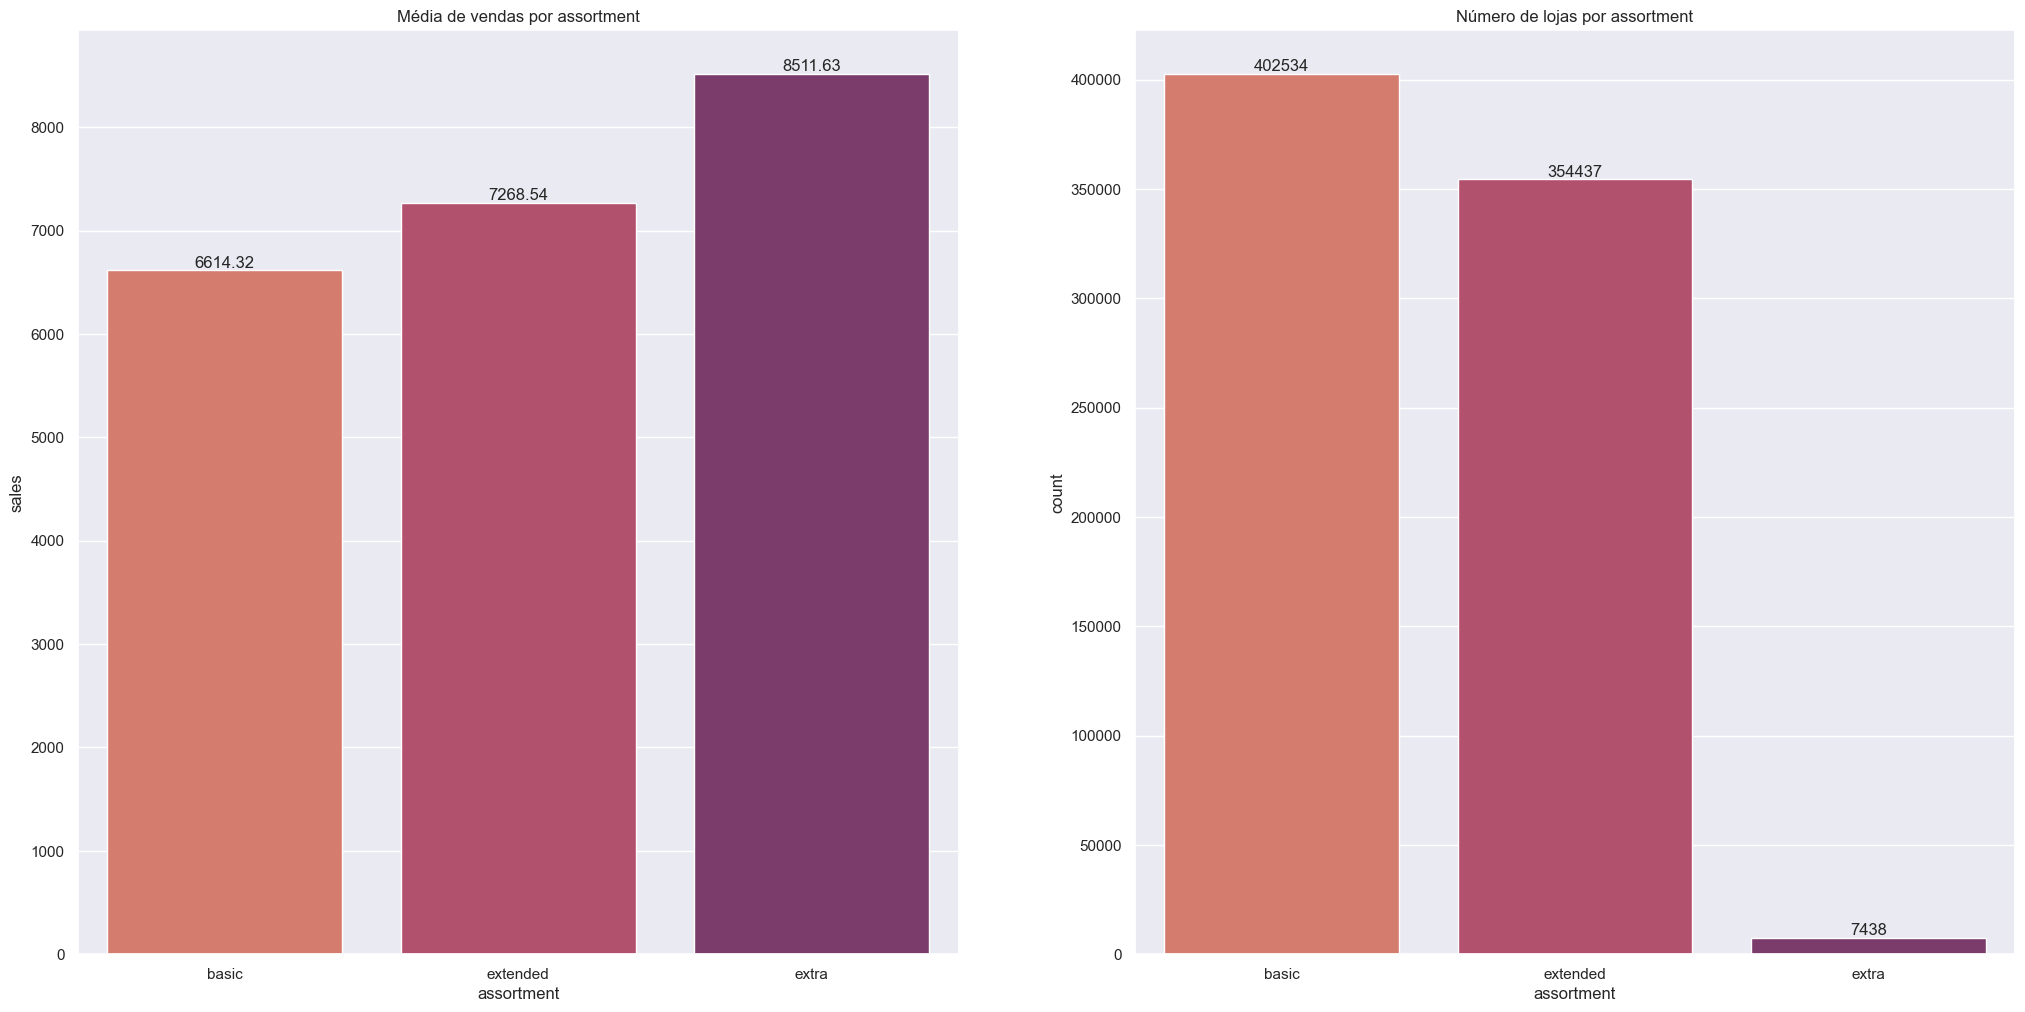

In [41]:
aux = df3[['assortment','sales']].groupby('assortment').mean().round(2).reset_index()
plt.subplot(1,2,1)
ax = sns.barplot(data=aux, x='assortment', y='sales', palette='flare' );
plt.bar_label(ax.containers[0])
plt.title('Média de vendas por assortment')


plt.subplot(1,2,2)
ax1 = sns.countplot(data=df3, x='assortment', palette='flare' );
plt.bar_label(ax1.containers[0]);
plt.title('Número de lojas por assortment');

### <span style='color:lightgreen'>H9 - O último trimestre de cada ano, tem comportamento crescente de vendas. </span>

Conclusão: Hipótese verdadeira

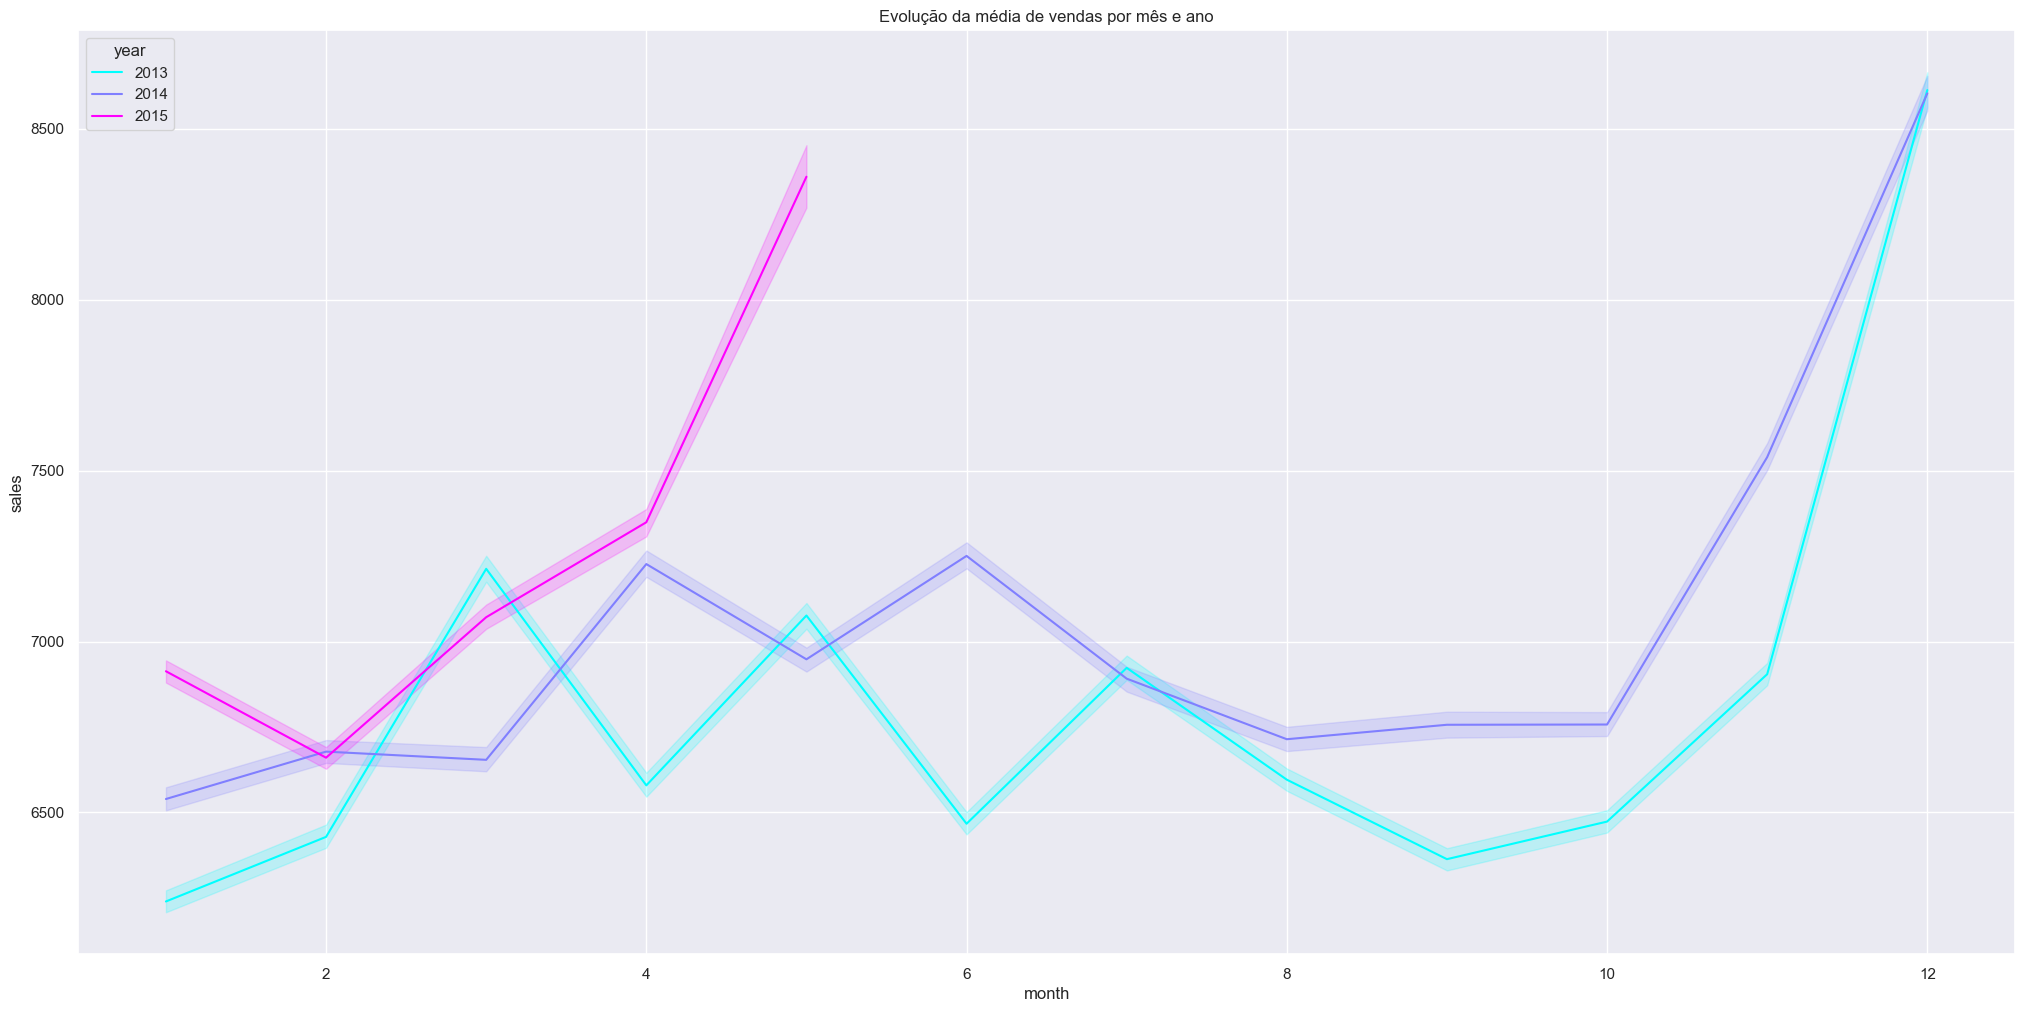

In [42]:
ax = sns.lineplot(data=df3, x='month', y='sales', hue='year', palette='cool');
plt.title('Evolução da média de vendas por mês e ano');

### <span style='color:lightblue'> H10 - Após os primeiros 5 dias do mês a média de vendas cai. </span>

Conclusão: Hipótese verdadeira. a tendencia de crescimento retorna após o 20 dia de cada mês.

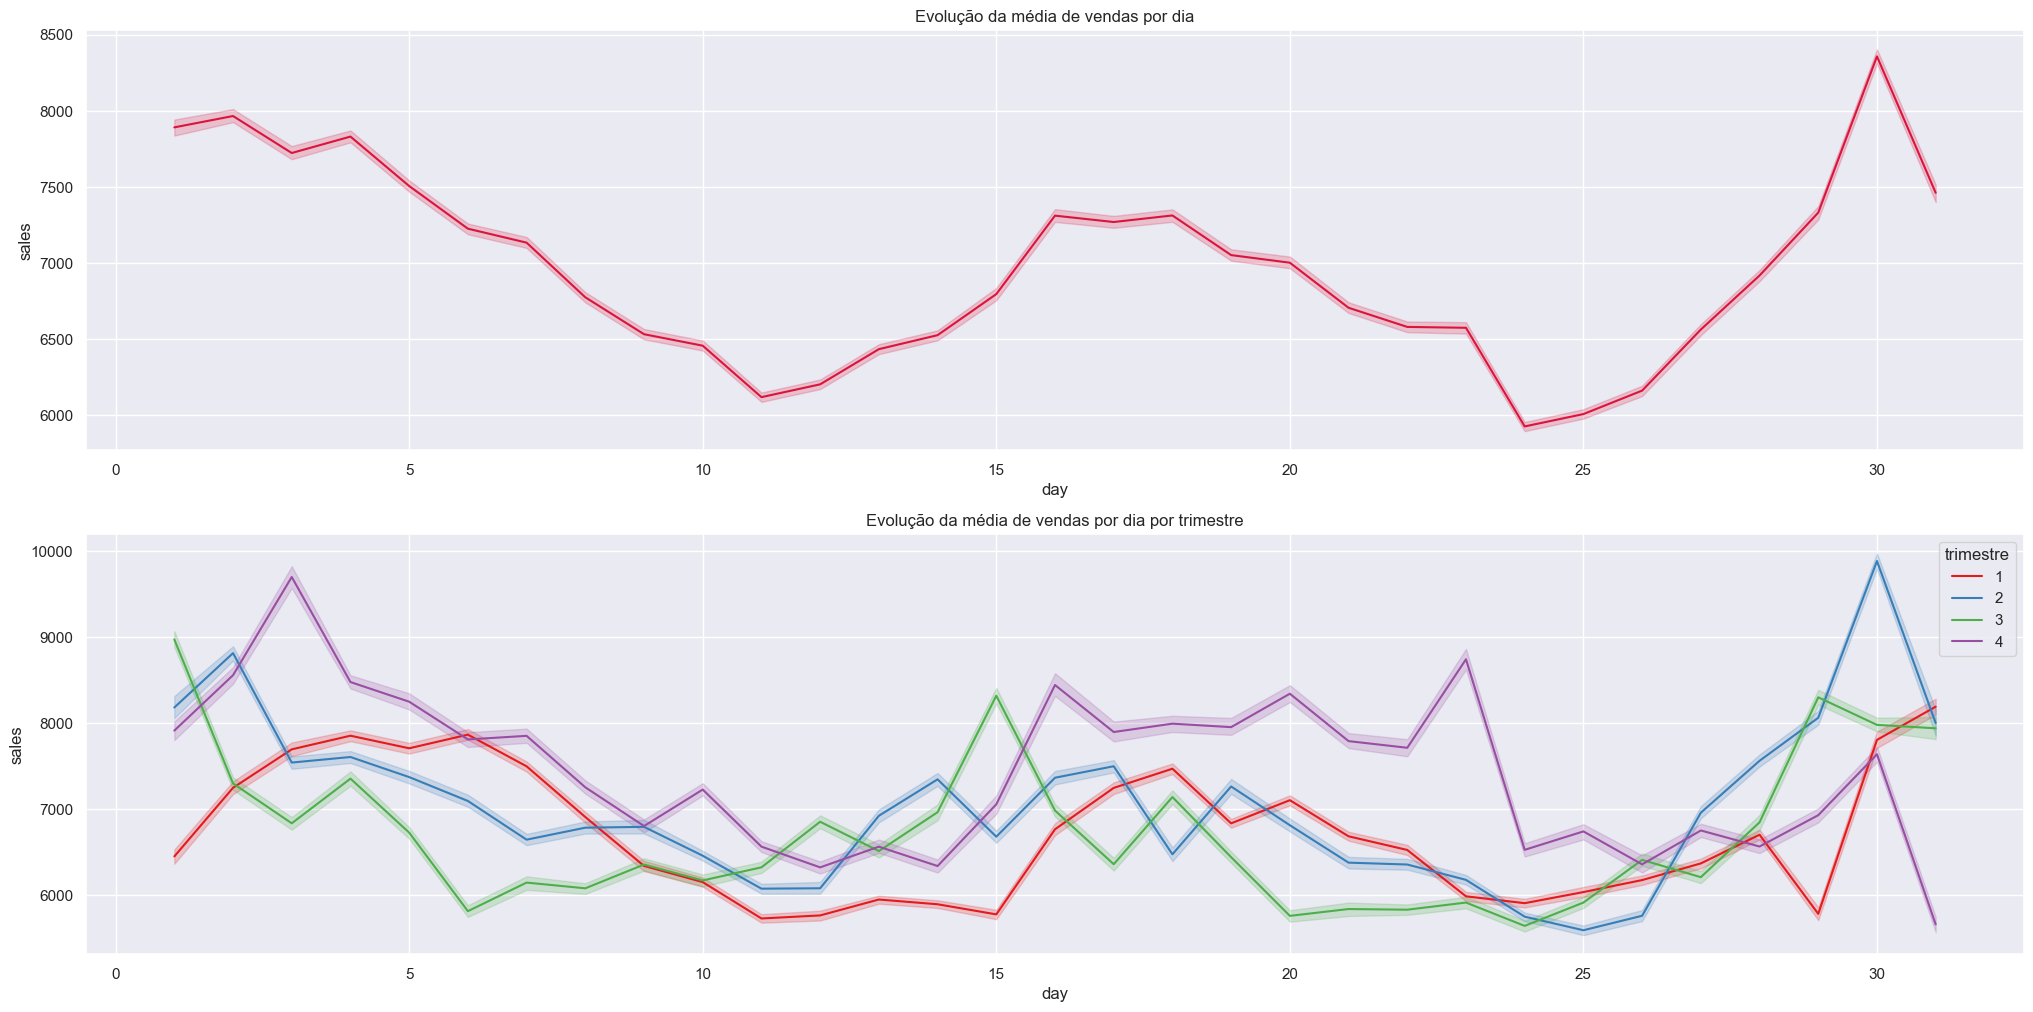

In [43]:
plt.subplot( 2, 1, 1 )
ax = sns.lineplot(data=df3, x='day', y='sales', color='crimson');
plt.title('Evolução da média de vendas por dia');

plt.subplot( 2, 1, 2 )
ax = sns.lineplot(data=df3, x='day', y='sales', hue='trimestre', palette='Set1');
plt.title('Evolução da média de vendas por dia por trimestre');

### <span style='color:#F52528'> H11 - Com competidores próximos, as lojas tendem a vender menos? </span>

Conclusão: Apesar de existirem algumas lojas com competidores próximos e média de vendas alta, não é possível afirmar que existe uma tendência, uma vez que a correlação é quase nula.

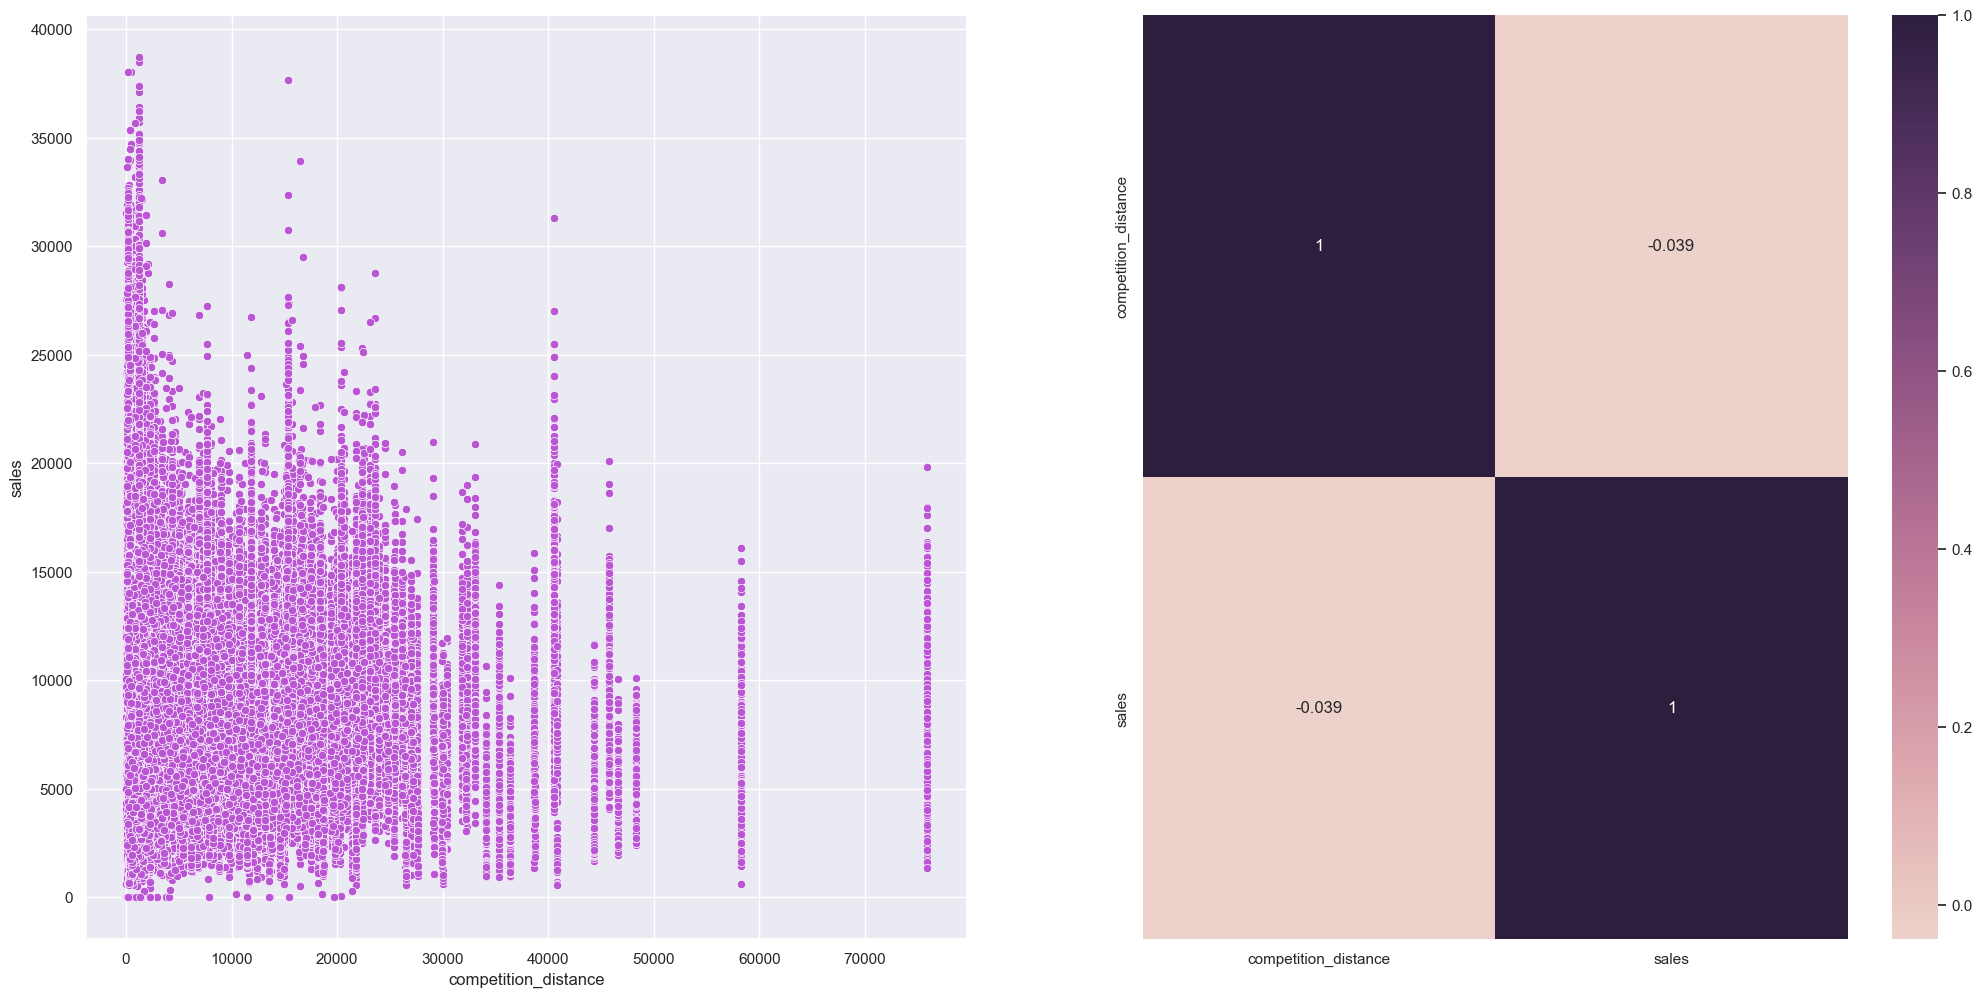

In [44]:
aux = df3.loc[df3.competition_distance < 100000]

plt.subplot(1,2,1)
sns.scatterplot(data=aux, x='competition_distance', y='sales', color='mediumorchid');

plt.subplot(1,2,2)
aux1 = aux[['competition_distance','sales']].corr(method='pearson')
sns.heatmap(aux1, annot=True, cmap=sns.cubehelix_palette(as_cmap=True));

## 3.3 Multivariada

### 3.3.1 Variáveis Numéricas

In [65]:
num_attributes = num_attributes[['sales', 'customers', 'store', 'day_of_week', 'open', 'promo',
                                 'school_holiday', 'competition_distance', 'competition_open_since_month',
                                 'competition_open_since_year', 'promo2', 'promo2_since_week', 
                                 'promo2_since_year', 'year', 'month', 'day']]

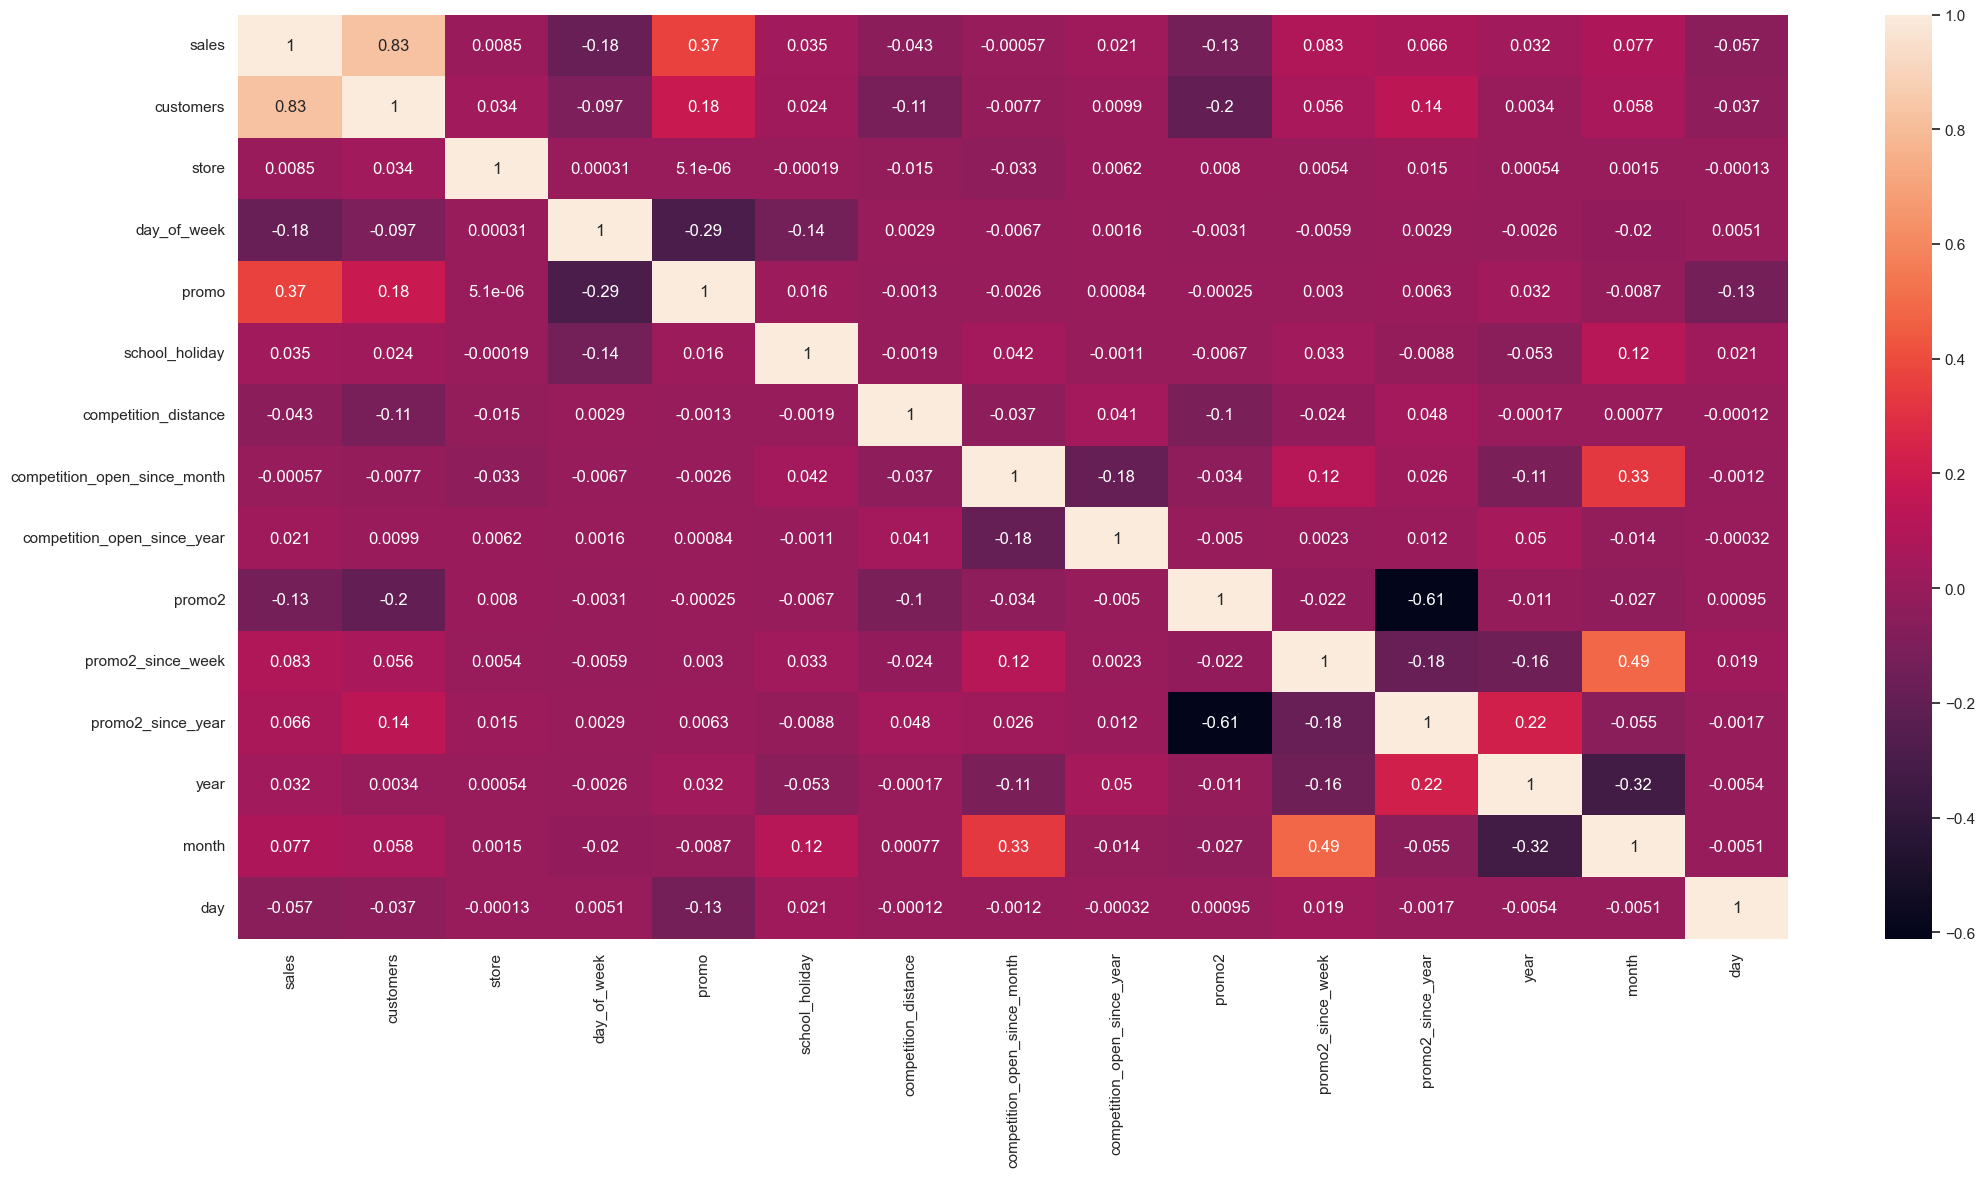

In [66]:
correlacao = num_attributes.drop(columns='open').corr(method='pearson')

sns.heatmap(correlacao, annot=True);

### 3.3.2 Variáveis Categóricas

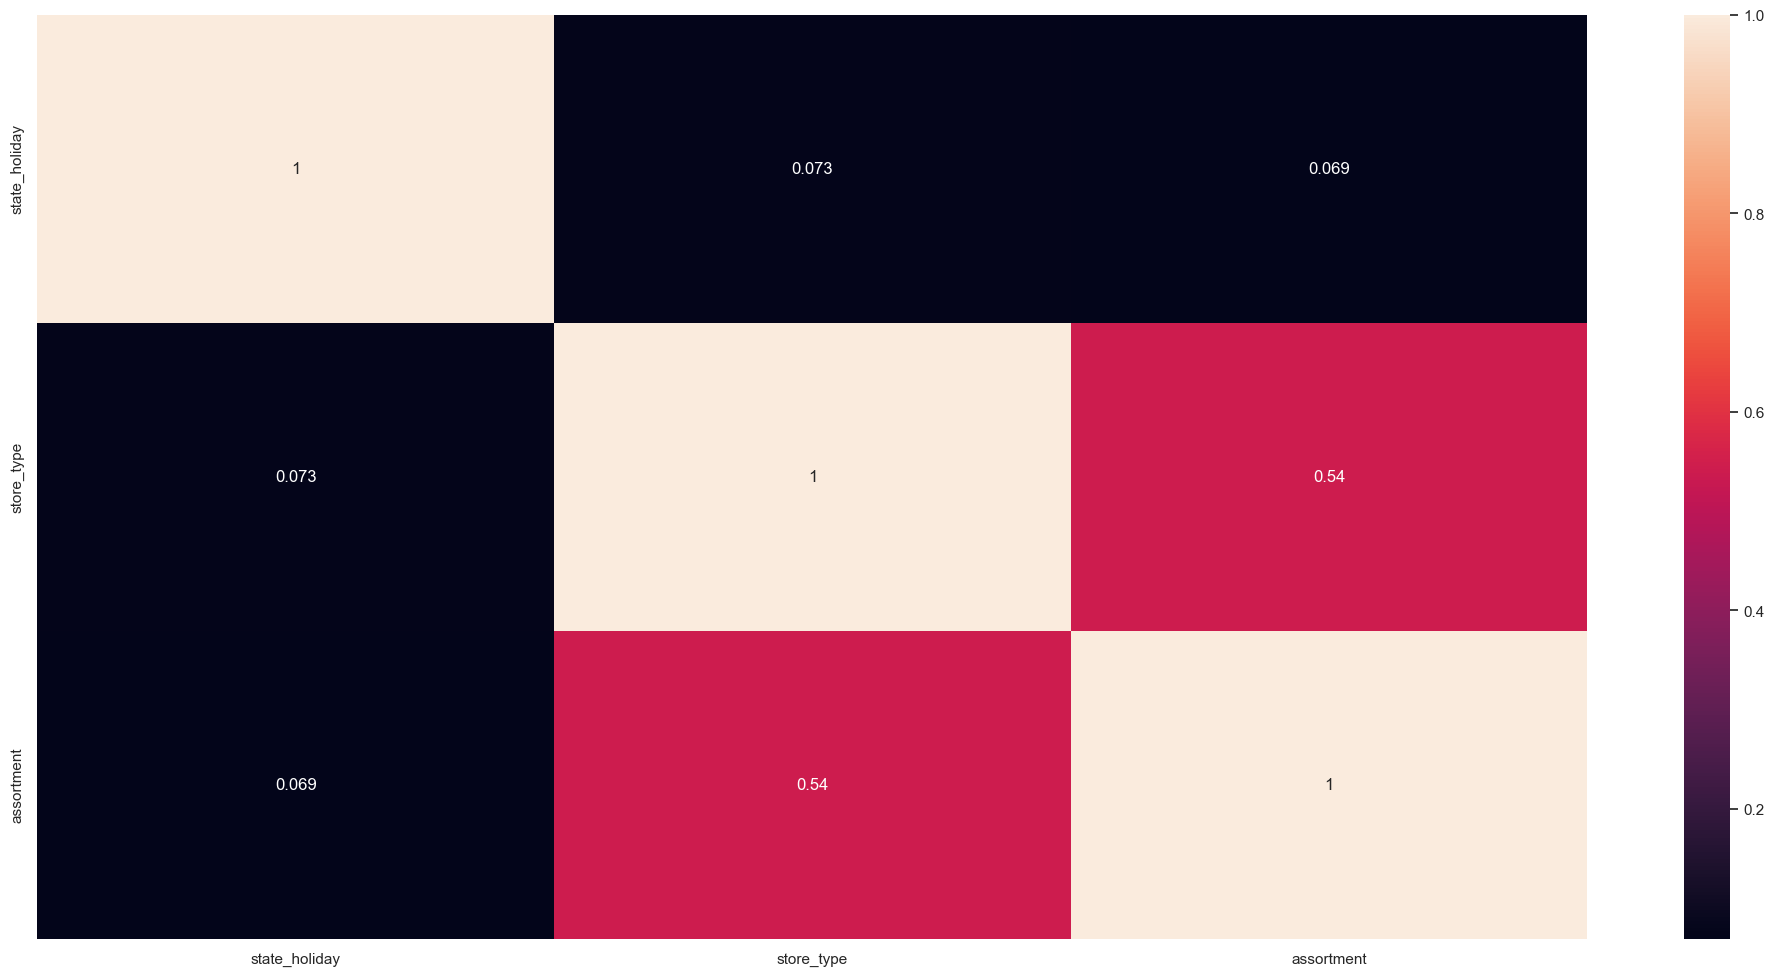

In [47]:
a = df3.select_dtypes( include='object') #SELECIONA SOMENTE VARIAVEIS CATEGORICAS

# CALCULA AS CORRELAÇÕES DE CRAMER ATRAVES DA FUNÇÃO PREDEFINIDA
a1 = cramer_v (a['state_holiday'], a['state_holiday']) 
a2 = cramer_v (a['state_holiday'], a['store_type'])
a3 = cramer_v (a['state_holiday'], a['assortment'])

a4 = cramer_v (a['store_type'], a['state_holiday'])
a5 = cramer_v (a['store_type'], a['store_type'])
a6 = cramer_v (a['store_type'], a['assortment'])

a7 = cramer_v (a['assortment'], a['state_holiday'])
a8 = cramer_v (a['assortment'], a['store_type'])
a9 = cramer_v (a['assortment'], a['assortment'])

d = pd.DataFrame ({ 'state_holiday': [a1,a2,a3],
                    'store_type': [a4,a5,a6],
                    'assortment': [a7,a8,a9] })

d = d.set_index(d.columns) # SUBSTITUI O INDEX PELOS NOMES DAS COLUNAS

sns.heatmap(d, annot=True); #PLOTA O HEATMAP

# 4.0 Feature Engineering

In [68]:
df4 = pd.read_csv('df3.csv')

In [69]:
#Transformações de tipo 
df4['competition_open_since_month'] = df4['competition_open_since_month'].astype('int64') 
df4['competition_open_since_year'] = df4['competition_open_since_year'].astype('int64')
df4['competition_distance'] = df4['competition_distance'].astype('int64')
df4['promo2_since_week'] = df4['promo2_since_week'].astype('int64')
df4['promo2_since_year'] = df4['promo2_since_year'].astype('int64')
df4['competition_time_month'] = df4['competition_time_month'].astype('int64')
df4['promo_time_week'] = df4['promo_time_week'].astype('int64')
df4['week_of_year'] = df4['week_of_year'].astype('int64')

In [70]:
#Transformação de Natureza  - Criação de feature baseada no circulo trigonometrico
# month
df4['month_sin'] = df4['month'].apply ( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) ) # aplica a função seno / 12 é o periodo ciclico - 12 meses do ano
df4['month_cos'] = df4['month'].apply ( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) ) # aplica a função cosseno / 12 é o periodo ciclico - 12 meses do ano

# day
df4['day_sin'] = df4['day'].apply ( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) ) # aplica a função seno / 30 é o periodo ciclico - média 30 dias no mês
df4['day_cos'] = df4['day'].apply ( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) ) # aplica a função cosseno / 30 é o periodo ciclico - média 30 dias no mês

# week of year
df4['week_of_year_sin'] = df4['week_of_year'].apply ( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) ) # aplica a função seno / 52 é o periodo ciclico - 52 semanas no ano
df4['week_of_year_cos'] = df4['week_of_year'].apply ( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) ) # aplica a função cosseno / 52 é o periodo ciclico - 52 semanas no ano

# day of week
df4['day_of_week_sin'] = df4['day_of_week'].apply ( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) ) # aplica a função seno / 7 é o periodo ciclico - 7 dias na semana
df4['day_of_week_cos'] = df4['day_of_week'].apply ( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) ) # aplica a função cosseno / 7 é o periodo ciclico - 7 dias na semana


In [ ]:
df4.date = pd.to_datetime(df4['date'])
df4.to_csv('df4.csv', index=False)

# 5.0 Feature Selection

In [72]:
df4 = pd.read_csv('df4.csv')
X_train = pd.read_csv('df4.csv')

## 5.1 Feature Selection - Importance 

In [73]:
minmaxfeat = ['store', 'day_of_week', 'promo', 'school_holiday', 'competition_distance',
              'competition_open_since_month', 'competition_open_since_year', 'promo2',
              'promo2_since_week', 'promo2_since_year', 'year', 'month', 'day',
              'week_of_year', 'competition_time_month', 'trimestre' ]

standardfeat = ['promo_time_week', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 
                'week_of_year_sin', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos']

In [74]:
ordinal = OrdinalEncoder(categories=[['basic','extra','extended']])

X_train['assortment'] = ordinal.fit_transform(X_train[['assortment']])

X_train = pd.get_dummies( X_train, prefix=['state_holiday'], columns=['state_holiday'] )

X_train = pd.get_dummies( X_train, prefix=['store_type'], columns=['store_type'] )

minmax = MinMaxScaler()
X_train[minmaxfeat] = minmax.fit_transform(X_train[minmaxfeat])

standard = StandardScaler()
X_train[standardfeat] = minmax.fit_transform(X_train[standardfeat])


In [75]:
X_train = X_train.drop(columns=['date', 'sales', 'customers', 'open', 'promo_interval', 'year_week', 'month_map', 'competition_since', 'promo_since']) 
y_train = df4['sales']

In [ ]:
# Roda modelo de árvore para selecionar features

# randomforest = RandomForestRegressor(n_jobs=-1, n_estimators=100, random_state=42)

# randomforest.fit(X_train, y_train)



Feature ranking:
                        feature  importance
0          competition_distance    0.216164
0                         store    0.159127
0                         promo    0.135221
0        competition_time_month    0.049365
0  competition_open_since_month    0.046067
0   competition_open_since_year    0.045220
0                   day_of_week    0.035483
0             promo2_since_week    0.032397
0                  store_type_b    0.025046
0             promo2_since_year    0.023339
0                    assortment    0.023255
0                  week_of_year    0.020426
0                        promo2    0.019404
0                       day_sin    0.019053
0               promo_time_week    0.018350
0                       day_cos    0.018323
0               day_of_week_cos    0.018171
0                  store_type_a    0.014227
0                           day    0.013061
0               day_of_week_sin    0.010799
0                  store_type_c    0.010609
0              

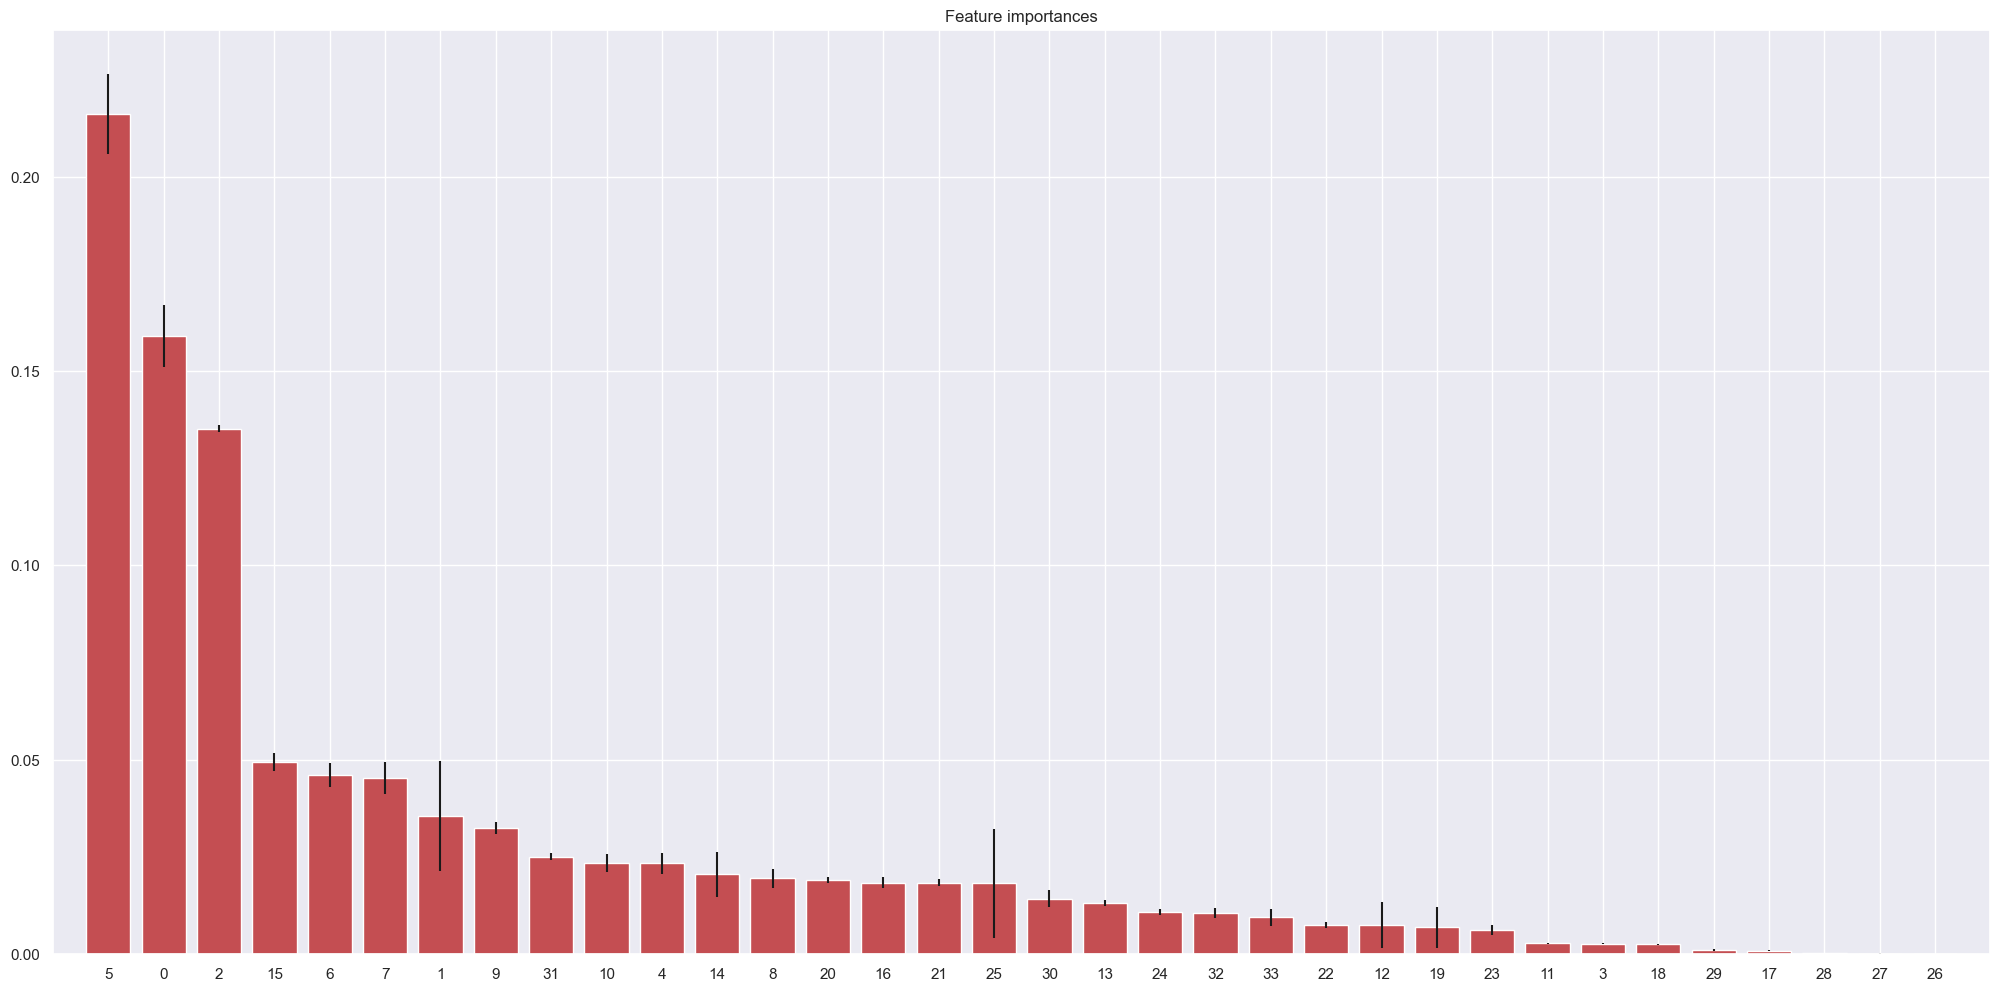

In [ ]:
# importances = randomforest.feature_importances_
# std = np.std( [tree.feature_importances_ for tree in randomforest.estimators_], axis=0)
# indices = np.argsort(importances)[::-1]
# 
# # Print the feature ranking
# print('Feature ranking:')
# df = pd.DataFrame()
# for i, j in zip( X_train, randomforest.feature_importances_ ):
#     aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
#     df = pd.concat( [df, aux], axis=0 )
#     
# df = np.round(df,6)
# print( df.sort_values( 'importance', ascending=False ) )
# 
# # Plot the impurity-based feature importances of the rf
# plt.figure()
# plt.title('Feature importances')
# plt.bar(range(X_train.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
# plt.xticks(range(X_train.shape[1]), indices)
# plt.xlim([-1, X_train.shape[1]])
# plt.show()

## 5.2  Feature Selection - Boruta

In [ ]:
# training e test dataset para o Boruta - precisa se vetor e não DF / não pode ter date e sales porque são variaveis de teste
# X_train_n = X_train.drop( ['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor (n_jobs=-1) #paramentro para que faça as arvores em paralelo e rode mais rapido

#define o Boruta
#boruta = BorutaPy(rf,n_estimators='auto', verbose=2, random_state=42). fit(X_train_n, y_train_n)

#cols_selected = boruta.support_.tolist()  #valor do rang que o Boruta ranqueou de acordo com a relevância

#X_train_fs = X_train.drop( ['date', 'sales'], axis=1) # dropa date e sales do dataframe x_train
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list() #seleciona o index encontrado no Boruta para encontrar o nome da coluna

#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta)) #faz o comparativo do que tem no x_train e não foi selecionado pelo Boruta


In [76]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos',
                        'day_of_week_sin',
                        'day_of_week_cos']

## 5.3 Variance Inflation Factor (VIF) 

Calculo realizado para identificar o nível da multicolinearidade das features

In [16]:
X_train.columns

Index(['store', 'day_of_week', 'promo', 'school_holiday', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'year', 'month', 'day', 'week_of_year',
       'competition_time_month', 'promo_time_week', 'trimestre', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos',
       'state_holiday_christmas', 'state_holiday_eater_holiday',
       'state_holiday_public_holiday', 'state_holiday_regular_day',
       'store_type_a', 'store_type_b', 'store_type_c', 'store_type_d'],
      dtype='object')

In [17]:
train = X_train

In [ ]:
#drop de colunas, após calculo do primeiro VIF
train.drop(columns=['store_type_a', 'state_holiday_regular_day'], inplace=True)

In [24]:
#drop de colunas, após calculo do segundo VIF
train.drop(columns=['competition_open_since_year', 'promo2_since_year', 'promo_time_week' ], inplace=True)

In [26]:
#drop de colunas, após calculo do terceiro VIF
train.drop(columns=['trimestre', 'day_of_week', 'week_of_year', 'day', 'month'], inplace=True)

In [28]:
#drop de colunas, após calculo do quarto VIF
train.drop(columns=['month_sin', 'week_of_year_sin'], inplace=True)

In [29]:
# Testing for multicolinearity 

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = train.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(train.values, i)
                          for i in range(len(train.columns))]
  
print(np.round(vif_data,2))

                         feature    VIF
0                          store   3.53
1                          promo   1.97
2                 school_holiday   1.31
3                     assortment   1.96
4           competition_distance   1.25
5   competition_open_since_month   3.70
6                         promo2   1.95
7              promo2_since_week   3.32
8                           year   2.04
9         competition_time_month   2.19
10                     month_cos  66.92
11                       day_sin   2.85
12                       day_cos   2.83
13              week_of_year_cos  68.42
14               day_of_week_sin   2.69
15               day_of_week_cos   2.41
16       state_holiday_christmas   1.01
17   state_holiday_eater_holiday   1.01
18  state_holiday_public_holiday   1.01
19                  store_type_b   1.05
20                  store_type_c   1.25
21                  store_type_d   1.67


In [77]:
vif_columns = ['store', 'promo', 'school_holiday', 'assortment',
       'competition_distance', 'competition_open_since_month', 'promo2',
       'promo2_since_week', 'year', 'competition_time_month', 'month_cos',
       'day_sin', 'day_cos', 'week_of_year_cos', 'day_of_week_sin',
       'day_of_week_cos', 'state_holiday_christmas',
       'state_holiday_eater_holiday', 'state_holiday_public_holiday',
       'store_type_b', 'store_type_c', 'store_type_d']

# 6.0 Pipeline

In [4]:
minmaxfeat = ['store', 'promo', 'competition_distance',
              'competition_open_since_month', 'competition_open_since_year', 'promo2',
              'promo2_since_week', 'promo2_since_year','competition_time_month' ]

standardfeat = ['promo_time_week', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 
                'week_of_year_sin', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos']

ordinalfeat = ['assortment']

onehotfeat = ['state_holiday', 'store_type']


In [5]:
# Cria as "caixinhas" do pipeline para transformações - instancia o objeto PIPELINE

minmaxpipe = Pipeline([('MinMax', MinMaxScaler())])
standardpipe = Pipeline([('Standard', StandardScaler())])
ordinalpipe = Pipeline([('Ordinal', OrdinalEncoder(categories=[['basic', 'extra', 'extended']]))])
onehotpipe = Pipeline([('OneHot', OneHotEncoder())])

In [6]:
# Cria a "caixa" maior (transformer) para receber a caixinha de transformações - permite separar as features por PIPELINE 

column_transf = ColumnTransformer([('MinMax', minmaxpipe, minmaxfeat), 
                                   ('Standard', standardpipe, standardfeat),
                                   ('Ordinal', ordinalpipe, ordinalfeat),
                                   ('OneHot', onehotpipe, onehotfeat)])

column_transf

ColumnTransformer(transformers=[('MinMax',
                                 Pipeline(steps=[('MinMax', MinMaxScaler())]),
                                 ['store', 'promo', 'competition_distance',
                                  'competition_open_since_month',
                                  'competition_open_since_year', 'promo2',
                                  'promo2_since_week', 'promo2_since_year',
                                  'competition_time_month']),
                                ('Standard',
                                 Pipeline(steps=[('Standard',
                                                  StandardScaler())]),
                                 ['promo_time_week', 'month_sin', 'month_cos',
                                  'day_sin', 'day_cos', 'week_of_year_sin',
                                  'week_of_year_cos', 'day_of_week_sin',
                                  'day_of_week_cos']),
                                ('Ordinal',
                                 Pipeline(steps=[('Ordinal',
                                                  OrdinalEncoder(categories=[['basic',
                                                                              'extra',
                                                                              'extended']]))]),
                                 ['assortment']),
                                ('OneHot',
                                 Pipeline(steps=[('OneHot', OneHotEncoder())]),
                                 ['state_holiday', 'store_type'])])

# 7.0 Modelos 

## 7.1 Baseline

In [102]:
mean = df4[['store', 'sales']].groupby('store').mean().round(2).reset_index().rename(columns={'sales':'predictions'})
pred_mean = pd.merge(df4, mean, how='left', on='store')

In [104]:
# Métricas para o baseline
baseline_mean = reg_metrics('Mean', pred_mean.sales, pred_mean.predictions)
baseline_mean

,Modelo,MAE,MAPE,RMSE,RMSPE
0,Mean,1462.87,0.24,1969.09,0.4


## 7.2 Linear Regression

In [105]:
lin_model = LinearRegression()

In [111]:
lin, lin_mean = cross_validation(lin_model, 'Linear Model', df4, 5 )

In [112]:
lin

,K,Modelo,MAE,MAPE,RMSE,RMSPE
0,5,Linear Model,1931.36,0.31,2758.23,0.46
1,5,Linear Model_val,1864.17,0.31,2519.29,0.46
2,4,Linear Model,1927.24,0.31,2750.84,0.46
3,4,Linear Model_val,2600.52,0.31,3750.15,0.78
4,3,Linear Model,1959.32,0.31,2797.02,0.49
5,3,Linear Model_val,1910.22,0.33,2549.38,0.54
6,2,Linear Model,1955.08,0.31,2788.92,0.48
7,2,Linear Model_val,1793.16,0.30,2487.74,0.46
8,1,Linear Model,1946.30,0.31,2776.26,0.48
9,1,Linear Model_val,2046.16,0.29,2953.19,0.42


In [113]:
lin_mean

,Modelo,MAE,MAPE,RMSE,RMSPE
0,Linear Model,2042.846,0.308,2851.95,0.532


## 7.3 Lasso

In [114]:
lasso_model = Lasso()

In [115]:
lasso, lasso_mean = cross_validation(lasso_model, 'Lasso', df4, 5)

In [116]:
lasso

,K,Modelo,MAE,MAPE,RMSE,RMSPE
0,5,Lasso,2215.44,0.36,3135.75,0.54
1,5,Lasso_val,2044.46,0.33,2870.88,0.49
2,4,Lasso,2206.75,0.36,3121.99,0.54
3,4,Lasso_val,3076.50,0.36,4339.95,0.88
4,3,Lasso,2249.70,0.36,3182.51,0.57
5,3,Lasso_val,2100.99,0.34,2920.43,0.57
6,2,Lasso,2241.96,0.36,3168.77,0.57
7,2,Lasso_val,2021.62,0.34,2819.51,0.51
8,1,Lasso,2230.21,0.36,3152.29,0.56
9,1,Lasso_val,2492.09,0.34,3539.09,0.49


In [117]:
lasso_mean

,Modelo,MAE,MAPE,RMSE,RMSPE
0,Lasso,2347.132,0.342,3297.972,0.588


## 7.4 Ridge

In [118]:
ridge_model = Ridge()

In [119]:
ridge, ridge_mean = cross_validation(ridge_model, 'Ridge', df4, 5)

In [120]:
ridge

,K,Modelo,MAE,MAPE,RMSE,RMSPE
0,5,Ridge,1931.36,0.31,2758.23,0.46
1,5,Ridge_val,1864.15,0.31,2519.29,0.46
2,4,Ridge,1927.13,0.31,2750.59,0.46
3,4,Ridge_val,2598.13,0.31,3746.78,0.78
4,3,Ridge,1959.32,0.31,2796.99,0.49
5,3,Ridge_val,1910.21,0.33,2549.31,0.54
6,2,Ridge,1955.05,0.31,2789.27,0.48
7,2,Ridge_val,1792.56,0.30,2489.15,0.46
8,1,Ridge,1946.54,0.31,2776.37,0.48
9,1,Ridge_val,2046.78,0.29,2954.24,0.42


In [121]:
ridge_mean

,Modelo,MAE,MAPE,RMSE,RMSPE
0,Ridge,2042.366,0.308,2851.754,0.532


## 7.5 Random Forest Regressor

In [125]:
randomforest_model = RandomForestRegressor(n_estimators=20, random_state=25, n_jobs=-1)

In [126]:
randomforest, randomforest_mean = cross_validation(randomforest_model, 'Random Forest', df4, 5)

KeyboardInterrupt: 

In [ ]:
randomforest

In [ ]:
randomforest_mean

## 7.6 XGBoost

In [137]:
xgb_model = xg.XGBRegressor( objective='reg:squarederror',
                              n_estimators=150, 
                              n_jobs=-1 )

In [138]:
xgb_CV, xgb_mean = cross_validation(xgb_model, 'XGBoost', df4, 5)

In [139]:
xgb_CV

,K,Modelo,MAE,MAPE,RMSE,RMSPE
0,5,XGBoost,677.63,0.10,990.68,0.18
1,5,XGBoost_val,741.30,0.11,1050.46,0.15
2,4,XGBoost,687.24,0.11,998.96,0.19
3,4,XGBoost_val,1224.85,0.16,1753.35,0.57
4,3,XGBoost,696.32,0.11,1013.36,0.22
5,3,XGBoost_val,1176.03,0.18,1688.07,0.26
6,2,XGBoost,706.03,0.11,1030.99,0.20
7,2,XGBoost_val,807.38,0.13,1174.95,0.21
8,1,XGBoost,702.16,0.11,1017.48,0.20
9,1,XGBoost_val,1006.98,0.13,1463.22,0.18


In [140]:
xgb_mean

,Modelo,MAE,MAPE,RMSE,RMSPE
0,XGBoost,991.308,0.142,1426.01,0.274


## 7.7 Comparação das performances dos modelos

### 7.7.1 Média das performances

In [143]:
mean_models = pd.concat([ baseline_mean, lin_mean, lasso_mean, ridge_mean, randomforest_mean, xgb_mean ])

mean_models.to_csv('mean_models.csv', index=False)

mean_models

,Modelo,MAE,MAPE,RMSE,RMSPE
0,Mean,1462.870,0.240,1969.090,0.400
0,Linear Model,2040.620,0.308,2849.558,0.530
0,Lasso,2347.132,0.342,3297.972,0.588
0,Ridge,2040.634,0.306,2849.226,0.530
0,Random Forest,823.490,0.116,1240.012,0.266
0,XGBoost,991.308,0.142,1426.010,0.274


### 7.7.2 Performances no cross validation

In [142]:
cross_geral = pd.concat([ lin, lasso, ridge, randomforest, xgb_CV ])

cross_geral.to_csv('cross_geral.csv', index=False)

# 8.0 Hyperparameter fine-tuning

<span style='color:green'> Selecionado XGBOOST, apesar de ter performance um pouco menor que o Random Forest, ele é mais leve, economizando poder computacional. </span>

Ideal seria ter feito o Hyperparameter dentro do CrossValidation, para que fosse aplicado em todos os períodos, porém isso exigiria um alto poder computacional, portanto esta alternativa foi descartada momentaneamente.

Três tipo de finetuning:
* Grid Search: testa em todas as combinações para encontrar a melhor performance.
* Random Search: busca aleatoriamente entre os intervalos dos hyperparamentros e roda o modelo
* Bayesian Search: faz uma primeira busca aleatórea, nas proximas buscas vai adequar o hiperparametro.

In [4]:
validation = pd.read_csv('validation.csv') 
train = pd.read_csv('df4.csv') 

In [11]:
validation_ = feature_engineering(validation)


# define as features 
X_cols = (minmaxfeat + standardfeat + ordinalfeat + onehotfeat) 

#Definindo X e y de treino
X_train = train[X_cols]
y_train = train['sales']

#Definindo X e y de validação
X_val = validation_[X_cols]
y_val = validation_['sales']

# Preprocessamento das variáveis independentes
X_train = column_transf.fit_transform(X_train)
X_val = column_transf.transform(X_val)

In [12]:
param_space = [(0.0, 0.3, 0.1), #eta
               (3, 10), #max_depth
               (3, 20), #min_child_weight
               (0.0, 1.0), #subsample
               (0.0, 1.0), #colsample_bytree
               (1500, 2000, 100)] #n_estimators
         

In [94]:
resultado = dummy_minimize(training_model, param_space, random_state=25, verbose=1, n_calls=2)

Iteration No: 1 started. Evaluating function at random point.
[0.6960659741034876, 10, 15, 0.15061805484723703, 0.2591784349454101, 1888] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 697.9121
Function value obtained: 2599.0000
Current minimum: 2599.0000
Iteration No: 2 started. Evaluating function at random point.
[0.4376110596596505, 10, 8, 0.7612549394545387, 0.9465064414817149, 1939] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1768.8811
Function value obtained: 1149.0000
Current minimum: 1149.0000


In [95]:
resultado.x


[0.4376110596596505, 10, 8, 0.7612549394545387, 0.9465064414817149, 1939]

In [13]:
resultado_gp = gp_minimize(training_model, param_space, random_state=25, verbose=1, n_calls=30, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
[0.1, 6, 5, 0.18082455106899234, 0.15061805484723703, 1500] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 434.3171
Function value obtained: 1256.0000
Current minimum: 1256.0000
Iteration No: 2 started. Evaluating function at random point.
[0.1, 4, 8, 0.7612549394545387, 0.9465064414817149, 100] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 47.1607
Function value obtained: 2303.0000
Current minimum: 1256.0000
Iteration No: 3 started. Evaluating function at random point.
[0.1, 6, 13, 0.6593447426412339, 0.36206035836924794, 1500] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 678.8873
Function value obtained: 1058.0000
Current minimum: 1058.0000
Iteration No: 4 started. Evaluating function at random point.
[0.3, 5, 7, 0.9432465537119519, 0.47754552958563645, 1500] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 731.0762
Function value 

In [14]:
resultado_gp.x

[0.1, 10, 13, 0.6301456857888572, 1.0, 2000]

# 9.0 Pipeline e Modelo com fine-tuning

In [3]:
validation = pd.read_csv('validation.csv') 
train = pd.read_csv('df4.csv') 

In [7]:
validation_ = feature_engineering(validation)

#unifica train e validation
final_train = pd.concat([train, validation], join='inner', ignore_index=True)


In [8]:
minmaxfeat = ['store', 'promo', 'competition_distance',
              'competition_open_since_month', 'competition_open_since_year', 'promo2',
              'promo2_since_week', 'promo2_since_year','competition_time_month' ]

standardfeat = ['promo_time_week', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 
                'week_of_year_sin', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos']

ordinalfeat = ['assortment']

onehotfeat = ['state_holiday', 'store_type']


In [9]:
# define as features 
X_cols = (minmaxfeat + standardfeat + ordinalfeat + onehotfeat) 

#Definindo X e y de treino
X_train = train[X_cols]
y_train = train['sales']


In [10]:
minmaxpipe = Pipeline([('MinMaxEncoder', MinMaxScaler())])
standardpipe = Pipeline([('StandardEncoder', StandardScaler())])
ordinalpipe = Pipeline([('OrdinalEncoder', OrdinalEncoder(categories=[['basic', 'extra', 'extended']]))])
onehotpipe = Pipeline([('OneHotEncoder', OneHotEncoder())])

In [11]:
column_transform = ColumnTransformer([('MinMax', minmaxpipe, minmaxfeat),
                                     ('Standard', standardpipe, standardfeat),
                                     ('Ordinal', ordinalpipe, ordinalfeat),
                                     ('OneHot', onehotpipe, onehotfeat)])

column_transform

ColumnTransformer(transformers=[('MinMax',
                                 Pipeline(steps=[('MinMaxEncoder',
                                                  MinMaxScaler())]),
                                 ['store', 'promo', 'competition_distance',
                                  'competition_open_since_month',
                                  'competition_open_since_year', 'promo2',
                                  'promo2_since_week', 'promo2_since_year',
                                  'competition_time_month']),
                                ('Standard',
                                 Pipeline(steps=[('StandardEncoder',
                                                  StandardScaler())]),
                                 ['promo_time_week', 'month_sin', 'month_cos',
                                  'day_sin', 'day_cos', 'week_of_year_sin',
                                  'week_of_year_cos', 'day_of_week_sin',
                                  'day_of_week_cos']),
                                ('Ordinal',
                                 Pipeline(steps=[('OrdinalEncoder',
                                                  OrdinalEncoder(categories=[['basic',
                                                                              'extra',
                                                                              'extended']]))]),
                                 ['assortment']),
                                ('OneHot',
                                 Pipeline(steps=[('OneHotEncoder',
                                                  OneHotEncoder())]),
                                 ['state_holiday', 'store_type'])])

In [12]:
final_model = Pipeline([('ColumnTransform', column_transform), 
                       ('XGBOOST', xg.XGBRegressor(eta= 0.1, 
                                                max_depth=10, 
                                                min_child_weight=13, 
                                                subsample=0.6301456857888572, 
                                                colsample_bytree=1.0, 
                                                n_estimators=2000,
                                                n_jobs=-1))])

final_model

Pipeline(steps=[('ColumnTransform',
                 ColumnTransformer(transformers=[('MinMax',
                                                  Pipeline(steps=[('MinMaxEncoder',
                                                                   MinMaxScaler())]),
                                                  ['store', 'promo',
                                                   'competition_distance',
                                                   'competition_open_since_month',
                                                   'competition_open_since_year',
                                                   'promo2',
                                                   'promo2_since_week',
                                                   'promo2_since_year',
                                                   'competition_time_month']),
                                                 ('Standard',
                                                  Pipeline(steps=[('StandardEncoder...
                              eval_metric=None, feature_types=None, gamma=None,
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=13, missing=nan,
                              monotone_constraints=None, n_estimators=2000,
                              n_jobs=-1, num_parallel_tree=None, predictor=None, ...))])

In [13]:
final_model.fit(X_train, y_train)

Pipeline(steps=[('ColumnTransform',
                 ColumnTransformer(transformers=[('MinMax',
                                                  Pipeline(steps=[('MinMaxEncoder',
                                                                   MinMaxScaler())]),
                                                  ['store', 'promo',
                                                   'competition_distance',
                                                   'competition_open_since_month',
                                                   'competition_open_since_year',
                                                   'promo2',
                                                   'promo2_since_week',
                                                   'promo2_since_year',
                                                   'competition_time_month']),
                                                 ('Standard',
                                                  Pipeline(steps=[('StandardEncoder...
                              eval_metric=None, feature_types=None, gamma=None,
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=13, missing=nan,
                              monotone_constraints=None, n_estimators=2000,
                              n_jobs=-1, num_parallel_tree=None, predictor=None, ...))])

In [14]:
y_pred = final_model.predict(X_train)

In [15]:
reg_metrics('XGBOOST_FINAL', y_train, y_pred)

,Modelo,MAE,MAPE,RMSE,RMSPE
0,XGBOOST_FINAL,311.14,0.05,434.63,0.13


In [185]:
pickle.dump(final_model, open('final_model.pkl', 'wb'))

In [188]:
joblib.dump(final_model, 'pipeline_final.pkl', compress=1)

['pipeline_final.pkl']

## 9.1 Preparação dos dados de teste

In [18]:
test = pd.read_csv('test.csv')

In [19]:
test = feature_engineering(test)

In [20]:
# define as features 
# X_cols = (minmaxfeat + standardfeat + ordinalfeat + onehotfeat) 

#Definindo X e y de teste
X_test = test[X_cols]
y_test = test['sales']


In [21]:
y_pred_test = final_model.predict(X_test)

In [22]:
reg_metrics('XGBOOST_TEST', y_test, y_pred_test) # teve overfit - na regressão quanto menor o erro, melhor - na empresa, é necessário ficar atento, fazer um retreino em uma semana +/-

,Modelo,MAE,MAPE,RMSE,RMSPE
0,XGBOOST_TEST,675.71,0.1,966.42,0.14


## 9.2 Performance para o negócio

In [114]:
final_performance = test.copy()

In [115]:
final_performance['predictions'] = y_pred_test

final_performance['residuo'] = np.abs(final_performance.sales - final_performance.predictions)

<AxesSubplot: >

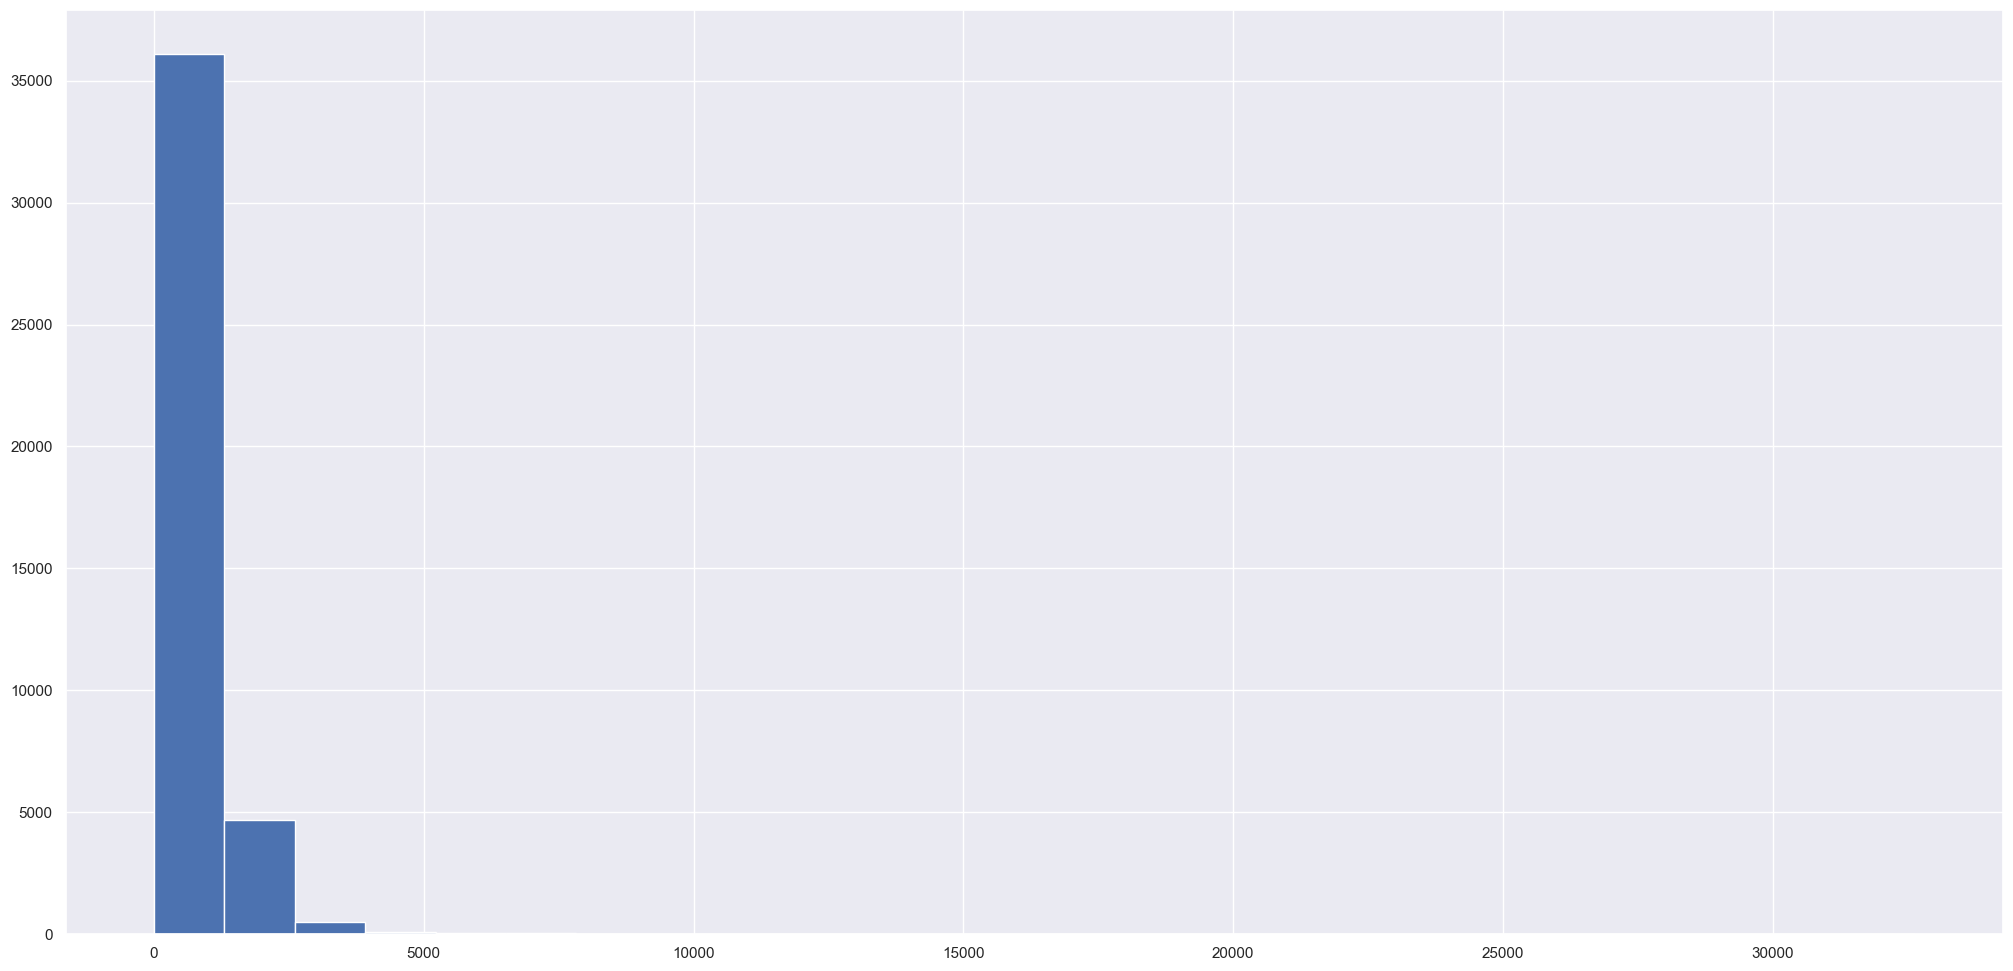

In [116]:
final_performance.residuo.hist(bins=25)

In [117]:
final_performance.loc[final_performance.residuo == final_performance.residuo.max()]

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,trimestre,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos,predictions,residuo
44393,909,1,2015-06-22,41551,1721,1,0,regular_day,0,a,extended,1680,6,2015,1,45,2009,"Feb,May,Aug,Nov",Jun,2015,6,22,26,2015-25,2015-06-01,0,2009-11-02,294,2,1.224647e-16,-1.0,-0.994522,-0.104528,1.224647e-16,-1.0,0.781831,0.62349,8917.956055,32633.043945


In [118]:
final_performance[['predictions', 'residuo']] = final_performance[['predictions', 'residuo']].astype('float64')

In [55]:
(final_performance.loc[final_performance.store == 909, ['date', 'sales', 'customers', 'predictions', 'residuo']])

,date,sales,customers,predictions,residuo
908,2015-07-31,16140,1301,14713,1426
2023,2015-07-30,14894,1166,15281,387
3138,2015-07-29,12140,1018,14575,2435
4253,2015-07-28,13314,1138,13285,28
5368,2015-07-27,15236,1273,14599,636
7598,2015-07-25,14613,1160,9252,5360
8713,2015-07-24,14406,1249,9101,5304
9828,2015-07-23,15484,1275,8328,7155
10943,2015-07-22,14708,1196,8241,6466
12058,2015-07-21,16338,1398,8847,7490


In [119]:
total_predictions = final_performance[['store', 'predictions','sales', 'residuo']].groupby('store').sum().reset_index()


In [120]:
MAE = total_predictions[['store', 'residuo']].groupby('store').mean().reset_index().rename(columns={'residuo':'MAE'})

In [124]:
MAPE = total_predictions[['store', 'residuo', 'sales']].groupby('store')\
                                                       .apply(lambda x:(np.mean(np.abs((x.residuo)/x.sales))))\
                                                       .reset_index()\
                                                       .rename(columns={0:'MAPE'})

In [130]:
final_metrics = pd.concat([total_predictions, MAE, MAPE], axis=1,  )
final_metrics = final_metrics.iloc[:, [0,1,5,7]]
final_metrics['worst_scenario'] = final_metrics.predictions - final_metrics.MAE
final_metrics['best_scenario'] = final_metrics.predictions + final_metrics.MAE
final_metrics = final_metrics[['store', 'worst_scenario', 'predictions', 'best_scenario', 'MAE', 'MAPE' ]]

print(final_metrics.sort_values('MAPE', ascending=False).head(10),'\n''\n',
final_metrics.sort_values('MAPE', ascending=True).head(10))

     store  worst_scenario    predictions  best_scenario            MAE      MAPE
908    909    83115.914062  250917.789062  418719.664062  167801.875000  0.466027
291    292    42799.957031  105343.598877  167887.240723   62543.641846  0.453326
901    902   147908.000000  210983.561035  274059.122070   63075.561035  0.426451
875    876   103751.094727  201070.864746  298390.634766   97319.770020  0.377859
169    170   151952.000000  205511.927979  259071.855957   53559.927979  0.352479
594    595   196179.714844  362696.357422  529213.000000  166516.642578  0.314650
38      39   174702.000000  227647.413574  280592.827148   52945.413574  0.303061
102    103   173869.000000  226228.337891  278587.675781   52359.337891  0.301142
656    657   204252.570312  264717.034180  325181.498047   60464.463867  0.295501
710    711   211462.000000  271866.312500  332270.625000   60404.312500  0.285651 

       store  worst_scenario    predictions  best_scenario           MAE      MAPE
732     733  

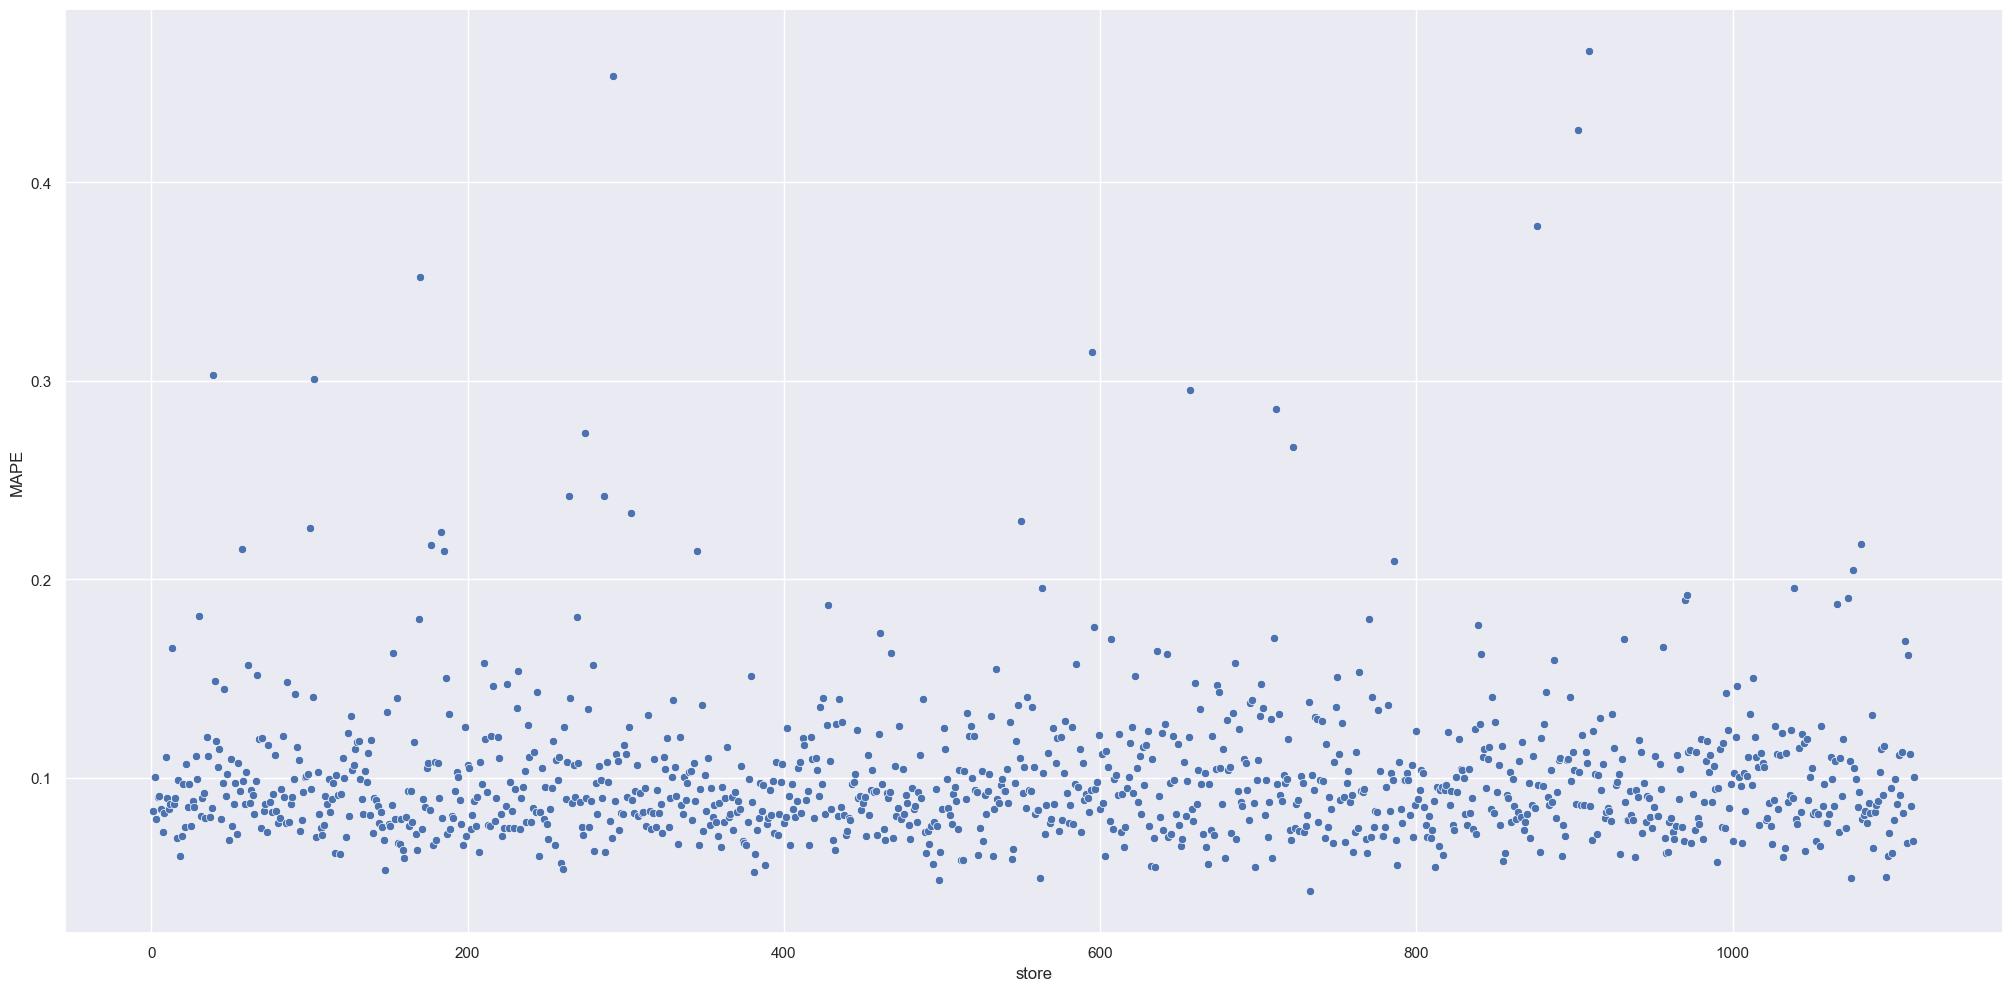

In [126]:
sns.scatterplot(final_metrics, x='store', y='MAPE');

## 9.3 Performance Total

In [161]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

performance_total = final_metrics[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.round(np.sum(x),2), axis=0)\
                                                                                     .reset_index()\
                                                                                     .rename(columns={'index':'Scenarios', 0:'Values'})
performance_total.Values = performance_total.Values.map( '$ {:_.2f}'.format)
performance_total.Values = performance_total.Values.str.replace('.', ',')
performance_total.Values = performance_total.Values.str.replace('_', '.')

performance_total


,Scenarios,Values
0,predictions,"$ 287.162.270,32"
1,worst_scenario,"$ 259.190.738,87"
2,best_scenario,"$ 315.133.801,76"


## 9.4 ML Performance

In [ ]:
ml_performance = final_performance.copy()


In [180]:
ml_performance.date = pd.to_datetime(ml_performance.date, format= '%Y-%m-%d')

In [183]:
ml_performance.residuo = ml_performance.sales - ml_performance.predictions

In [175]:
ml_performance['error_rate'] = ml_performance.predictions/ml_performance.sales

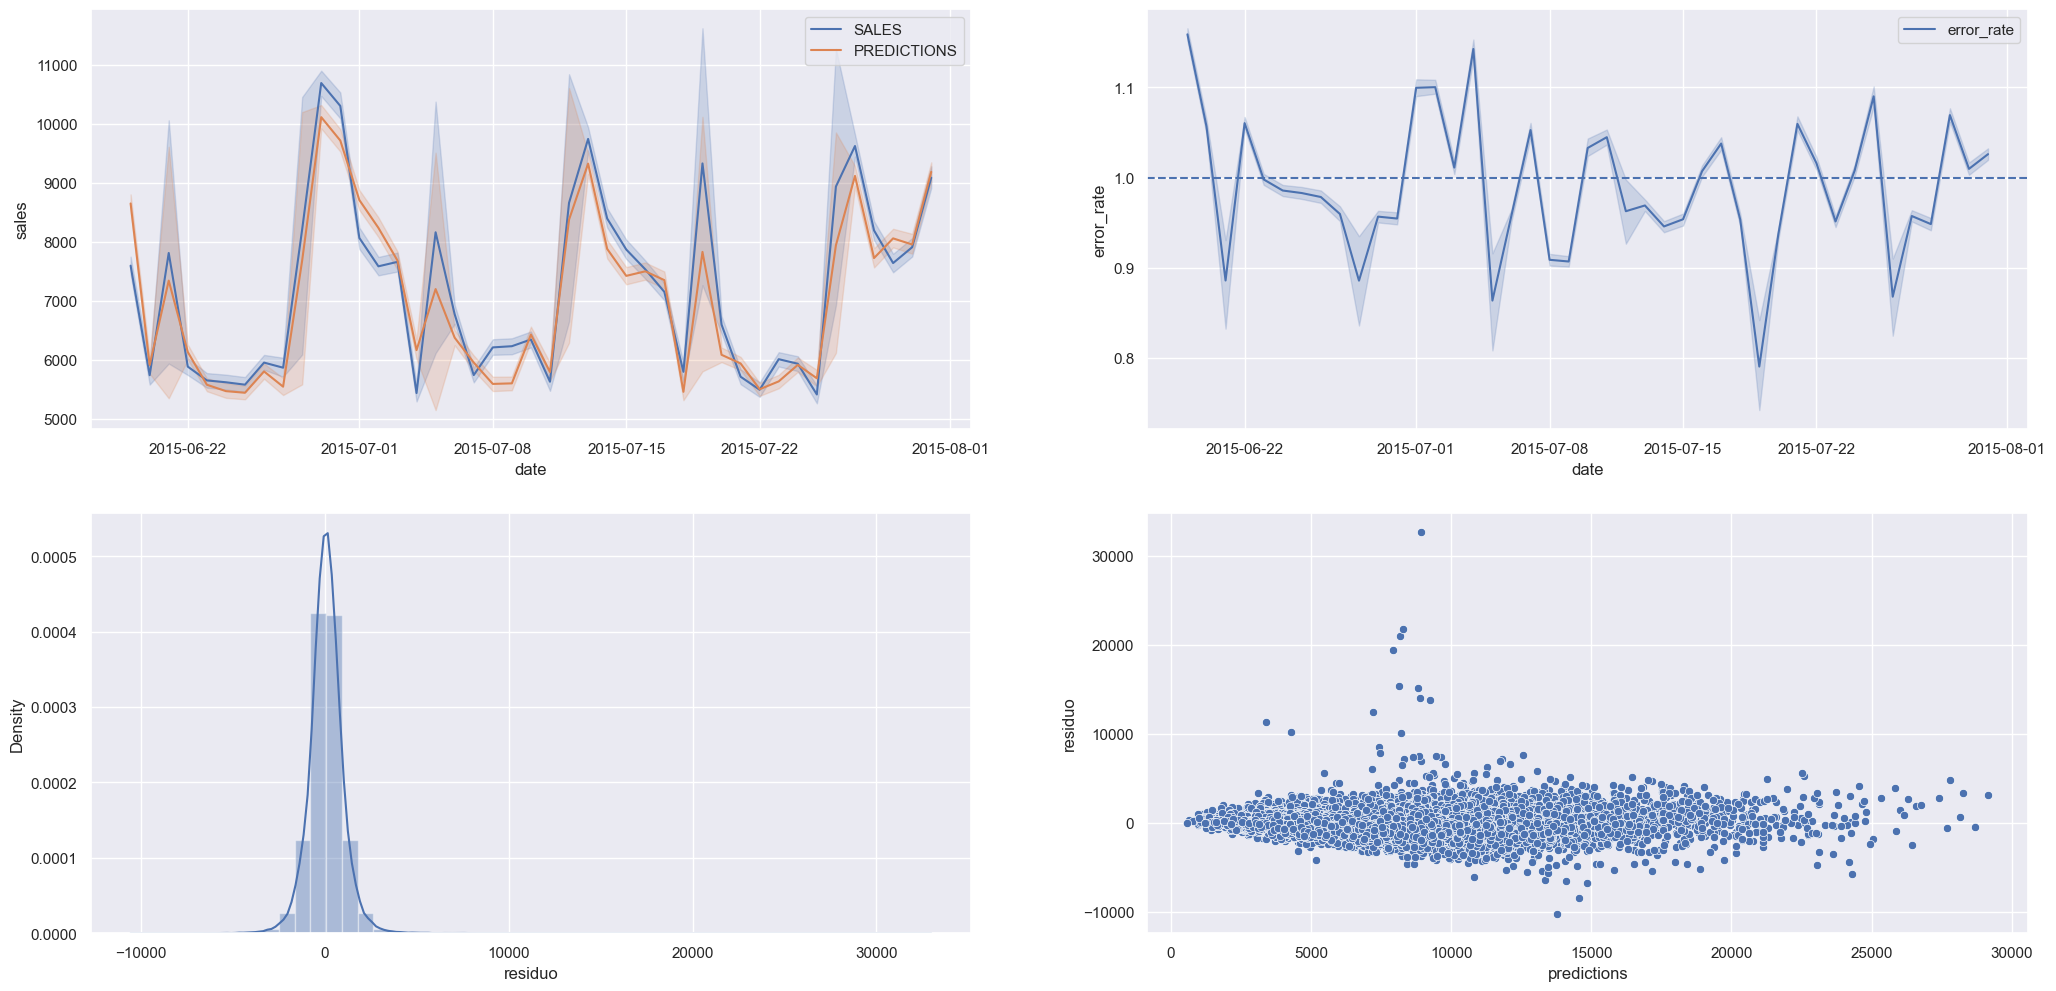

In [184]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=ml_performance, label='SALES')
sns.lineplot( x='date', y='predictions', data=ml_performance, label='PREDICTIONS')
#plt.xticks(rotation=45)

plt.subplot( 2, 2, 2)
sns.lineplot( x='date', y='error_rate', data=ml_performance, label='error_rate')
plt.axhline( 1, linestyle='--' )
#plt.xticks(rotation=45)

plt.subplot( 2, 2, 3)
sns.distplot( ml_performance['residuo'] )

plt.subplot( 2, 2, 4)
sns.scatterplot( data=ml_performance, x=ml_performance['predictions'], y=ml_performance['residuo'] );

# 10.0 Teste: Previsões Customers

In [8]:
validation = pd.read_csv('validation.csv') 
train = pd.read_csv('df4.csv') 

In [9]:
validation_ = feature_engineering(validation)


# define as features 
X_cols = (minmaxfeat + standardfeat + ordinalfeat + onehotfeat) 

#Definindo X e y de treino
X_train = train[X_cols]
y_train = train['customers']

#Definindo X e y de validação
X_val = validation_[X_cols]
y_val = validation_['customers']

# Preprocessamento das variáveis independentes
X_train = column_transf.fit_transform(X_train)
X_val = column_transf.transform(X_val)

In [10]:
xgb_customers = xg.XGBRegressor(n_jobs=-1)

In [11]:
xgb_customers.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [50]:
y_pred = xgb_customers.predict(X_train)
y_pred_val = xgb_customers.predict(X_val)

In [51]:
reg_metrics('XGBOOST', y_train, y_pred)

,Modelo,MAE,MAPE,RMSE,RMSPE
0,XGBOOST,83.91,0.13,117.97,0.51


In [52]:
reg_metrics('XGBOOST', y_val, y_pred_val)

,Modelo,MAE,MAPE,RMSE,RMSPE
0,XGBOOST,89.96,0.13,123.38,0.19


## 8.1 Previsões Customers + Sales - houve uma pequena melhora na performance porém, não vale o custo computacional

In [33]:
train = pd.read_csv('df4.csv')
validation = pd.read_csv('validation.csv')

In [34]:
validation_ = feature_engineering(validation)


In [35]:
validation_.customers = y_pred_val

NameError: name 'y_pred_val' is not defined

In [ ]:
train.select_dtypes(include='object')

In [36]:
train = pd.get_dummies(train, prefix=['state_holiday'], columns=['state_holiday'])
train = pd.get_dummies(train, prefix=['store_type'], columns=['store_type'])

validation_ = pd.get_dummies(validation_, prefix=['state_holiday'], columns=['state_holiday'])
validation_ = pd.get_dummies(validation_, prefix=['store_type'], columns=['store_type'])

In [37]:
ordinalencoder = OrdinalEncoder(categories=[['basic', 'extra', 'extended']])
train['assortment'] = ordinalencoder.fit_transform(train[['assortment']])

validation_['assortment'] = ordinalencoder.fit_transform(validation_[['assortment']])

In [38]:
validation_[['state_holiday_christmas', 'state_holiday_eater_holiday']] = 0

In [ ]:
X_cols = (minmaxfeat + standardfeat + ['customers', 'assortment', 'state_holiday_christmas',
       'state_holiday_eater_holiday', 'state_holiday_public_holiday',
       'state_holiday_regular_day', 'store_type_a', 'store_type_b',
       'store_type_c', 'store_type_d']) 
X_cols

In [94]:
#Definindo X e y de treino
X_train = train[X_cols]
y_train = train['sales']

#Definindo X e y de validação
X_val = validation_[X_cols]
y_val = validation_['sales']


In [95]:
xgb_customersales = xg.XGBRegressor(n_jobs=-1)

In [96]:
xgb_customersales.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [97]:
y_pred_val = xgb_customersales.predict(X_val)

In [98]:
y_pred_val

array([ 4909.368 ,  5403.1255,  8437.596 , ...,  7327.036 , 21786.65  ,
        6670.2305], dtype=float32)

In [99]:
reg_metrics('XGBOOST', y_val, y_pred_val)

,Modelo,MAE,MAPE,RMSE,RMSPE
0,XGBOOST,994.68,0.15,1330.82,0.22
